# Root Cause Analysis - PyRCA

## Import all the necessary libraries

In [872]:
import networkx as nx
import numpy as np
import pyrca

from pyrca.analyzers.ht import HT, HTConfig
from pyrca.analyzers.epsilon_diagnosis import EpsilonDiagnosis, EpsilonDiagnosisConfig
from pyrca.analyzers.bayesian import BayesianNetwork, BayesianNetworkConfig
from pyrca.analyzers.random_walk import RandomWalk, RandomWalkConfig
from pyrca.analyzers.rcd import RCD, RCDConfig

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import timeit
import random
import os

# Some functions and libraries throw warnings
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")


## Custom Functions

### Data and Directory Functions

In [873]:
def get_file_name(var:str):
    return var[7:-4]

def create_data_from_list(files):
    data_df = pd.DataFrame()
    for file in files:
        to_join_df = file
        data_df = pd.concat([data_df,to_join_df.loc[to_join_df.index]],ignore_index=True)
    return data_df

def create_train_data(files,startrow):
    data_df = pd.DataFrame()
    for file_key, file_path in files.items():
        to_join_df =  pd.read_csv(file_path, skiprows=range(1, startrow))
        data_df = pd.concat([data_df,to_join_df.loc[to_join_df.index]],ignore_index=True)
    return data_df

def get_from_dir(directory_path):
    # Get a list of all items (files and directories) in the specified path
    all_items = os.listdir(directory_path)
    # Iterate over each item and check if it's a directory
    for item in all_items:
        folder_path = os.path.join(directory_path, item)
        if os.path.isdir(folder_path):
            print(f"\nProcessing folder: {item}")
            folder_contents = os.listdir(folder_path)
            for file in folder_contents:
                file_path = os.path.join(folder_path, file)
                print(f"    -> {file}")

def get_from_folders(directory_path):
    files = {}
    all_folders = os.listdir(directory_path)
    folder_counter = 0
    file_counter = 0
    for folder in all_folders:
        folder_path = os.path.join(directory_path, folder)
        if os.path.isdir(folder_path):
            folder_contents = os.listdir(folder_path)
            folder_counter +=1
            for file in folder_contents:
                file_path = os.path.join(folder_path, file)
                if file[0:4] == 'data' and file[7:12] != 'event':
                    if file[7:13] != 'normal':
                        file_counter += 1
                        files[f"{get_file_name(file)}-{folder_counter}.{file_counter}"] = file_path
                    else:
                        files[f"{get_file_name(file)}-{folder_counter}"] = file_path
    
    return files, directory_path

def results_top_3(results,abnormal_set):
    result_columns = results.columns.to_list()
    result_index = results.index.to_list()

    result_data_3top = pd.DataFrame(columns=result_index, index=result_columns)

    for col in result_columns:
        for ind in result_index:
            for elem in results[col][ind]:
                if elem in abnormal_set[col.rsplit('-', 1)[0]].to_list():
                    result_data_3top[ind][col] = 1

    result_data_3top = result_data_3top.fillna(0)

    total_hit = (result_data_3top.sum('index')/len(result_columns)).to_dict()
    result_data_3top = pd.concat([result_data_3top,pd.DataFrame(total_hit,index=['Total'])])

    return result_data_3top

def results_top_1(results,abnormal_set):
    result_columns = results.columns.to_list()
    result_index = results.index.to_list()
    result_data_1top = pd.DataFrame(columns=result_index, index=result_columns)
    for col in result_columns:
        for ind in result_index:
            try: elem = results[col][ind][0] # In case where RCD did not provide any root causes
            except: continue
            if elem in abnormal_set[col.rsplit('-', 1)[0]].to_list():
                result_data_1top[ind][col] = 1

    result_data_1top = result_data_1top.fillna(0)

    total_hit = (result_data_1top.sum('index')/len(result_columns)).to_dict()
    result_data_1top = pd.concat([result_data_1top,pd.DataFrame(total_hit,index=['Total'])])

    return result_data_1top


### Plotting Functions

In [874]:
def plot_avg_inter(df, save_dir, filename,title):
    
    os.makedirs(save_dir, exist_ok=True)

    # Ignore the 'Total' row
    df = df[df.index != 'Total']

    # Define the interventions based on the index 
    interventions = {
        'size_1': df[df.index.str.contains('size_1')],
        'feeder_3': df[df.index.str.contains('feeder_3')],
        'gripper_1': df[df.index.str.contains('gripper_1')],
        'max_Vel_2': df[df.index.str.contains('max_Vel_2')]
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title,fontsize=15,y=0.9)

    accuracy_data = pd.DataFrame(columns=['size_1','feeder_3','gripper_1','max_Vel_2'],index=['HT','ED','RW','RCD'])

    for ax, (type, data) in zip(axes.flatten(), interventions.items()):
        # Plot averages
        avg_values = data.mean()

        sns.barplot(x=avg_values.index, y=avg_values.values, ax=ax, color='tab:blue')
        ax.set_title(f'Type: {type}',y=1.10)
        ax.set_xlabel('Algorithm')
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,1)
        
        accuracy_data[type] = avg_values 

        for i, value in enumerate(avg_values.values):
            ax.text(avg_values.index[i], value, f'{value:.2f}', ha='center', va='bottom')
        
    plt.tight_layout(rect=[0, 0, 1, 0.9])

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    accuracy_data.to_csv(full_path+'.csv')

def plot_avg_total(df, save_dir, filename,title):

    os.makedirs(save_dir, exist_ok=True)

    # Extract the 'Total' row
    total_data = df.loc['Total']

    plt.figure(figsize=(6, 4))
    sns.barplot(x=total_data.index, y=total_data.values, color='tab:blue')
    
    plt.title(title,fontsize=15,y=1.1)
    plt.xlabel('Algorithm')
    plt.ylabel('Accuracy')
    plt.ylim(0,1)

    accuracy_data = pd.DataFrame(total_data)

    for i, value in enumerate(total_data.values):
        plt.text(total_data.index[i], value, f'{value:.2f}', ha='center', va='bottom')

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    accuracy_data.to_csv(full_path+'.csv')

def plot_runtime_inter(df, save_dir, filename,x_label,):
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Runtime of Each Algorithm per Intervention Type',fontsize=15,y=0.95)

    interventions = {
        'size_1': df[df.index.str.contains('size_1')],
        'feeder_3': df[df.index.str.contains('feeder_3')],
        'gripper_1': df[df.index.str.contains('gripper_1')],
        'max_Vel_2': df[df.index.str.contains('max_Vel_2')]
    }
    box_data = pd.DataFrame(columns=df.columns,index=['size_1','feeder_3','gripper_1','max_Vel_2'])

    for ax, (type, data) in zip(axes.flatten(), interventions.items()):
        sns.boxplot(data=data, ax=ax,color='tab:blue',log_scale=True)
        ax.set_title(f'Intervention: {type}',y=1.12)
        ax.set_xlabel(x_label)
        ax.set_ylabel('Time[s]')
        ax.set_ylim(0,20)

        for column in data.columns:
            box_data_list = []
            box_data_list.append({'min':min(data[column])})
            box_data_list.append({'25%':data[column].quantile(0.25)})
            box_data_list.append({'50%':data[column].quantile(0.5)})
            box_data_list.append({'75%':data[column].quantile(0.75)})
            box_data_list.append({'max':max(data[column])})
            box_data[column][type] = box_data_list
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    box_data.to_csv(full_path+'.csv')

def plot_runtime(df, save_dir, filename,x_label):

    os.makedirs(save_dir, exist_ok=True)

    # Create the plot
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(data=df,color='tab:blue', log_scale=True)
    

    plt.title('Overall Runtime of Each Algorithm',fontsize=15)
    plt.xlabel(x_label)
    plt.ylabel('Time[s]')
    plt.ylim(0,20)
    
    box_data = pd.DataFrame(columns=df.columns, index=[['min','25quant','median','75quant','max']])

    for column in df.columns:
        box_data[column]['min'] = min(df[column])
        box_data[column]['25quant'] = np.quantile(df[column], 0.25)
        box_data[column]['median'] = np.median(df[column])
        box_data[column]['75quant'] = np.quantile(df[column], 0.75)
        box_data[column]['max'] = max(df[column])
    

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    box_data.to_csv(full_path+'.csv')

def plot_data_runtime(df, save_dir, filename,x_label, algo):

    os.makedirs(save_dir, exist_ok=True)

    # Create the plot
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(data=df,color='tab:blue', log_scale=True)
    

    plt.title('Runtime of'+algo+'with different Data',fontsize=15)
    plt.xlabel(x_label)
    plt.ylabel('Time[s]')
    plt.ylim(0,20)
    
    box_data = pd.DataFrame(columns=df.columns, index=[['min','25quant','median','75quant','max']])

    for column in df.columns:
        box_data[column]['min'] = min(df[column])
        box_data[column]['25quant'] = np.quantile(df[column], 0.25)
        box_data[column]['median'] = np.median(df[column])
        box_data[column]['75quant'] = np.quantile(df[column], 0.75)
        box_data[column]['max'] = max(df[column])
    

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    box_data.to_csv(full_path+'.csv')

def plot_avg_var_inter(df, save_dir, filename,x_label,algo,title):
    
    os.makedirs(save_dir, exist_ok=True)

    # Ignore the 'Total' row
    df = df[df.index != 'Total']

    # Define the interventions based on the index 
    interventions = {
        'size_1': df[df.index.str.contains('size_1')],
        'feeder_3': df[df.index.str.contains('feeder_3')],
        'gripper_1': df[df.index.str.contains('gripper_1')],
        'max_Vel_2': df[df.index.str.contains('max_Vel_2')]
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title+' '+ algo,fontsize=15,y=0.95)

    accuracy_data = pd.DataFrame(columns=['size_1','feeder_3','gripper_1','max_Vel_2'],index=['HT','ED','RW','RCD'])

    for ax, (type, data) in zip(axes.flatten(), interventions.items()):
        # Plot averages
        avg_values = data.mean()

        line = sns.lineplot(x=avg_values.index, y=avg_values.values, ax=ax, color='tab:blue',marker='o', markersize=8)
        ax.set_title(f'Type: {type}',y=1.10)
        ax.set_xlabel(x_label)
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,1)
        
        accuracy_data[type] = avg_values 

        for i, value in enumerate(avg_values.values):
            ax.text(avg_values.index[i], value+0.05, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout(rect=[0, 0, 1, 0.9])

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    accuracy_data.to_csv(full_path+'.csv')

def plot_avg_var_total(df, save_dir,filename,x_label,algo,title):

    os.makedirs(save_dir, exist_ok=True)

    # Extract the 'Total' row
    total_data = df.loc['Total']

    plt.figure(figsize=(6, 4))
    line = sns.lineplot(x=total_data.index, y=total_data.values, color='tab:blue',marker='o', markersize=8)
    
    plt.title(title+' '+algo,fontsize=15)
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.ylim(0,1)

    accuracy_data = pd.DataFrame(total_data)

    for i, value in enumerate(total_data.values):
        plt.text(total_data.index[i], value+0.05, f'{value:.2f}', ha='center', va='bottom')

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    accuracy_data.to_csv(full_path+'.csv')

def plot_avg_var_total_combined(dfs, labels, save_dir, filename, x_label, title):
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(6, 4))
    accuracy_data_out = pd.DataFrame()

    colors = {'HT':'tab:blue', 'ED':'tab:orange', 'RW':'tab:green', 'RCD':'tab:red'}

    for i, df in enumerate(dfs):
        if 'Total' not in df.index:
            raise ValueError(f"'Total' row not found in dataframe {i+1}")

        total_data = df.loc['Total']

        line = sns.lineplot(x=total_data.index, y=total_data.values, color=colors[labels[i]], marker='o', markersize=8, label=labels[i])
        
        accuracy_data = pd.DataFrame(total_data)
        accuracy_data_out = pd.concat([accuracy_data_out, accuracy_data], axis=1)

        sns.move_legend(line,'upper left', bbox_to_anchor=(1, 1))
        
        for j, value in enumerate(total_data.values):
            plt.text(total_data.index[j], value + 0.05, f'{value:.2f}', ha='center', va='bottom')

    plt.title(title , fontsize=15, y=1.1)
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    full_path = os.path.join(save_dir, filename)
    plt.savefig(full_path + '_all.png', dpi=300, bbox_inches='tight')
    plt.show()

    
    accuracy_data_out.columns = labels
    accuracy_data_out.to_csv(full_path + '_all.csv')


### Algorithms

#### HT - Algorithms

In [875]:
# Function run hypothesis testing algorithm
def run_HT(folder_path: str,
           files: dict,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    runtime = pd.DataFrame(index=file_names, columns=['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0
        abnormal_nodes = []


        root_cause_results = []

        results = pd.DataFrame()

        start = timeit.default_timer()
        
        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        stop = timeit.default_timer()

        runtime['HT'][file_names[file_counter]] = stop - start
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

    return results_out,runtime

def run_HT_overlap(folder_path: str,
           files: dict,
           startrow: int,
           overlap_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
           
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_overlap'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    runtime = pd.DataFrame(index=file_names, columns=['HT'])
    

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]
        
        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)

        start = timeit.default_timer()
        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []

        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        runtime['HT'][file_names[file_counter]] = stop - start

    return results_out,runtime

def run_HT_size(folder_path: str,
           files: dict,
           startrow: int,
           size_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    runtime = pd.DataFrame(index=file_names, columns=['HT'])

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    size_n = int(np.rint(size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:size_n]

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        abnormal_data_df = abnormal_data_df.iloc[:size_n]

        start = timeit.default_timer()
        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []


        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()

        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['HT'][file_names[file_counter]] = stop - start

    return results_out,runtime

def run_HT_normal_size(folder_path: str,
           files: dict,
           startrow: int,
           normal_size_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_normal_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    runtime = pd.DataFrame(index=file_names, columns=['HT'])

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])
    
    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    normal_size_n = int(np.rint(normal_size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:normal_size_n]


    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []


        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()

        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['HT'][file_names[file_counter]] = stop - start


    return results_out,runtime

def run_HT_abnormal_size(folder_path: str,
           files: dict,
           startrow: int,
           abnormal_size_p:float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
     
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    file_names = []
    counter = 0

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_abnormal_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    runtime = pd.DataFrame(index=file_names, columns=['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Resize abnormal data relative to one cycle time - 26.3 equals 526 timestamps
        data_length = 526
        abnormal_size_n = int(np.rint(abnormal_size_p*data_length))
        # We take the first N timestamps
        abnormal_data_df = abnormal_data_df.iloc[:abnormal_size_n]

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []


        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        
        runtime['HT'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_HT_edges_delete(folder_path: str,
           files: dict,
           startrow: int,
           edges_delete_n:int,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    edges_to_delete = random.sample(edges_list, edges_delete_n)
    edges_list_new = edges_list.copy()

    for edge in edges_to_delete:
        edges_list_new.remove(edge)

    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list_new)
    
    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_edges'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    runtime = pd.DataFrame(index=file_names, columns=['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []
        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                results[node] = model.find_root_causes(abnormal_data_df, node, True,).to_list()
            
        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        
        runtime['HT'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_HT_normal_data(folder_path: str,
           files: dict,
           startrow: int,
           normal_data:str,
           nodes: list,
           edges_list:list,
           key_nodes: list):

    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)
    
    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_normal_data'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))

    runtime = pd.DataFrame(index=file_names, columns=['HT'])

    normal_data_df = pd.read_csv(normal_files[normal_data], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['HT'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        start = timeit.default_timer()


        model = HT(config=HTConfig(adj_matrix_extended_pd))
        model.train(normal_data_df)

        abnormal_nodes = []


        root_cause_results = []

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] <100).any(): # Score instead of EoL
                abnormal_nodes.append(node)
                
                results[node] = model.find_root_causes(abnormal_data_df, node, True,).to_list()

        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

            root_cause_results.append(results[node][0]['root_cause'])
            root_cause_results.append(results[node][1]['root_cause'])
            root_cause_results.append(results[node][2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['HT'][file_names[file_counter]] = stop - start
        
    return results_out, runtime


#### ED - Algorithms

In [876]:
# Function run epsilon diagnosis algorithm - Default Parameters
def run_ED(folder_path: str,
           files: dict,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['ED'])

    runtime = pd.DataFrame(index=file_names, columns=['ED'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

       
        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05,root_cause_top_k=3,bootstrap_time=200))

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any():
                abnormal_nodes.append(node)
                

        model.train(normal_data_df)

        results = model.find_root_causes(abnormal_data_df).to_list()

        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])
        
        runtime['ED'][file_names[file_counter]] = stop - start

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

    return results_out,runtime

def run_ED_overlap(folder_path: str,
           files: dict,
           startrow: int,
           overlap_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_overlap'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    normal_data_df = normal_data_df.iloc[:526*2]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['ED'])

    runtime = pd.DataFrame(index=file_names, columns=['ED'])


    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0


        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]
        
        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)

        abnormal_nodes = []

        root_cause_results = []

        start = timeit.default_timer()

        model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05,root_cause_top_k=3,bootstrap_time=200))
        model.train(normal_data_df)

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any():
                abnormal_nodes.append(node)
                

        results = model.find_root_causes(abnormal_data_df).to_list()

        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['ED'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_ED_size(folder_path: str,
           files: dict,
           startrow: int,
           size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))

    runtime = pd.DataFrame(index=file_names, columns=['ED'])
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['ED'])

    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    size_n = int(np.rint(size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:size_n]

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_data_df = abnormal_data_df.iloc[:size_n]
        
        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05,root_cause_top_k=3,bootstrap_time=200))
        model.train(normal_data_df)

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any():
                abnormal_nodes.append(node)
                

        results = model.find_root_causes(abnormal_data_df).to_list()

        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['ED'][file_names[file_counter]] = stop - start


    return results_out, runtime

def run_ED_normal_data(folder_path: str,
           files: dict,
           startrow: int,
           normal_data: str,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    
    interventions = {'gripper_1':'interGripper1',
                    'gripper_2':'interGripper2',
                    'max_Vel_1':'interVeloRob1',
                    'max_Vel_2':'interVeloRob2',
                    'camera_1':'interCamera1',
                    'camera_2':'interCamera2',
                    'camera_3':'interCamera3',
                    'conveyor_1':'interConveyor1',
                    'conveyor_2':'interConveyor2',
                    'conveyor_3':'interConveyor3',
                    'feeder_1':'interFeeder1',
                    'feeder_2':'interFeeder2',
                    'feeder_3':'interFeeder3',
                    'size_1':'interSize1',
                    'size_2':'interSize2',
                    'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files[normal_data], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['ED'])

    runtime = pd.DataFrame(index=file_names, columns=['ED'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]
                
        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()
        
        model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05,root_cause_top_k=3,bootstrap_time=200))
        model.train(normal_data_df)

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any():
                abnormal_nodes.append(node)
                

        results = model.find_root_causes(abnormal_data_df).to_list()

        stop = timeit.default_timer()
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['ED'][file_names[file_counter]] = stop - start

    return results_out, runtime


#### RW - Algorithms

In [877]:
# Function run random walk algorithm
def run_RW(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    runtime = pd.DataFrame(index=file_names, columns=['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        
        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()
        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        
        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                
    
        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['RW'][file_names[file_counter]] = stop - start

    return results_out,runtime

def run_RW_overlap(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           overlap_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_overlap'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]


    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    runtime = pd.DataFrame(index=file_names, columns=['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]

        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()


        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                
        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()
        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        
        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['RW'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_RW_size(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    size_n = int(np.rint(size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:size_n]

    runtime = pd.DataFrame(index=file_names, columns=['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_data_df = abnormal_data_df.iloc[:size_n]

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []

        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                
        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['RW'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_RW_normal_size(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           normal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_normal_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    normal_size_n = int(np.rint(normal_size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:normal_size_n]

    runtime = pd.DataFrame(index=file_names, columns=['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))

        abnormal_nodes = []

        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['RW'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_RW_abnormal_size(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           abnormal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_abnormal_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    runtime = pd.DataFrame(index=file_names, columns=['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Resize abnormal data relative to one cycle time - 26.3 equals 526 timestamps
        data_length = 526
        abnormal_size_n = int(np.rint(abnormal_size_p*data_length))
        # We take the first N timestamps 
        abnormal_data_df = abnormal_data_df.iloc[:abnormal_size_n]

        start = 0
        stop = 0
        start = timeit.default_timer()

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))

        abnormal_nodes = []

        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                
        results = model.find_root_causes(abnormal_nodes,create_data_from_list([normal_data_df,abnormal_data_df])).to_list()

        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['RW'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_RW_edges_delete(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           edges_delete_n: int,
           nodes: list,
           edges_list:list,
           key_nodes: list):

    edges_to_delete = random.sample(edges_list, edges_delete_n)
    edges_list_new = edges_list.copy()

    for edge in edges_to_delete:
        edges_list_new.remove(edge)

    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list_new)

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_edges'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    runtime = pd.DataFrame(index=file_names, columns=['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []

        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        

        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['RW'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_RW_normal_data(folder_path: str,
           files: dict,
           #train_file:pd.DataFrame,
           startrow: int,
           normal_data: str,
           nodes: list,
           edges_list:list,
           key_nodes: list):

    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}
    
    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_normal_data'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files[normal_data], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RW'])

    runtime = pd.DataFrame(index=file_names, columns=['RW'])

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        start = 0
        stop = 0

        start = timeit.default_timer()

        model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))
        abnormal_nodes = []

        root_cause_results = []

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] <100).any(): # from EoL to score
                abnormal_nodes.append(node)
                

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([abnormal_data_df,normal_data_df])).to_list()

        stop = timeit.default_timer()

        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []
        
        for i in range(0,int(np.trunc(len(results)/3))):
            rank1_root_cause.append(results[i]['root_cause'])
            rank2_root_cause.append(results[i+1]['root_cause'])
            rank3_root_cause.append(results[i+2]['root_cause'])

            root_cause_results.append(results[0]['root_cause'])
            root_cause_results.append(results[1]['root_cause'])
            root_cause_results.append(results[2]['root_cause'])

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['RW'][file_names[file_counter]] = stop - start

    return results_out, runtime



#### RCD - Algorithms

In [878]:
# Function run Root cause discovery algorithm - Default Parameters
def run_RCD(folder_path: str,
           files: dict,
           startrow: int,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0
    

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RCD'])

    runtime = pd.DataFrame(index=file_names, columns=['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []

        root_cause_results = []
        start = 0
        stop = 0

        results = pd.DataFrame()
        start = timeit.default_timer()

        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        stop = timeit.default_timer()

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)

        runtime['RCD'][file_names[file_counter]] = stop - start

    return results_out,runtime

def run_RCD_overlap(folder_path: str,
           files: dict,
           startrow: int,
           overlap_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_overlap'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    normal_data_df = normal_data_df.iloc[:526*2]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RCD'])

    runtime = pd.DataFrame(index=file_names, columns=['RCD'])
            
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Replace first N rows with overlap data
        data_length = abnormal_data_df.shape[0]
        overlap_n = int(np.rint(overlap_p*data_length))
        overlap_df = normal_data_df.iloc[-overlap_n:]
        abnormal_data_df = abnormal_data_df.iloc[-(data_length-overlap_n):]
        
        # Overlap of overlap_p timestamps
        abnormal_data_df = pd.concat([overlap_df,abnormal_data_df], ignore_index=True)
        
        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        stop = timeit.default_timer()

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['RCD'][file_names[file_counter]] = stop - start
    
    return results_out, runtime

def run_RCD_size(folder_path: str,
           files: dict,
           startrow: int,
           size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RCD'])
    
    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    size_n = int(np.rint(size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:size_n]

    runtime = pd.DataFrame(index=file_names, columns=['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_data_df = abnormal_data_df.iloc[:size_n]

        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])
        stop = timeit.default_timer()

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['RCD'][file_names[file_counter]] = stop - start
    
    return results_out, runtime

def run_RCD_normal_size(folder_path: str,
           files: dict,
           startrow: int,
           normal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_normal_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RCD'])
    
    # Resize normal data relative to one cycle time - 26.3 equals 526 timestamps
    data_length = 526
    normal_size_n = int(np.rint(normal_size_p*data_length))
    # We take the first N timestamps
    normal_data_df = normal_data_df.iloc[:normal_size_n]

    runtime = pd.DataFrame(index=file_names, columns=['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])
        stop = timeit.default_timer()

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['RCD'][file_names[file_counter]] = stop - start

    
    return results_out, runtime

def run_RCD_abnormal_size(folder_path: str,
           files: dict,
           startrow: int,
           abnormal_size_p: float,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_abnormal_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files['normal-1'], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes] 

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RCD'])

    runtime = pd.DataFrame(index=file_names, columns=['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        # Resize abnormal data relative to one cycle time - 26.3 equals 526 timestamps
        data_length = 526
        abnormal_size_n = int(np.rint(abnormal_size_p*data_length))
        # We take the first N timestamps
        abnormal_data_df = abnormal_data_df.iloc[:abnormal_size_n]

        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])

        stop = timeit.default_timer()

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['RCD'][file_names[file_counter]] = stop - start

    return results_out, runtime

def run_RCD_normal_data(folder_path: str,
           files: dict,
           startrow: int,
           normal_data: str,
           nodes: list,
           edges_list:list,
           key_nodes: list):
    
    G_graph = nx.DiGraph()
    G_graph.add_nodes_from(nodes)
    G_graph.add_edges_from(edges_list)  # Make sure `edges_list` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G_graph, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G_graph,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G_graph.nodes(), columns=G_graph.nodes())
    
    interventions = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3',
         'feeder_1':'interFeeder1',
         'feeder_2':'interFeeder2',
         'feeder_3':'interFeeder3',
         'size_1':'interSize1',
         'size_2':'interSize2',
         'size_3':'interSize3'}

    abnormal_files = {}
    normal_files = {}
    file_names = []
    counter = 0

    for file_key, file_path in files.items():
        temp_file_key = file_key.rsplit('-', 1)[0]
        if temp_file_key == 'normal':
            normal_files[file_key] = file_path

            # if normal data available
            folder_name = 'Results_abnormal_size'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
        
        if temp_file_key in interventions:
            counter += 1
            abnormal_files[file_key] = file_path
            file_names.append(file_key+'_'+str(counter))
    
    normal_data_df = pd.read_csv(normal_files[normal_data], skiprows=range(1, startrow))
    normal_data_df = normal_data_df[nodes]

    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])
    results_out = pd.DataFrame(index = ['RCD'])

    runtime = pd.DataFrame(index=file_names, columns=['RCD'])
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]
        
        abnormal_nodes = []

        root_cause_results = []

        start = 0
        stop = 0

        start = timeit.default_timer()

        results = pd.DataFrame()
        for node in key_nodes:
            model = RCD(RCDConfig(bins=5,f_node=node,localized=True,k=3)) #alpha_step=0.05,start_alpha=0.001,alpha_limit=0.5
            if (abnormal_data_df[node] < 100).any():
                error = True
                while error:
                    abnormal_nodes.append(node)
                    
                    try:
                        results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()                        
                        error = False
                    except:
                        continue

            rank1_root_cause = []
            rank2_root_cause = []
            rank3_root_cause = []

            if len(results[node]) == 3:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])
                rank3_root_cause.append(results[node][2]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])
                root_cause_results.append(results[node][2]['root_cause'])
            elif len(results[node]) == 2:
                rank1_root_cause.append(results[node][0]['root_cause'])
                rank2_root_cause.append(results[node][1]['root_cause'])

                root_cause_results.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][1]['root_cause'])

            elif len(results[node]) == 1:
                rank1_root_cause.append(results[node][0]['root_cause'])
                root_cause_results.append(results[node][0]['root_cause'])
        stop = timeit.default_timer()

        results_out[file_names[file_counter]] = [root_cause_results]
        results_file_name = f'results_{file_names[file_counter]}_RCD.csv'
        results_out.to_csv(os.path.join(path, results_file_name), index=False)
        runtime['RCD'][file_names[file_counter]] = stop - start

    return results_out, runtime


## Create the Causal Graph (non-lagged)

### Graph Parameters

In [879]:
nodes = [
    'cam_1_X', 'cam_2_X', 'cam_3_X',
    'cam_1_Y', 'cam_2_Y', 'cam_3_Y',
    'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
    'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y',
    'rob_1_1', 'rob_1_2', 'rob_1_3', 'rob_1_4', 'rob_1_maxVel',
    'rob_2_1', 'rob_2_2', 'rob_2_3', 'rob_2_4', 'rob_2_maxVel',
    'rob_1_supply', 'rob_2_supply',
    'rob_1_vacuum', 'rob_2_vacuum',
    'con_1','con_2','con_3',
    'score'
]


edges = [
    ('cam_1_X', 'rob_2_1'), ('cam_1_Y', 'rob_2_1'),
    ('cam_1_X', 'rob_2_2'), ('cam_1_Y', 'rob_2_2'),
    ('cam_1_X', 'rob_2_3'), ('cam_1_Y', 'rob_2_3'),
    ('cam_1_X', 'rob_2_4'), ('cam_1_Y', 'rob_2_4'),
    
    ('cam_2_X', 'rob_1_1'), ('cam_2_Y', 'rob_1_1'),
    ('cam_2_X', 'rob_1_2'), ('cam_2_Y', 'rob_1_2'),
    ('cam_2_X', 'rob_1_3'), ('cam_2_Y', 'rob_1_3'),
    ('cam_2_X', 'rob_1_4'), ('cam_2_Y', 'rob_1_4'),
    
    ('cam_3_X', 'rob_1_1'), ('cam_3_Y', 'rob_1_1'),
    ('cam_3_X', 'rob_1_2'), ('cam_3_Y', 'rob_1_2'),
    ('cam_3_X', 'rob_1_3'), ('cam_3_Y', 'rob_1_3'),
    ('cam_3_X', 'rob_1_4'), ('cam_3_Y', 'rob_1_4'),
    
    ('rob_1_maxVel', 'rob_1_1'), ('rob_1_maxVel', 'rob_1_2'),
    ('rob_1_maxVel', 'rob_1_3'), ('rob_1_maxVel', 'rob_1_4'),
    
    ('rob_2_maxVel', 'rob_2_1'), ('rob_2_maxVel', 'rob_2_2'),
    ('rob_2_maxVel', 'rob_2_3'), ('rob_2_maxVel', 'rob_2_4'),
    
    ('con_2', 'rob_1_1'), ('con_2', 'rob_1_2'), ('con_2', 'rob_1_3'), ('con_2', 'rob_1_4'),
    ('con_3', 'rob_1_1'), ('con_3', 'rob_1_2'), ('con_3', 'rob_1_3'), ('con_3', 'rob_1_4'),

    ('con_2', 'rob_2_1'), ('con_2', 'rob_2_2'), ('con_2', 'rob_2_3'), ('con_2', 'rob_2_4'),
    ('con_1', 'rob_2_1'), ('con_1', 'rob_2_2'), ('con_1', 'rob_2_3'), ('con_1', 'rob_2_4'),

    ('con_2', 'EoL_1_X'), ('con_2', 'EoL_1_Y'),
    
    ('rob_1_1', 'rob_2_1'), ('rob_1_1', 'rob_2_2'), ('rob_1_1', 'rob_2_3'), ('rob_1_1', 'rob_2_4'),
    ('rob_1_2', 'rob_2_1'), ('rob_1_2', 'rob_2_2'), ('rob_1_2', 'rob_2_3'), ('rob_1_2', 'rob_2_4'),
    ('rob_1_3', 'rob_2_1'), ('rob_1_3', 'rob_2_2'), ('rob_1_3', 'rob_2_3'), ('rob_1_3', 'rob_2_4'),
    ('rob_1_4', 'rob_2_1'), ('rob_1_4', 'rob_2_2'), ('rob_1_4', 'rob_2_3'), ('rob_1_4', 'rob_2_4'),

    ('rob_1_supply', 'rob_1_vacuum'), 
    ('rob_2_supply', 'rob_2_vacuum'),

    
    ('rob_1_vacuum', 'rob_2_1'), ('rob_1_vacuum', 'rob_2_2'),
    ('rob_1_vacuum', 'rob_2_3'), ('rob_1_vacuum', 'rob_2_4'),

    ('rob_1_1', 'EoL_2_X'), ('rob_1_2', 'EoL_2_X'),
    ('rob_1_3', 'EoL_2_X'), ('rob_1_4', 'EoL_2_X'),
    ('rob_1_1', 'EoL_2_Y'), ('rob_1_2', 'EoL_2_Y'),
    ('rob_1_3', 'EoL_2_Y'), ('rob_1_4', 'EoL_2_Y'),
    
    ('rob_2_1', 'EoL_3_X'), ('rob_2_2', 'EoL_3_X'),
    ('rob_2_3', 'EoL_3_X'), ('rob_2_4', 'EoL_3_X'),
    ('rob_2_1', 'EoL_3_Y'), ('rob_2_2', 'EoL_3_Y'),
    ('rob_2_3', 'EoL_3_Y'), ('rob_2_4', 'EoL_3_Y'),
    
    ('rob_2_1', 'EoL_4_X'), ('rob_2_2', 'EoL_4_X'),
    ('rob_2_3', 'EoL_4_X'), ('rob_2_4', 'EoL_4_X'),
    ('rob_2_1', 'EoL_4_Y'), ('rob_2_2', 'EoL_4_Y'),
    ('rob_2_3', 'EoL_4_Y'), ('rob_2_4', 'EoL_4_Y'),
    
    ('rob_2_1', 'EoL_5_X'), ('rob_2_2', 'EoL_5_X'),
    ('rob_2_3', 'EoL_5_X'), ('rob_2_4', 'EoL_5_X'),
    ('rob_2_1', 'EoL_5_Y'), ('rob_2_2', 'EoL_5_Y'),
    ('rob_2_3', 'EoL_5_Y'), ('rob_2_4', 'EoL_5_Y'),

    ('rob_2_1', 'EoL_6_X'), ('rob_2_2', 'EoL_6_X'),
    ('rob_2_3', 'EoL_6_X'), ('rob_2_4', 'EoL_6_X'),
    ('rob_2_1', 'EoL_6_Y'), ('rob_2_2', 'EoL_6_Y'),
    ('rob_2_3', 'EoL_6_Y'), ('rob_2_4', 'EoL_6_Y'),

    ('rob_1_vacuum', 'EoL_2_X'), ('rob_1_vacuum', 'EoL_2_Y'),
    
    ('rob_2_vacuum', 'EoL_3_X'), ('rob_2_vacuum', 'EoL_3_Y'),
    ('rob_2_vacuum', 'EoL_4_X'), ('rob_2_vacuum', 'EoL_4_Y'),
    ('rob_2_vacuum', 'EoL_5_X'), ('rob_2_vacuum', 'EoL_5_Y'),
    ('rob_2_vacuum', 'EoL_6_X'), ('rob_2_vacuum', 'EoL_6_Y'),

    ('EoL_1_X','score'), ('EoL_2_X','score'), ('EoL_3_X','score'), ('EoL_4_X','score'), ('EoL_5_X','score'), ('EoL_6_X','score'),
    ('EoL_1_Y','score'), ('EoL_2_Y','score'), ('EoL_3_Y','score'), ('EoL_4_Y','score'), ('EoL_5_Y','score'), ('EoL_6_Y','score')
]

print(len(edges))

check_nodes = ['score']


134


### Additional Parameters

In [880]:
pos = {
    'cam_1_X':(8,4), 'cam_2_X':(-9,6), 'cam_3_X':(-5,6),
    'cam_1_Y':(8,2), 'cam_2_Y':(-7,6), 'cam_3_Y':(-3,6),
    'EoL_1_X':(10,-8), 'EoL_2_X':(-10,-8), 'EoL_3_X':(-6,-8), 'EoL_4_X':(-2,-8), 'EoL_5_X':(2,-8), 'EoL_6_X':(6,-8),
    'EoL_1_Y':(12,-8), 'EoL_2_Y':(-8,-8), 'EoL_3_Y':(-4,-8), 'EoL_4_Y':(0,-8), 'EoL_5_Y':(4,-8), 'EoL_6_Y':(8,-8),
    'score':(0,-10),
    'rob_2_1':(-6,-4), 'rob_2_2':(-4,-4), 'rob_2_3':(-2,-4), 'rob_2_4':(-0,-4), 'rob_2_maxVel':(2,-4),
    'rob_1_1':(-9,1), 'rob_1_2':(-7,1), 'rob_1_3':(-5,1), 'rob_1_4':(-3,1), 'rob_1_maxVel':(-1,1),
    'rob_1_vacuum':(2,1), 'rob_2_vacuum':(5,-4),'rob_1_supply':(5,1), 'rob_2_supply':(8,-4),
    'con_1':(8,-1),'con_2':(11,6),'con_3':(3,6)
}

colors = {
    'cam_1_X':'skyblue', 'cam_2_X':'skyblue', 'cam_3_X':'skyblue',
    'cam_1_Y':'skyblue', 'cam_2_Y':'skyblue', 'cam_3_Y':'skyblue',
    'EoL_1_X':'lightgreen', 'EoL_2_X':'lightgreen', 'EoL_3_X':'lightgreen', 'EoL_4_X':'lightgreen', 'EoL_5_X':'lightgreen', 'EoL_6_X':'lightgreen',
    'EoL_1_Y':'lightgreen', 'EoL_2_Y':'lightgreen', 'EoL_3_Y':'lightgreen', 'EoL_4_Y':'lightgreen', 'EoL_5_Y':'lightgreen', 'EoL_6_Y':'lightgreen',
    'score':'lightsalmon',
    'rob_1_1':'tan', 'rob_1_2':'tan', 'rob_1_3':'tan', 'rob_1_4':'tan', 'rob_1_maxVel':'tan',
    'rob_2_1':'tan', 'rob_2_2':'tan', 'rob_2_3':'tan', 'rob_2_4':'tan', 'rob_2_maxVel':'tan',
    'rob_1_vacuum':'tan', 'rob_2_vacuum':'tan','rob_1_supply':'tan', 'rob_2_supply':'tan',
    'con_1':'lightgrey','con_2':'lightgrey','con_3':'lightgrey'
}

## Show datasets in folders

In [881]:
# Specify the directory path
directory_path = 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset'
directory_figures_path = 'G:\\My Drive\\Master Thesis\\Simulation\\Results_Figures'
main_dir = 'G:\My Drive\Master Thesis\Simulation\Results_Analysis'
os.makedirs(main_dir, exist_ok=True)

In [882]:
files,folder_path = get_from_folders(directory_path)

## Run RCA trough folder

A warm-up phase is considered. Each product takes roughly 26.30 seconds from the assembly entry point to the assembly end of line. There is some distance from the drop point of the items to the start and some interventions need time to become stable, thus we need to skip in total roughly 839 rows. Each 8 seconds a new product exits the assembly line.

### Algorithm #1 - Hypothesis Testing

In [838]:
result_HT,runtime_HT = run_HT_size(folder_path,files,startrow=950,size_p=1,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

### Algorithm #2 - Epsilon Diagnosis

In [839]:
result_ED,runtime_ED = run_ED_size(folder_path,files,startrow=950,size_p=1,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

### Algorithm #3 - Random Walk

In [840]:
result_RW,runtime_RW = run_RW_size(folder_path,files,startrow=950,size_p=1,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

### Algorithm #4: RCD

In [841]:
result_RCD, runtime_RCD = run_RCD_size(folder_path,files,startrow=950,size_p=1,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

## Data Analysis

### Summary Algorithms

In [842]:
result_all = pd.DataFrame()
result_all = pd.concat([result_HT,result_ED,result_RW,result_RCD])

runtime_all = pd.DataFrame()
runtime_all = pd.concat([runtime_HT,runtime_ED,runtime_RW,runtime_RCD],axis=1)


###  Intervention - Root Cause

In [843]:
abnormal_sets = pd.DataFrame()
abnormal_sets['size_1'] = ['cam_1_X', 'cam_1_Y']
abnormal_sets['feeder_3'] = ['cam_3_X', 'cam_3_Y']
abnormal_sets['gripper_1'] = ['rob_1_supply',None]
abnormal_sets['max_Vel_2'] = ['rob_2_maxVel',None]

### TOP 3  - Root Cause

In [844]:
result_data_3top = results_top_3(result_all,abnormal_sets)

result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top.csv'))

### TOP 1  - Root Cause

In [845]:
result_data_1top = results_top_1(result_all,abnormal_sets)

result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top.csv'))

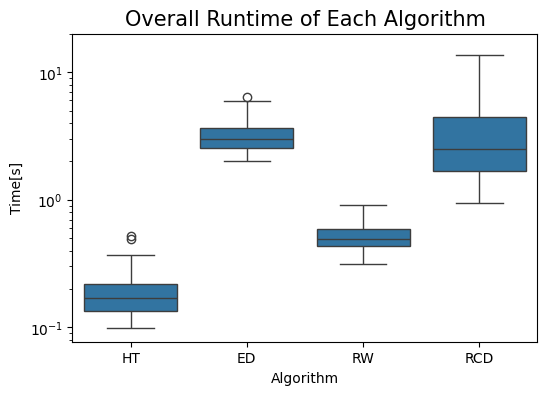

In [846]:
plot_runtime(runtime_all,directory_figures_path,'baseline_runtime','Algorithm')

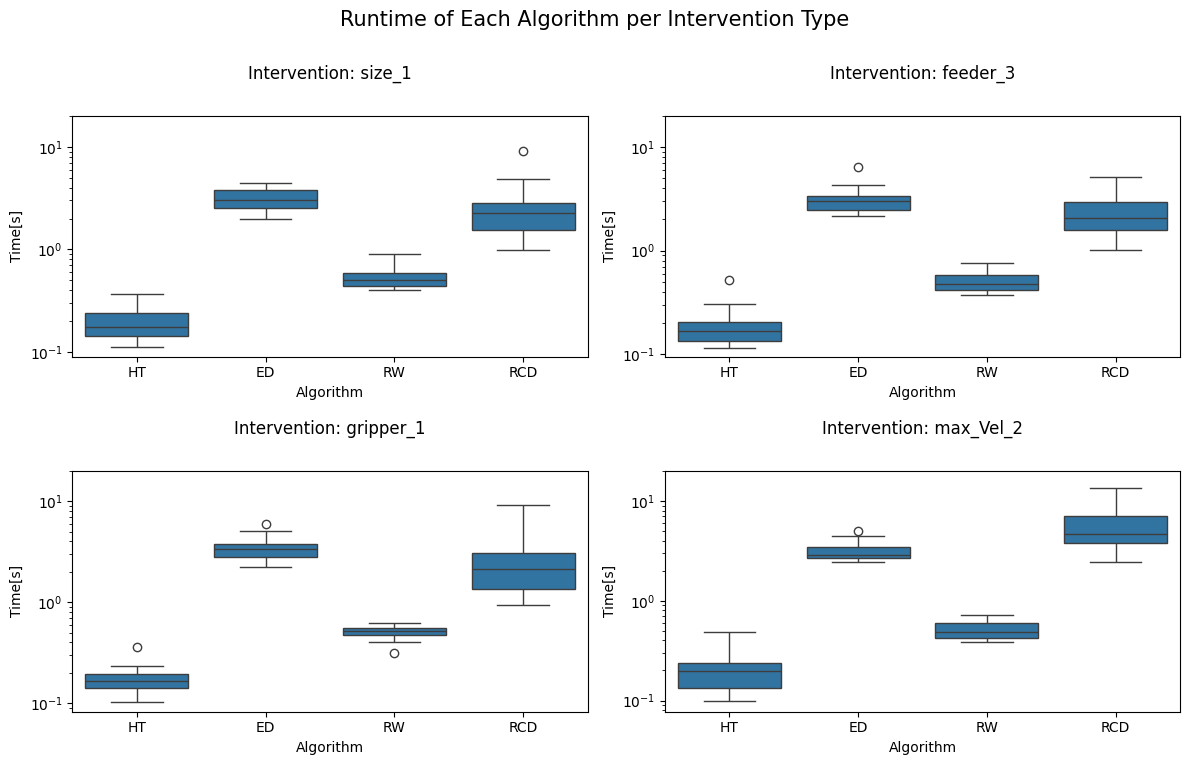

In [847]:
plot_runtime_inter(runtime_all,directory_figures_path,'baseline_runtime_inter','Algorithm')


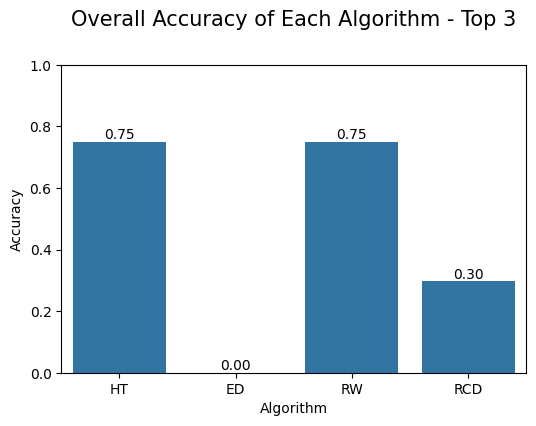

In [848]:
plot_avg_total(result_data_3top,directory_figures_path,'baseline_accuracy_3','Overall Accuracy of Each Algorithm - Top 3')


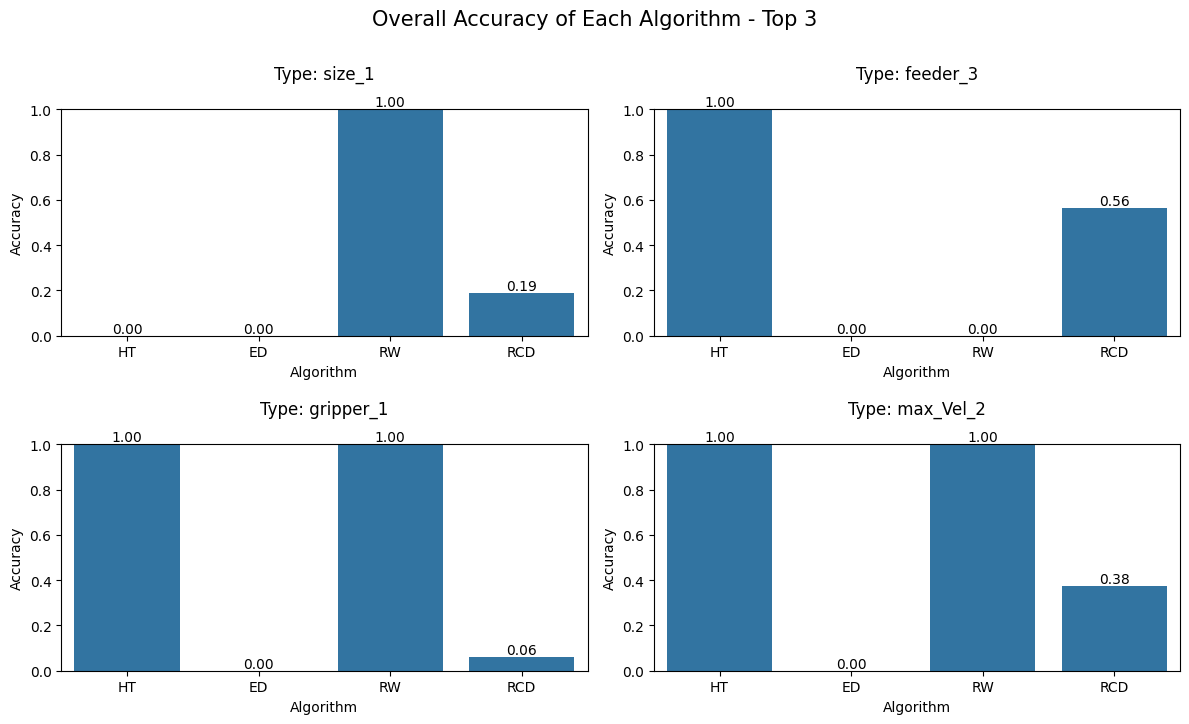

In [849]:
plot_avg_inter(result_data_3top,directory_figures_path,'baseline_accuracy_inter_3','Overall Accuracy of Each Algorithm - Top 3')


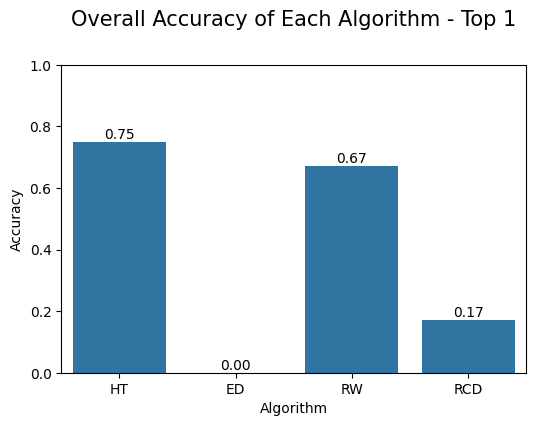

In [850]:
plot_avg_total(result_data_1top,directory_figures_path,'baseline_accuracy_1','Overall Accuracy of Each Algorithm - Top 1')


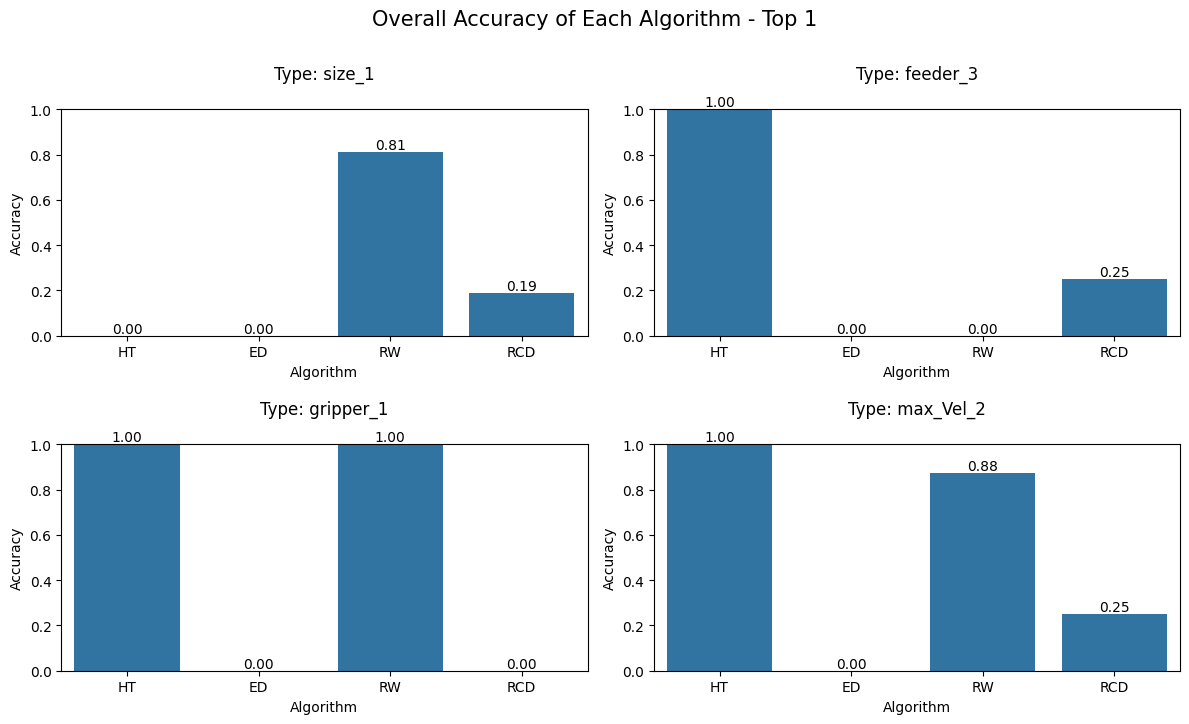

In [851]:
plot_avg_inter(result_data_1top,directory_figures_path,'baseline_accuracy_inter_1','Overall Accuracy of Each Algorithm - Top 1')

## Variation 1 - Overlap

### HT -Algorithm

In [852]:
result_HT_overlap_1, runtime_HT_overlap_1 = run_HT_overlap(folder_path,files,startrow=950,overlap_p=0.10,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_overlap_2, runtime_HT_overlap_2 = run_HT_overlap(folder_path,files,startrow=950,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_overlap_3, runtime_HT_overlap_3 = run_HT_overlap(folder_path,files,startrow=950,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_overlap_4, runtime_HT_overlap_4 = run_HT_overlap(folder_path,files,startrow=950,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_overlap_5, runtime_HT_overlap_5 = run_HT_overlap(folder_path,files,startrow=950,overlap_p=0.90,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [853]:
result_overlap_HT = pd.DataFrame()
result_overlap_HT = pd.concat([result_HT_overlap_1,result_HT_overlap_2,result_HT_overlap_3,result_HT_overlap_4,result_HT_overlap_5], ignore_index=True)
result_overlap_HT['Overlap Percent'] = pd.DataFrame({'HT':['10%','20%','50%','75%','90%']})
result_overlap_HT.set_index('Overlap Percent', inplace=True)

In [854]:
runtime_overlap_HT = pd.DataFrame()
runtime_overlap_HT = pd.concat([runtime_HT_overlap_1.T,runtime_HT_overlap_2.T,runtime_HT_overlap_3.T,runtime_HT_overlap_4.T,runtime_HT_overlap_5.T],ignore_index=True)
runtime_overlap_HT['Overlap Percent'] = pd.DataFrame({'HT':['10%','20%','50%','75%','90%']})
runtime_overlap_HT.set_index('Overlap Percent', inplace=True)


In [855]:
result_data_1top = results_top_1(result_overlap_HT,abnormal_sets)
result_data_3top = results_top_1(result_overlap_HT,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_HT.csv'))

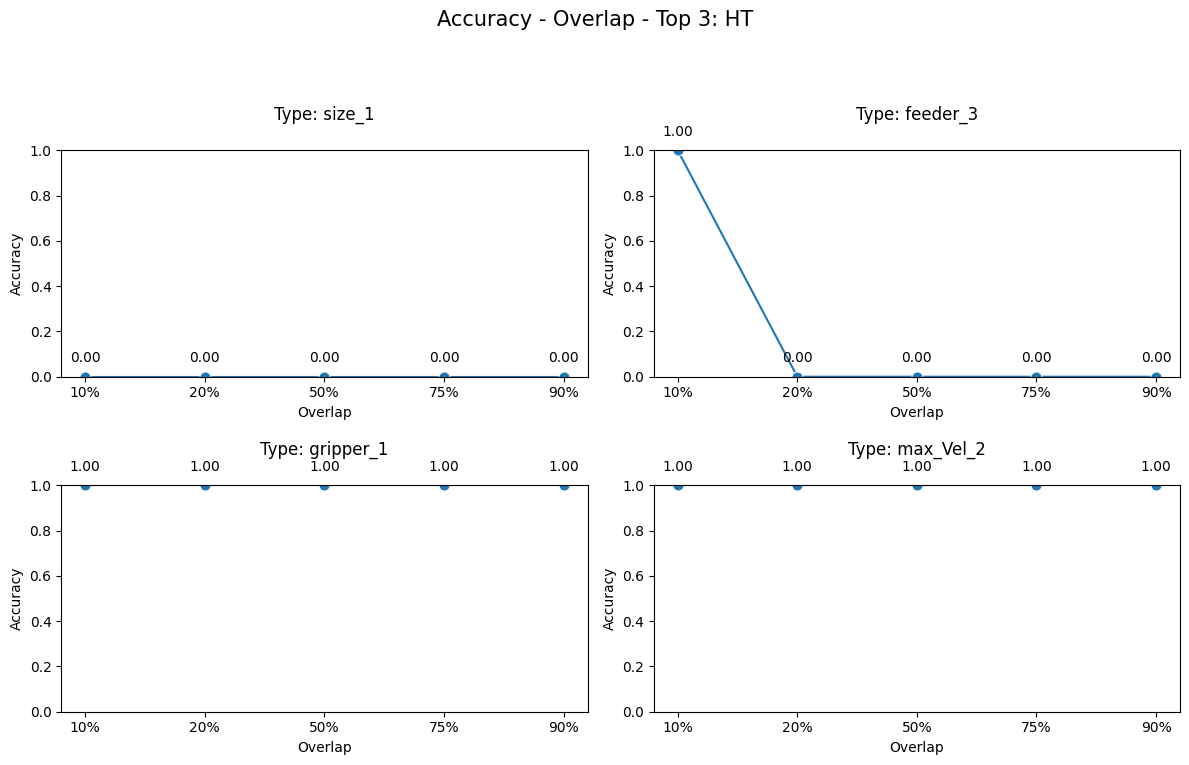

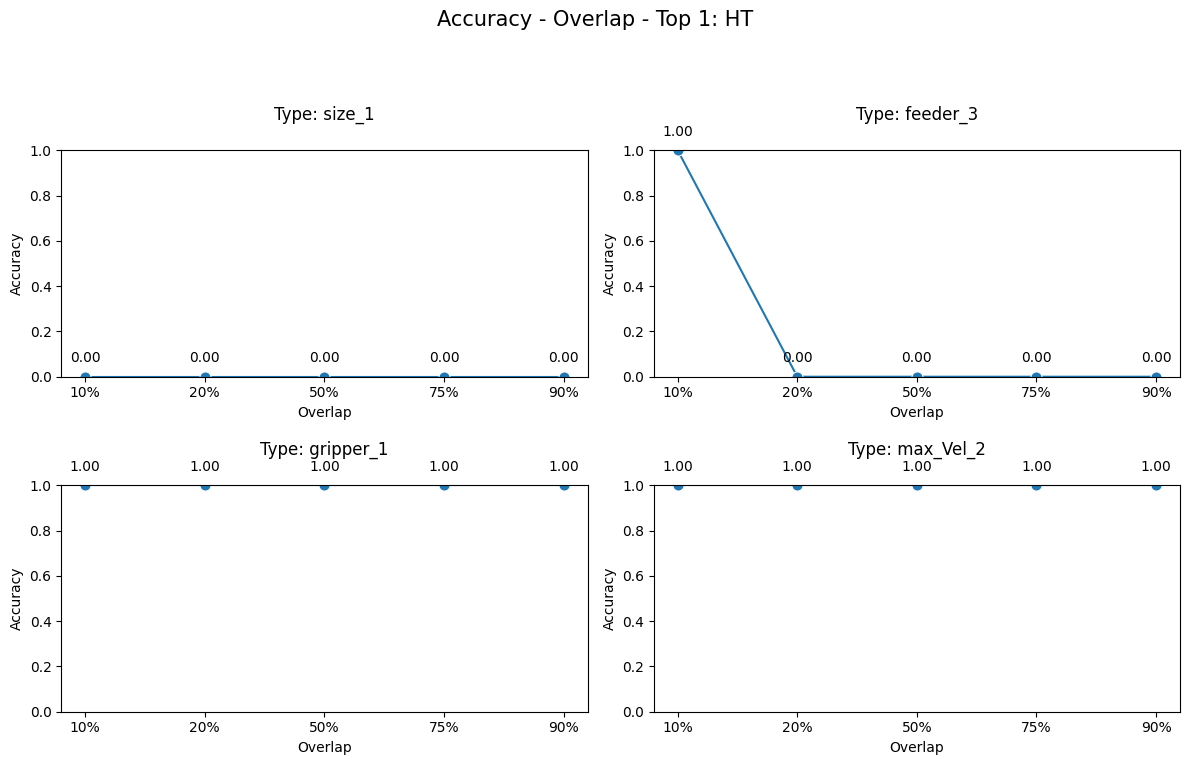

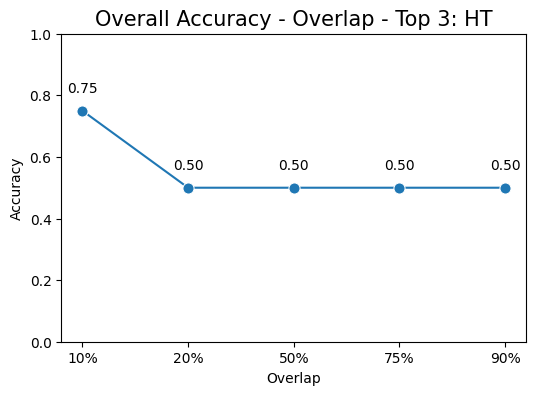

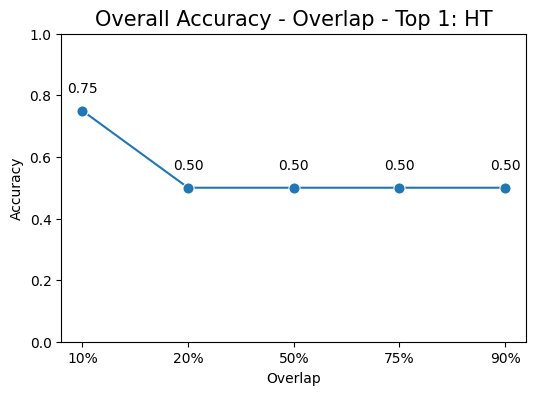

In [856]:
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_overlap_HT','Overlap','HT','Accuracy - Overlap - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_overlap_HT','Overlap','HT','Accuracy - Overlap - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_overlap_total_HT','Overlap','HT','Overall Accuracy - Overlap - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_overlap_total_HT','Overlap','HT','Overall Accuracy - Overlap - Top 1:')

### ED - Algorithm

In [857]:
result_ED_overlap_1, runtime_ED_overlap_1 = run_ED_overlap(folder_path,files,startrow=950,overlap_p=0.10,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_overlap_2, runtime_ED_overlap_2 = run_ED_overlap(folder_path,files,startrow=950,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_overlap_3, runtime_ED_overlap_3 = run_ED_overlap(folder_path,files,startrow=950,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_overlap_4, runtime_ED_overlap_4 = run_ED_overlap(folder_path,files,startrow=950,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_overlap_5, runtime_ED_overlap_5 = run_ED_overlap(folder_path,files,startrow=950,overlap_p=0.90,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [858]:
result_overlap_ED = pd.DataFrame()
result_overlap_ED = pd.concat([result_ED_overlap_1,result_ED_overlap_2,result_ED_overlap_3,result_ED_overlap_4,result_ED_overlap_5], ignore_index=True)
result_overlap_ED['Overlap Percent'] = pd.DataFrame({'ED':['10%','20%','50%','75%','90%']})
result_overlap_ED.set_index('Overlap Percent', inplace=True)

In [859]:
runtime_overlap_ED = pd.DataFrame()
runtime_overlap_ED = pd.concat([runtime_ED_overlap_1.T,runtime_ED_overlap_2.T,runtime_ED_overlap_3.T,runtime_ED_overlap_4.T,runtime_ED_overlap_5.T], ignore_index=True)
runtime_overlap_ED['Overlap Percent'] = pd.DataFrame({'ED':['10%','20%','50%','75%','90%']})
runtime_overlap_ED.set_index('Overlap Percent', inplace=True)

In [860]:
result_data_3top = results_top_3(result_overlap_ED,abnormal_sets)
result_data_1top = results_top_1(result_overlap_ED,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_ED.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_ED.csv'))

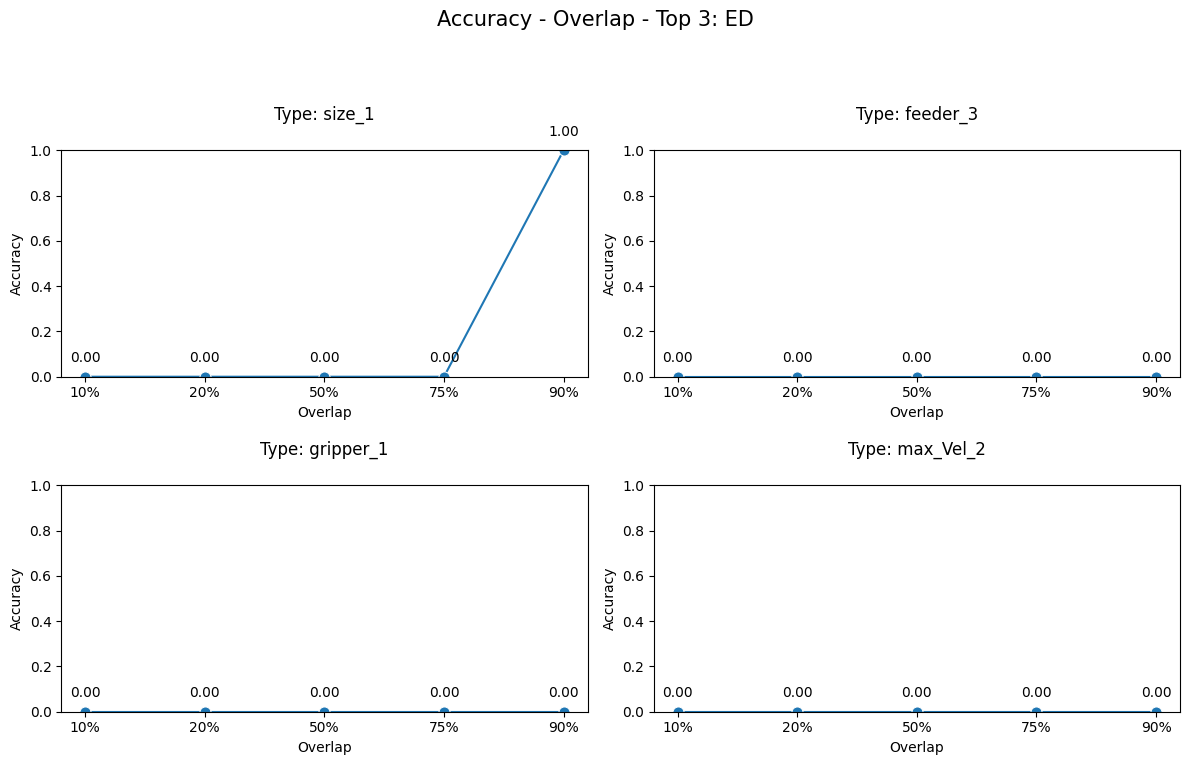

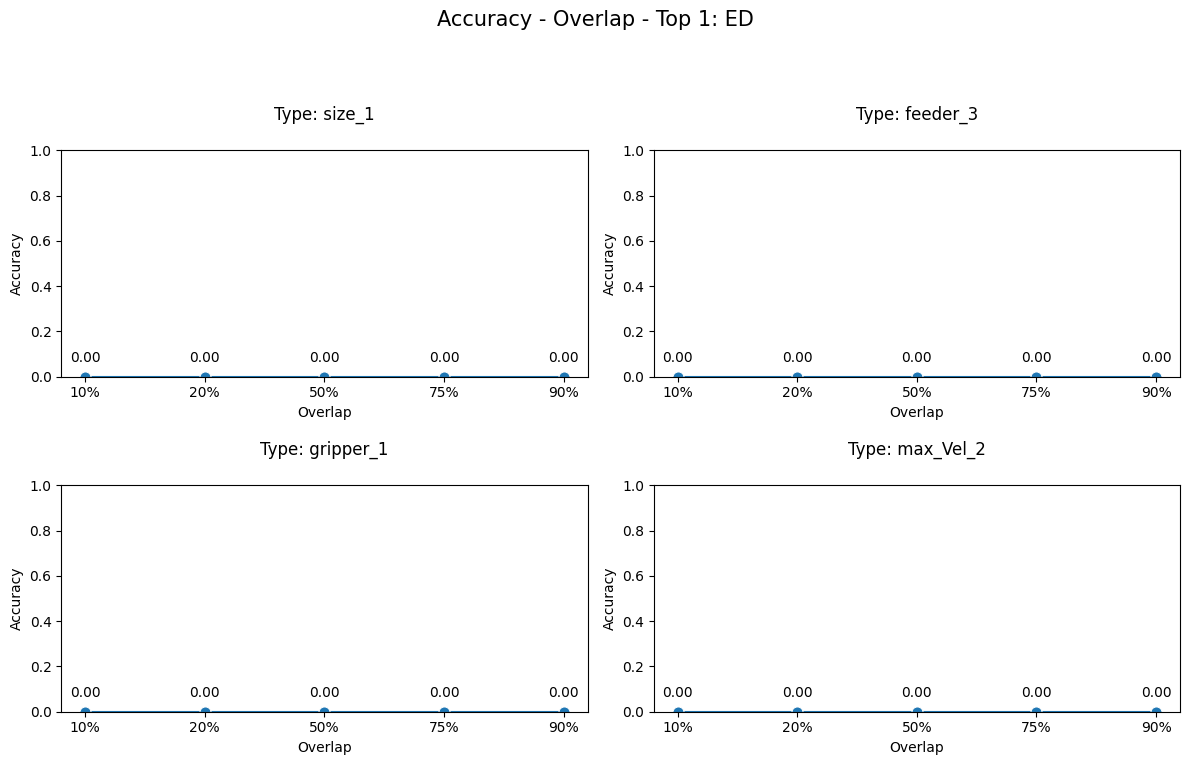

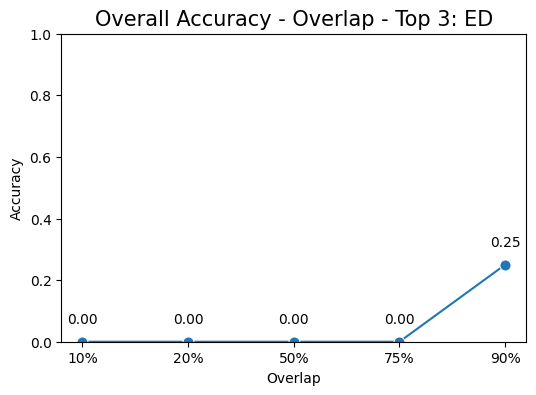

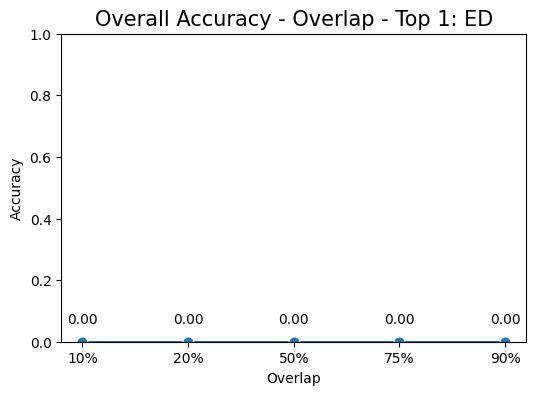

In [861]:
algo='ED'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_overlap_'+algo,'Overlap',algo,'Accuracy - Overlap - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_overlap_'+algo,'Overlap',algo,'Accuracy - Overlap - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_overlap_total_'+algo,'Overlap',algo,'Overall Accuracy - Overlap - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_overlap_total_'+algo,'Overlap',algo,'Overall Accuracy - Overlap - Top 1:')

### RW - Algorithm

In [862]:
result_RW_overlap_1, runtime_RW_overlap_1 = run_RW_overlap(folder_path,files,startrow=950,overlap_p=0.10,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_overlap_2, runtime_RW_overlap_2 = run_RW_overlap(folder_path,files,startrow=950,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_overlap_3, runtime_RW_overlap_3 = run_RW_overlap(folder_path,files,startrow=950,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_overlap_4, runtime_RW_overlap_4 = run_RW_overlap(folder_path,files,startrow=950,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_overlap_5, runtime_RW_overlap_5 = run_RW_overlap(folder_path,files,startrow=950,overlap_p=0.90,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [863]:
result_overlap_RW = pd.DataFrame()
result_overlap_RW = pd.concat([result_RW_overlap_1,result_RW_overlap_2,result_RW_overlap_3,result_RW_overlap_4,result_RW_overlap_5], ignore_index=True)
result_overlap_RW['Overlap Percent'] = pd.DataFrame({'RW':['10%','20%','50%','75%','90%']})
result_overlap_RW.set_index('Overlap Percent', inplace=True)

In [864]:
runtime_overlap_RW = pd.DataFrame()
runtime_overlap_RW = pd.concat([runtime_RW_overlap_1.T,runtime_RW_overlap_2.T,runtime_RW_overlap_3.T,runtime_RW_overlap_4.T,runtime_RW_overlap_5.T], ignore_index=True)
runtime_overlap_RW['Overlap Percent'] = pd.DataFrame({'RW':['10%','20%','50%','75%','90%']})
runtime_overlap_RW.set_index('Overlap Percent', inplace=True)

In [865]:
result_data_3top = results_top_3(result_overlap_RW,abnormal_sets)
result_data_1top = results_top_1(result_overlap_RW,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_RW.csv'))

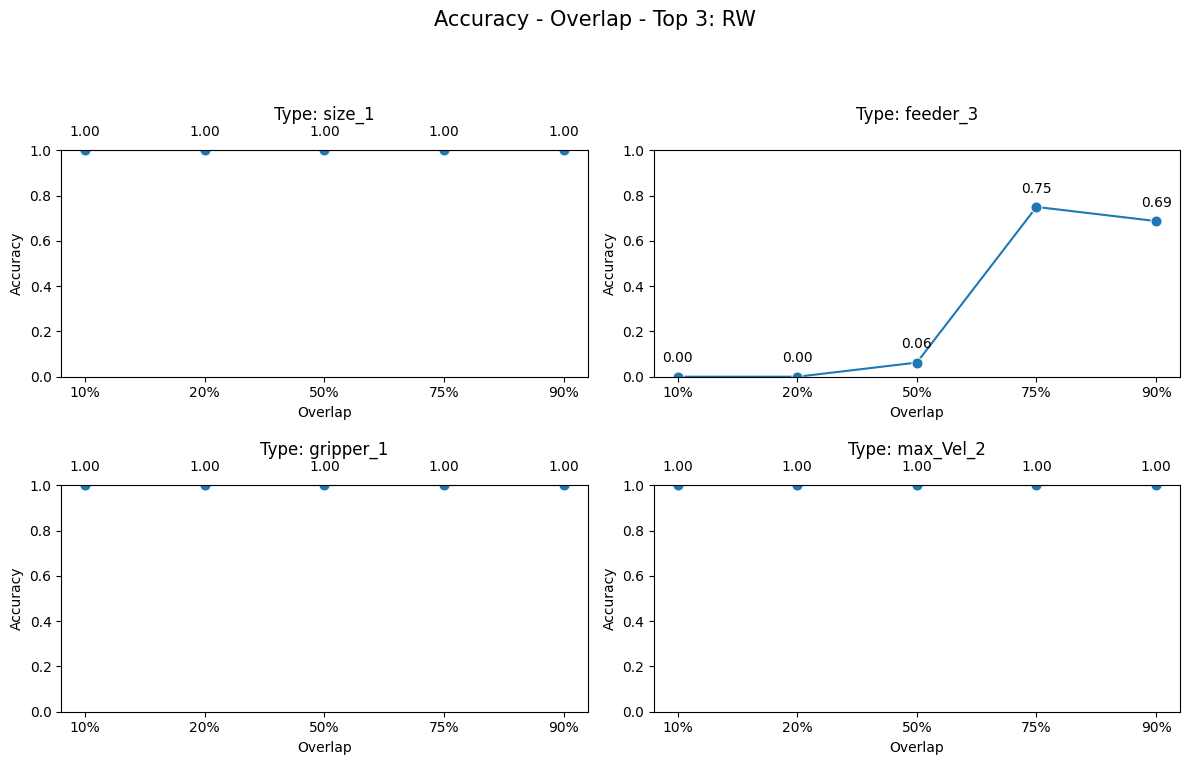

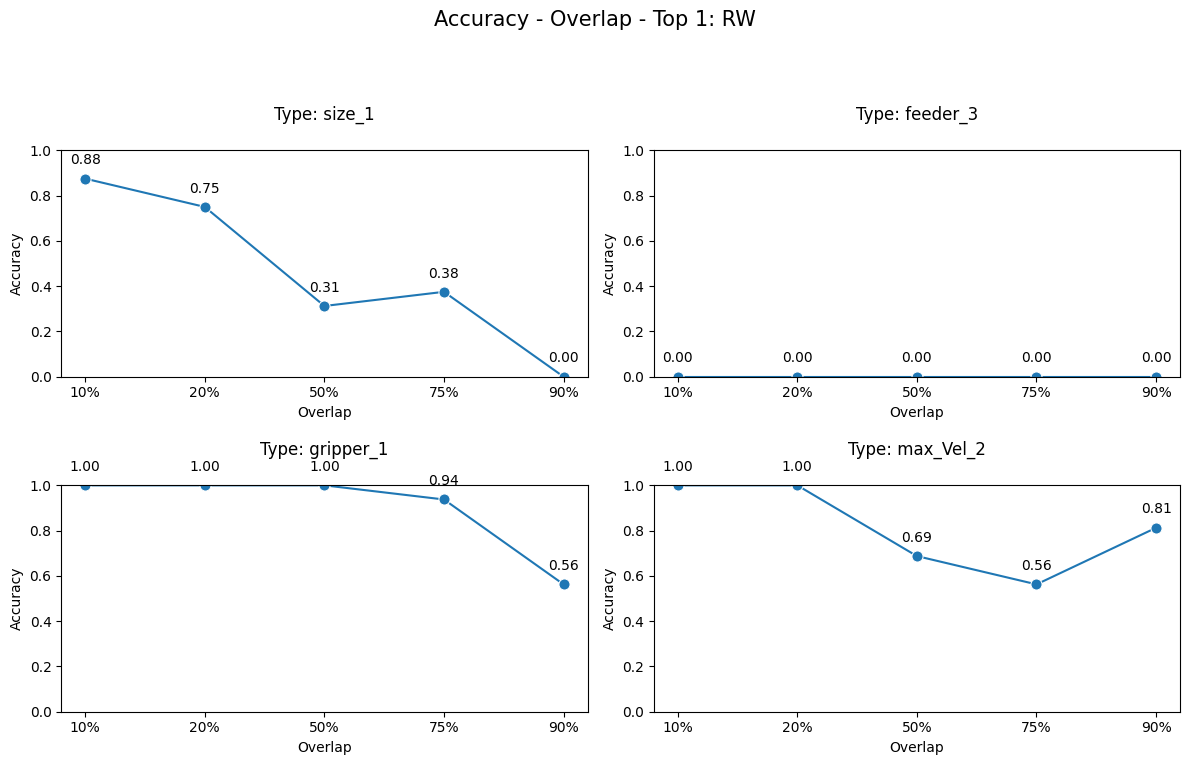

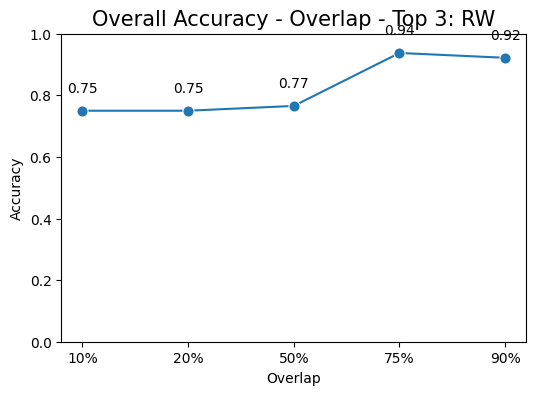

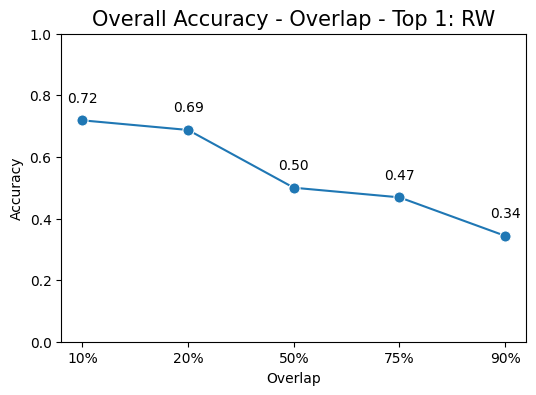

In [866]:
algo='RW'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_overlap_'+algo,'Overlap',algo,'Accuracy - Overlap - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_overlap_'+algo,'Overlap',algo,'Accuracy - Overlap - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_overlap_total_'+algo,'Overlap',algo,'Overall Accuracy - Overlap - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_overlap_total_'+algo,'Overlap',algo,'Overall Accuracy - Overlap - Top 1:')

### RCD - Algorithm

In [867]:
result_RCD_overlap_1, runtime_RCD_overlap_1 = run_RCD_overlap(folder_path,files,startrow=950,overlap_p=0.1,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_overlap_2, runtime_RCD_overlap_2 = run_RCD_overlap(folder_path,files,startrow=950,overlap_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_overlap_3, runtime_RCD_overlap_3 = run_RCD_overlap(folder_path,files,startrow=950,overlap_p=0.50,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_overlap_4, runtime_RCD_overlap_4 = run_RCD_overlap(folder_path,files,startrow=950,overlap_p=0.75,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_overlap_5, runtime_RCD_overlap_5 = run_RCD_overlap(folder_path,files,startrow=950,overlap_p=0.90,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [868]:
result_overlap_RCD = pd.DataFrame()
result_overlap_RCD = pd.concat([result_RCD_overlap_1,result_RCD_overlap_2,result_RCD_overlap_3,result_RCD_overlap_4,result_RCD_overlap_5], ignore_index=True)
result_overlap_RCD['Overlap Percent'] = pd.DataFrame({'RCD':['10%','20%','50%','75%','90%']})
result_overlap_RCD.set_index('Overlap Percent', inplace=True)

In [869]:
runtime_overlap_RCD = pd.DataFrame()
runtime_overlap_RCD = pd.concat([runtime_RCD_overlap_1.T,runtime_RCD_overlap_2.T,runtime_RCD_overlap_3.T,runtime_RCD_overlap_4.T,runtime_RCD_overlap_5.T], ignore_index=True)
runtime_overlap_RCD['Overlap Percent'] = pd.DataFrame({'RCD':['10%','20%','50%','75%','90%']})
runtime_overlap_RCD.set_index('Overlap Percent', inplace=True)

In [870]:
result_data_3top = results_top_3(result_overlap_RCD,abnormal_sets)
result_data_1top = results_top_1(result_overlap_RCD,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_1_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_1_RCD.csv'))

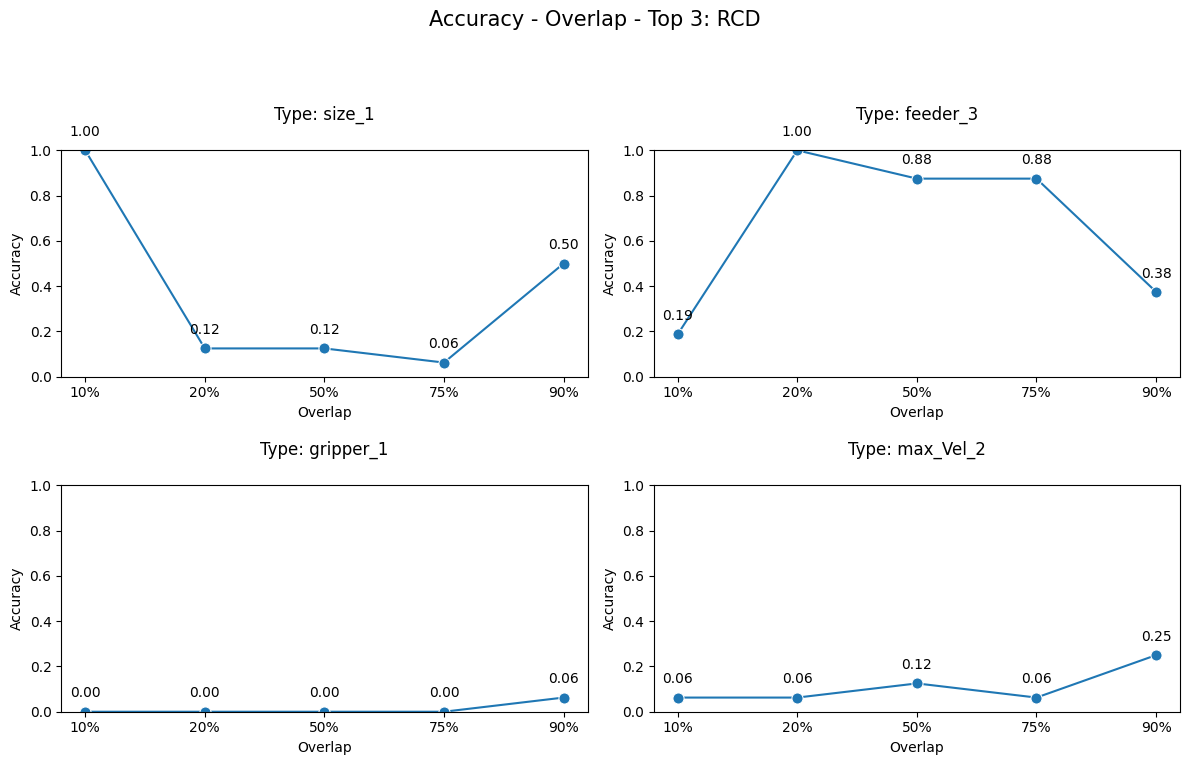

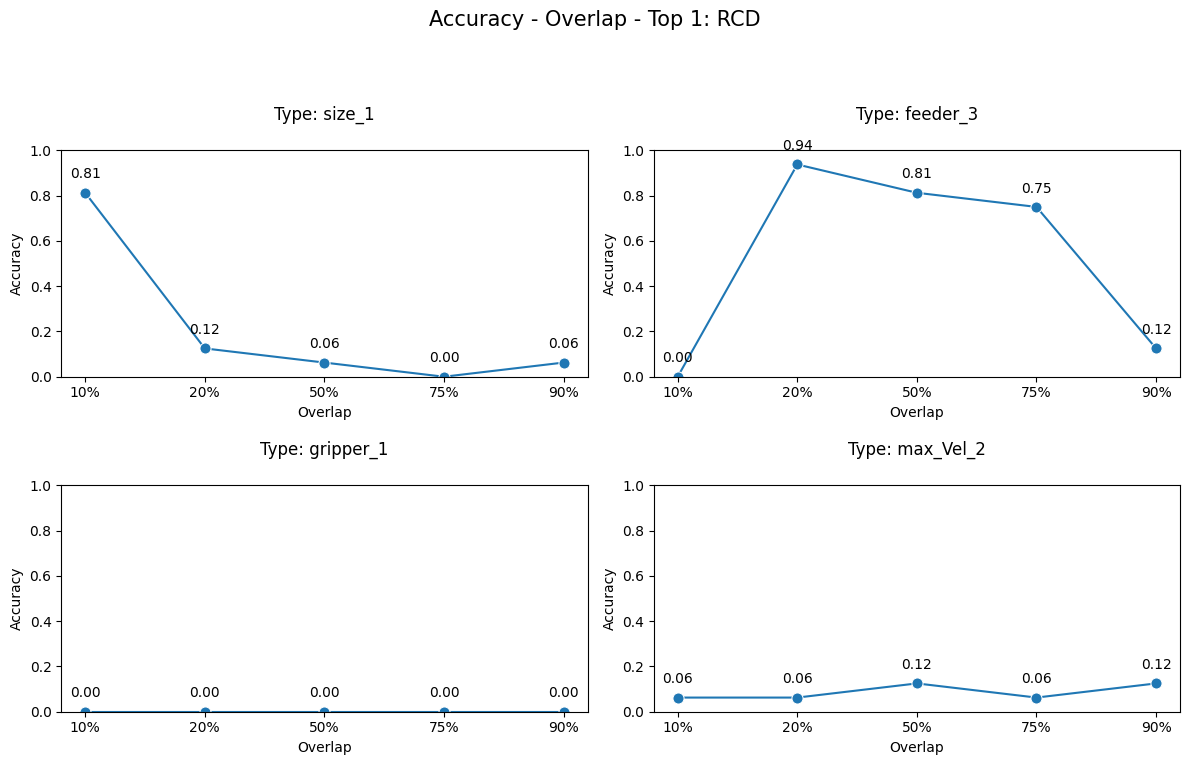

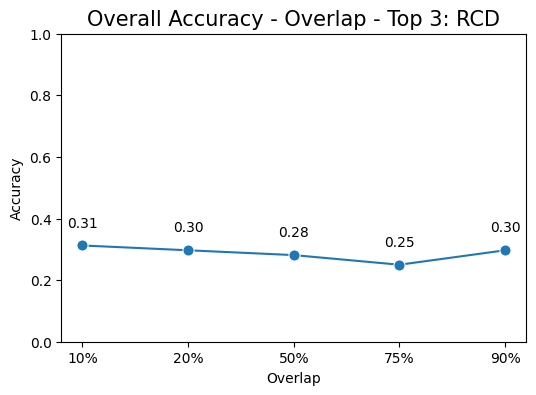

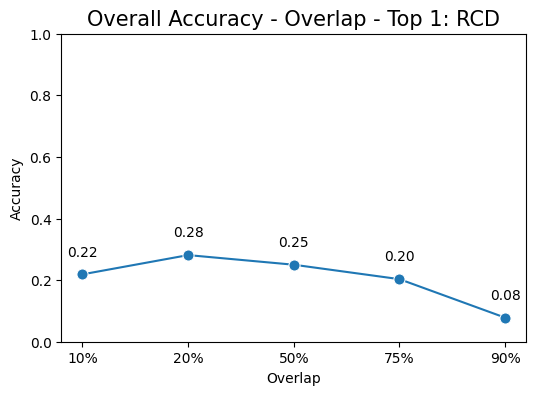

In [871]:
algo='RCD'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_overlap_'+algo,'Overlap',algo,'Accuracy - Overlap - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_overlap_'+algo,'Overlap',algo,'Accuracy - Overlap - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_overlap_total_'+algo,'Overlap',algo,'Overall Accuracy - Overlap - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_overlap_total_'+algo,'Overlap',algo,'Overall Accuracy - Overlap - Top 1:')

### All together

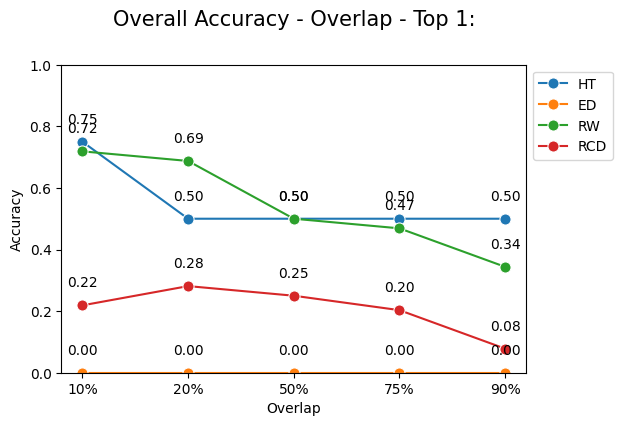

In [883]:
result1 = results_top_1(result_overlap_HT,abnormal_sets)
result2 = results_top_1(result_overlap_ED,abnormal_sets)
result3 = results_top_1(result_overlap_RW,abnormal_sets)
result4 = results_top_1(result_overlap_RCD,abnormal_sets)

results_dfs = [result1,result2,result3,result4]
plot_avg_var_total_combined(results_dfs,['HT','ED','RW','RCD'] ,directory_figures_path,'1top_overlap_total','Overlap','Overall Accuracy - Overlap - Top 1:')

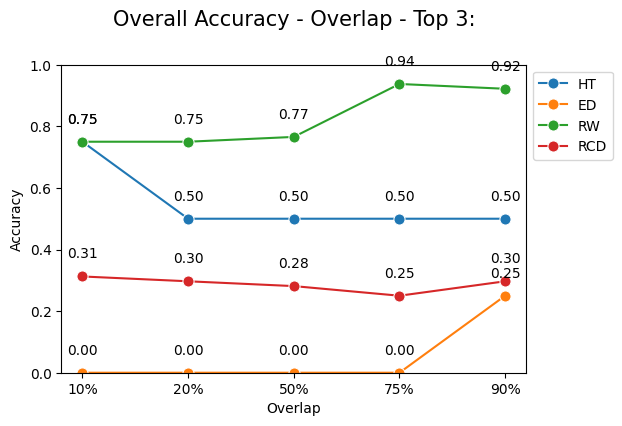

In [884]:
result1 = results_top_3(result_overlap_HT,abnormal_sets)
result2 = results_top_3(result_overlap_ED,abnormal_sets)
result3 = results_top_3(result_overlap_RW,abnormal_sets)
result4 = results_top_3(result_overlap_RCD,abnormal_sets)

results_dfs = [result1,result2,result3,result4]
plot_avg_var_total_combined(results_dfs,['HT','ED','RW','RCD'] ,directory_figures_path,'3top_overlap_total','Overlap','Overall Accuracy - Overlap - Top 3:')

## Variation 2 - Normal Size

The ED-algorithm requires the same length for the normal and abnormal data set.

### HT - Algorithm

In [885]:
result_HT_normal_size_1, runtime_HT_normal_size_1 = run_HT_normal_size(folder_path,files,startrow=950,normal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_normal_size_2, runtime_HT_normal_size_2 = run_HT_normal_size(folder_path,files,startrow=950,normal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_normal_size_3, runtime_HT_normal_size_3 = run_HT_normal_size(folder_path,files,startrow=950,normal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_normal_size_4, runtime_HT_normal_size_4  = run_HT_normal_size(folder_path,files,startrow=950,normal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_normal_size_5, runtime_HT_normal_size_5= run_HT_normal_size(folder_path,files,startrow=950,normal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [886]:
result_normal_size_HT = pd.DataFrame()
result_normal_size_HT = pd.concat([result_HT_normal_size_1,result_HT_normal_size_2,result_HT_normal_size_3,result_HT_normal_size_4,result_HT_normal_size_5], ignore_index=True)
result_normal_size_HT['Normal Size Percent'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
result_normal_size_HT.set_index('Normal Size Percent', inplace=True)

In [887]:
runtime_normal_size_HT = pd.DataFrame()
runtime_normal_size_HT = pd.concat([runtime_HT_normal_size_1.T,runtime_HT_normal_size_2.T,runtime_HT_normal_size_3.T,runtime_HT_normal_size_4.T,runtime_HT_normal_size_5.T], ignore_index=True)
runtime_normal_size_HT['Normal Size Percent'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
runtime_normal_size_HT.set_index('Normal Size Percent', inplace=True)

In [888]:
result_data_3top = results_top_3(result_normal_size_HT,abnormal_sets)
result_data_1top = results_top_1(result_normal_size_HT,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_2_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_2_HT.csv'))

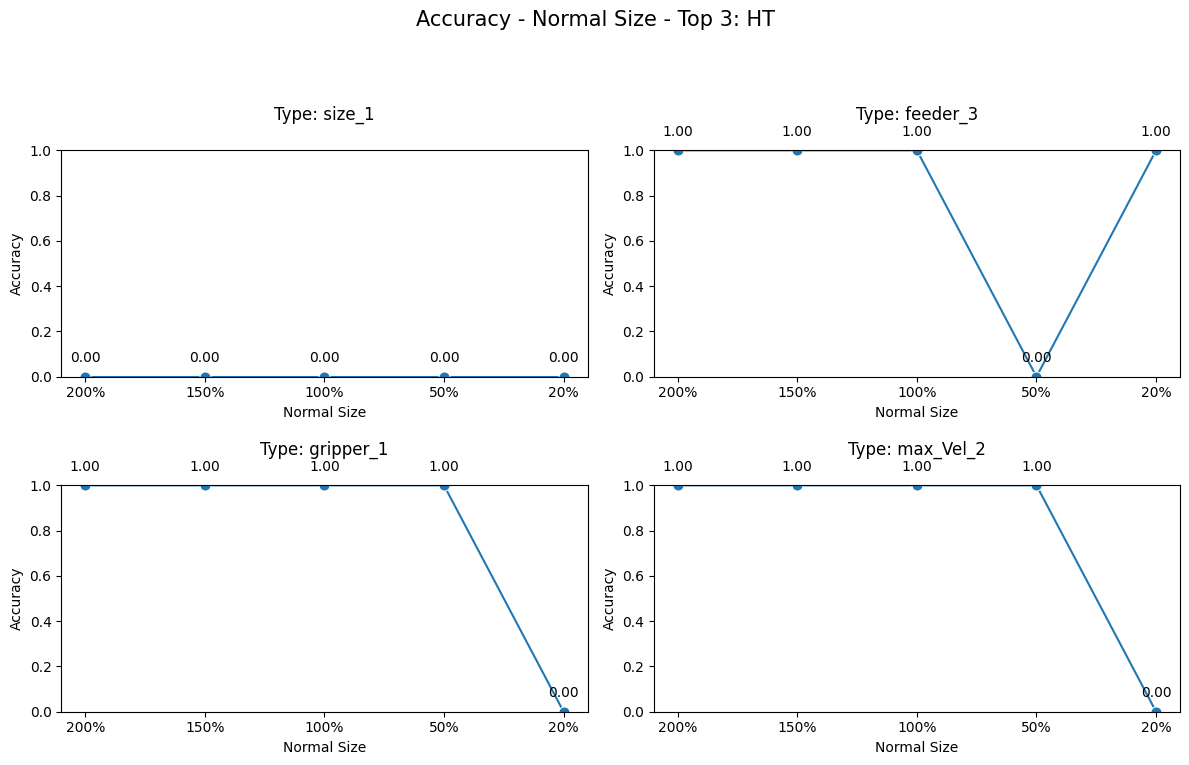

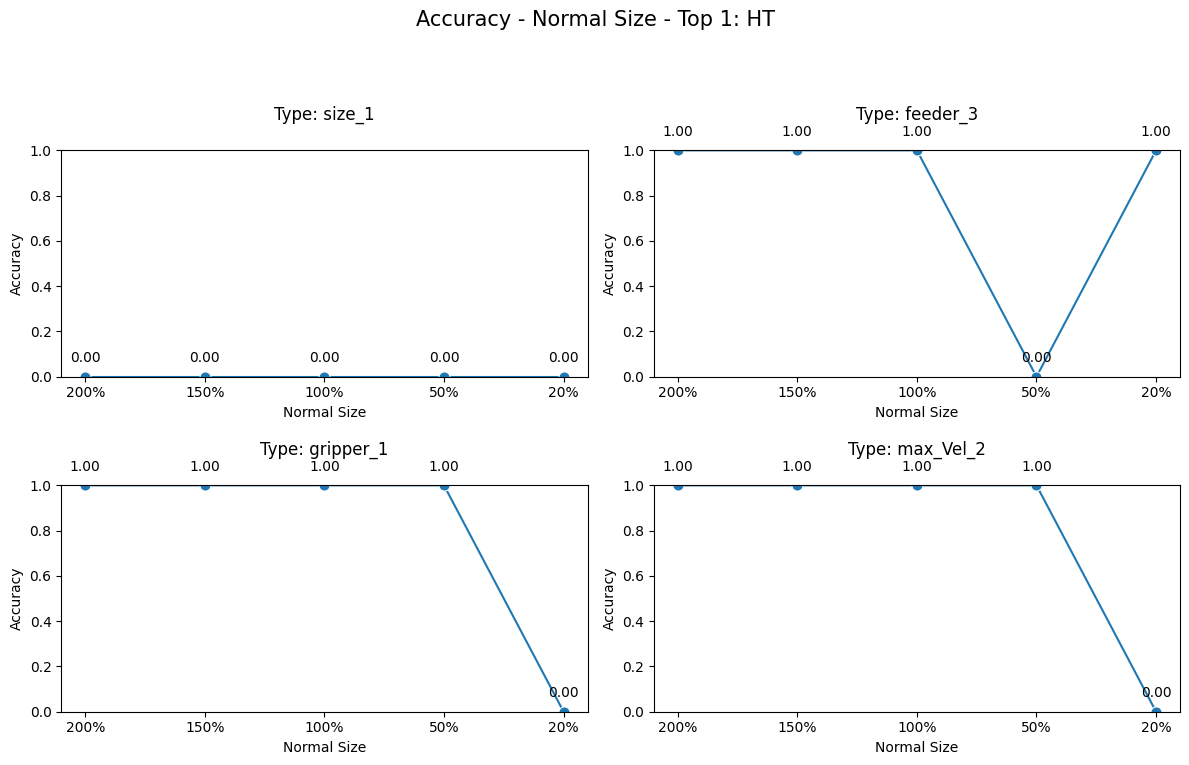

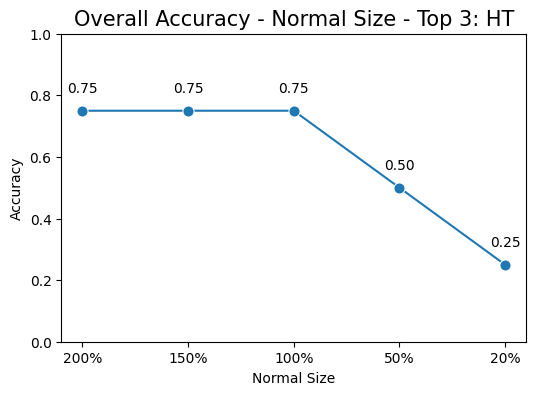

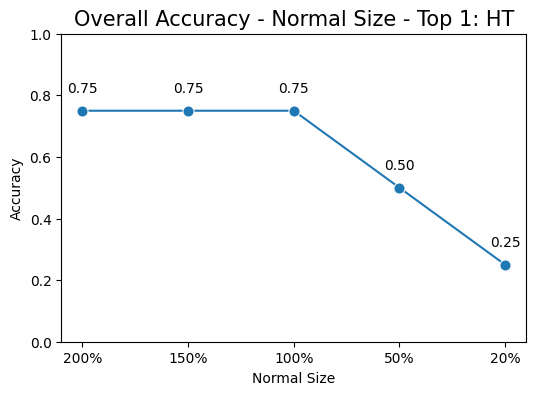

In [889]:
algo='HT'
var='Normal Size'
var_save='normal_size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### RW - Algorithm

In [890]:
result_RW_normal_size_1, runtime_RW_normal_size_1 = run_RW_normal_size(folder_path,files,startrow=950,normal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_normal_size_2, runtime_RW_normal_size_2 = run_RW_normal_size(folder_path,files,startrow=950,normal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_normal_size_3, runtime_RW_normal_size_3 = run_RW_normal_size(folder_path,files,startrow=950,normal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_normal_size_4, runtime_RW_normal_size_4 = run_RW_normal_size(folder_path,files,startrow=950,normal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_normal_size_5, runtime_RW_normal_size_5 = run_RW_normal_size(folder_path,files,startrow=950,normal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [891]:
result_normal_size_RW = pd.DataFrame()
result_normal_size_RW = pd.concat([result_RW_normal_size_1,result_RW_normal_size_2,result_RW_normal_size_3,result_RW_normal_size_4,result_RW_normal_size_5], ignore_index=True)
result_normal_size_RW['Normal Size Percent'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
result_normal_size_RW.set_index('Normal Size Percent', inplace=True)

In [892]:
runtime_normal_size_RW = pd.DataFrame()
runtime_normal_size_RW = pd.concat([runtime_RW_normal_size_1.T,runtime_RW_normal_size_2.T,runtime_RW_normal_size_3.T,runtime_RW_normal_size_4.T,runtime_RW_normal_size_5.T], ignore_index=True)
runtime_normal_size_RW['Normal Size Percent'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
runtime_normal_size_RW.set_index('Normal Size Percent', inplace=True)

In [893]:
result_data_3top = results_top_3(result_normal_size_RW,abnormal_sets)
result_data_1top = results_top_1(result_normal_size_RW,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_2_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_2_RW.csv'))

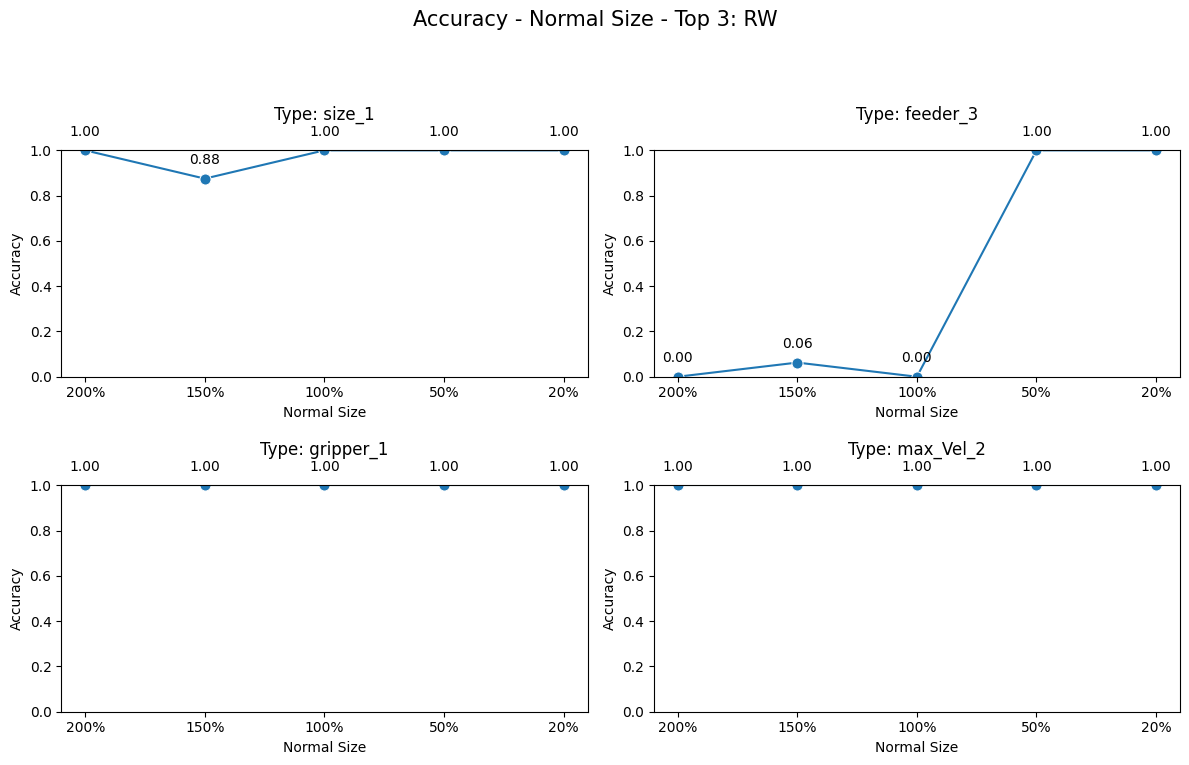

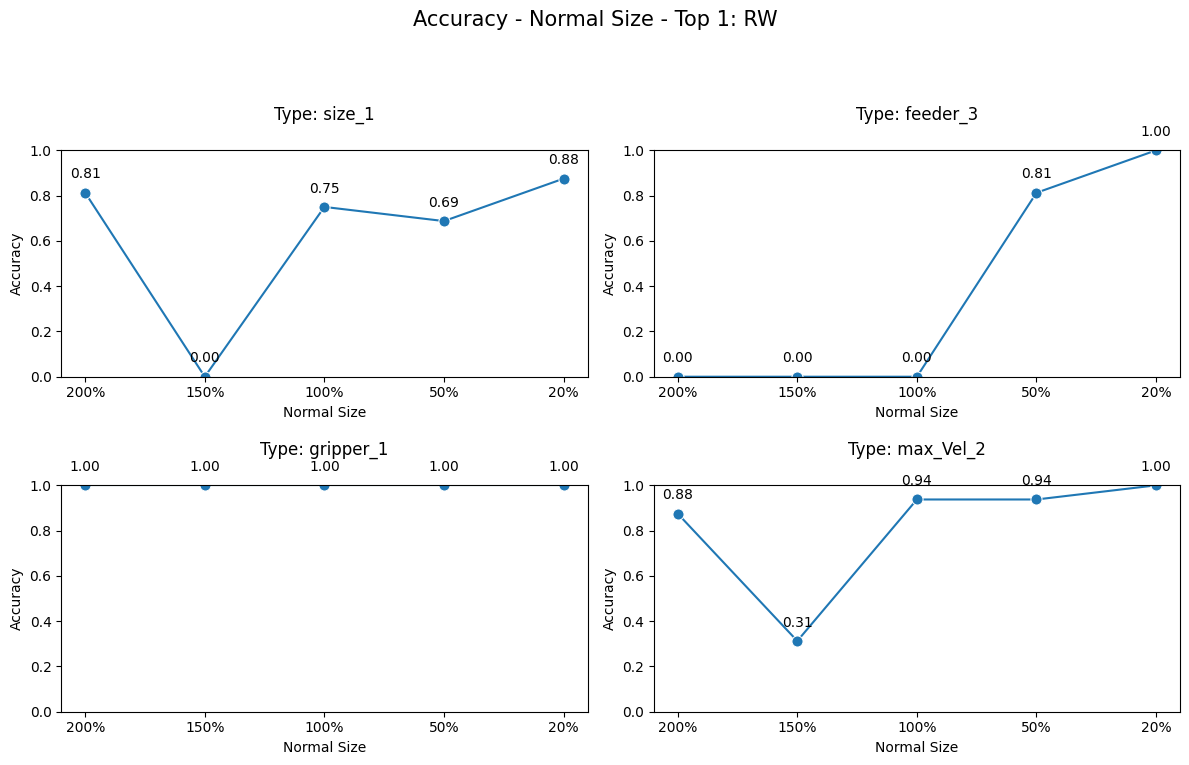

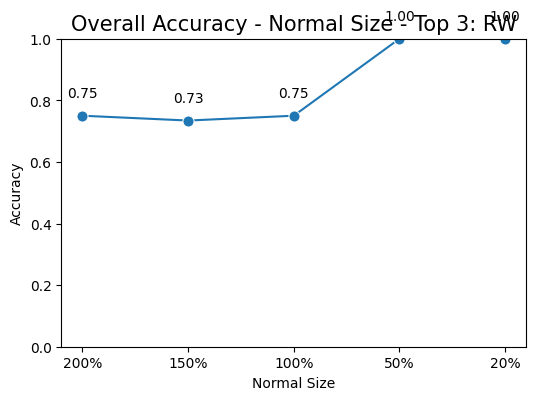

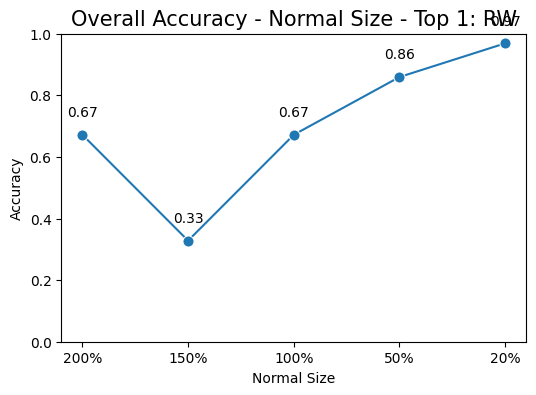

In [894]:
algo='RW'
var='Normal Size'
var_save='normal_size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### RCD - Algorithm

In [895]:
result_RCD_normal_size_1, runtime_RCD_normal_size_1 = run_RCD_normal_size(folder_path,files,startrow=950,normal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_normal_size_2, runtime_RCD_normal_size_2 = run_RCD_normal_size(folder_path,files,startrow=950,normal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_normal_size_3, runtime_RCD_normal_size_3 = run_RCD_normal_size(folder_path,files,startrow=950,normal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_normal_size_4, runtime_RCD_normal_size_4 = run_RCD_normal_size(folder_path,files,startrow=950,normal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_normal_size_5, runtime_RCD_normal_size_5 = run_RCD_normal_size(folder_path,files,startrow=950,normal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)


In [896]:
result_normal_size_RCD = pd.DataFrame()
result_normal_size_RCD = pd.concat([result_RCD_normal_size_1,result_RCD_normal_size_2,result_RCD_normal_size_3,result_RCD_normal_size_4,result_RCD_normal_size_5], ignore_index=True)
result_normal_size_RCD['Normal Size Percent'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
result_normal_size_RCD.set_index('Normal Size Percent', inplace=True)

In [897]:
runtime_normal_size_RCD = pd.DataFrame()
runtime_normal_size_RCD = pd.concat([runtime_RCD_normal_size_1.T,runtime_RCD_normal_size_2.T,runtime_RCD_normal_size_3.T,runtime_RCD_normal_size_4.T,runtime_RCD_normal_size_5.T], ignore_index=True)
runtime_normal_size_RCD['Normal Size Percent'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
runtime_normal_size_RCD.set_index('Normal Size Percent', inplace=True)

In [898]:
result_data_3top = results_top_3(result_normal_size_RCD,abnormal_sets)
result_data_1top = results_top_1(result_normal_size_RCD,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_2_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_2_RCD.csv'))

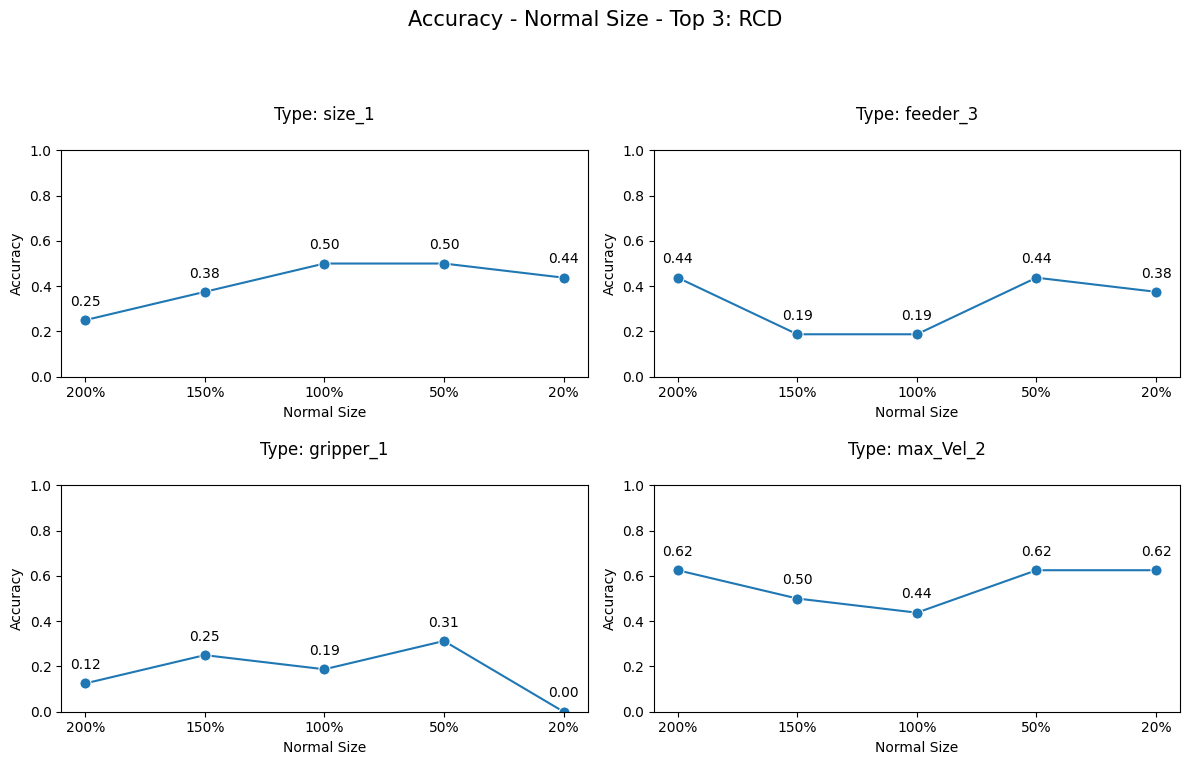

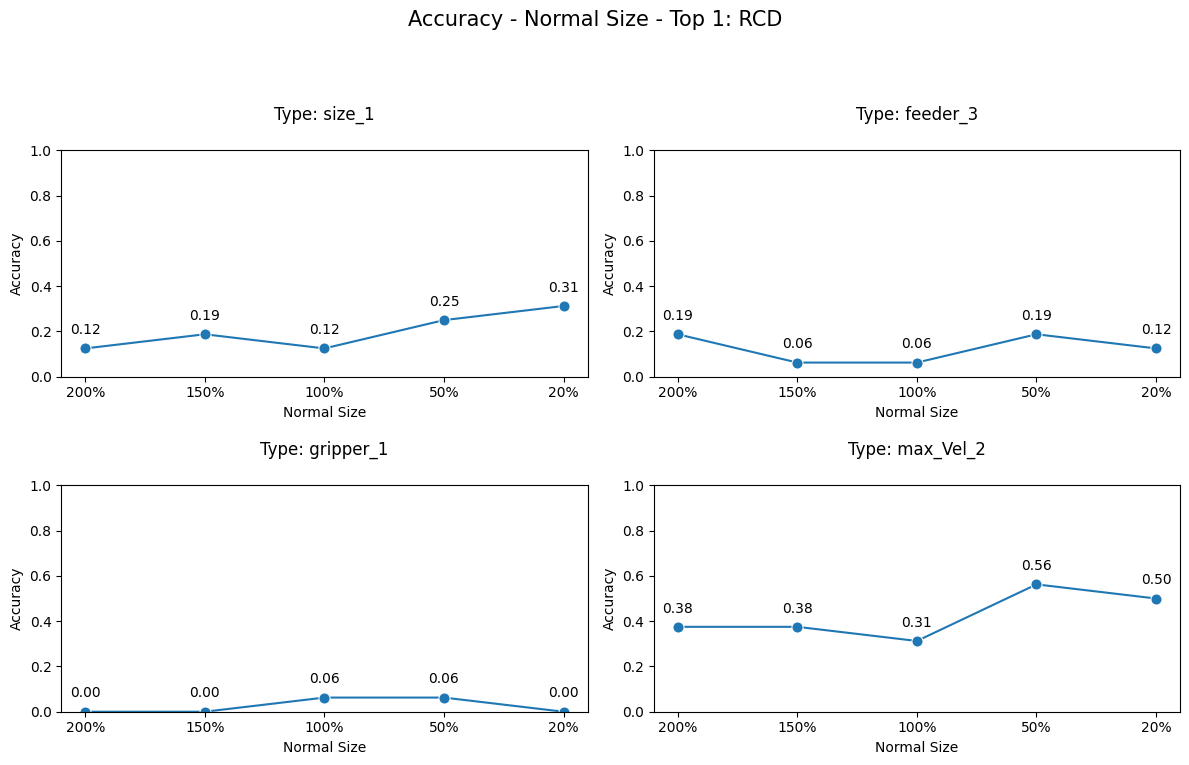

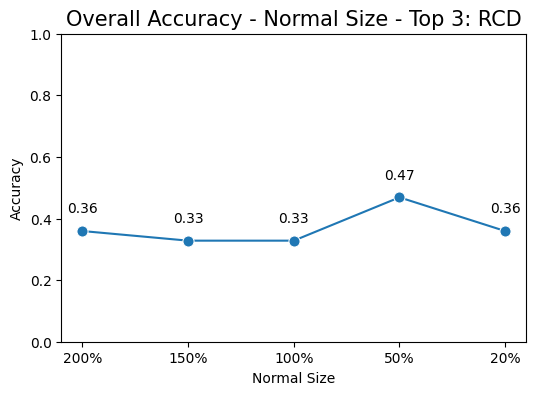

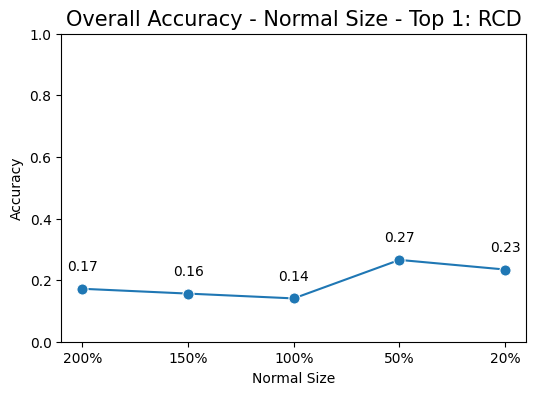

In [899]:
algo='RCD'
var='Normal Size'
var_save='normal_size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### All together

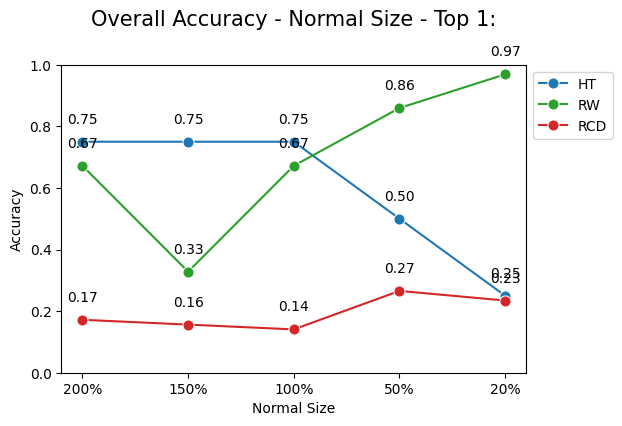

In [900]:
result1 = results_top_1(result_normal_size_HT,abnormal_sets)
result2 = results_top_1(result_normal_size_RW,abnormal_sets)
result3 = results_top_1(result_normal_size_RCD,abnormal_sets)

results_dfs = [result1,result2,result3]
plot_avg_var_total_combined(results_dfs,['HT','RW','RCD'] ,directory_figures_path,'1top_normal_size_total','Normal Size','Overall Accuracy - Normal Size - Top 1:')

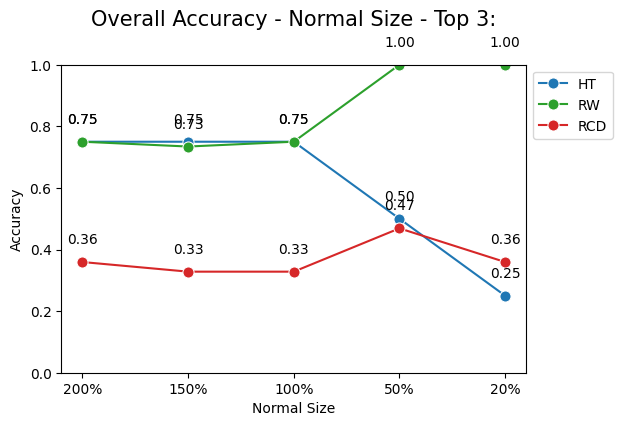

In [901]:
result1 = results_top_3(result_normal_size_HT,abnormal_sets)
result2 = results_top_3(result_normal_size_RW,abnormal_sets)
result3 = results_top_3(result_normal_size_RCD,abnormal_sets)

results_dfs = [result1,result2,result3]
plot_avg_var_total_combined(results_dfs,['HT','RW','RCD'] ,directory_figures_path,'3top_normal_size_total','Normal Size','Overall Accuracy - Normal Size - Top 3:')

## Variation 3 - Abnormal Size

The ED-algorithm requires the same length for the normal and abnormal data set.

### HT - Algorithm

In [902]:
result_HT_abnormal_size_1, runtime_HT_abnormal_size_1 = run_HT_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_abnormal_size_2, runtime_HT_abnormal_size_2 = run_HT_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_abnormal_size_3, runtime_HT_abnormal_size_3 = run_HT_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_abnormal_size_4, runtime_HT_abnormal_size_4 = run_HT_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_abnormal_size_5, runtime_HT_abnormal_size_5 = run_HT_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [903]:
result_abnormal_size_HT = pd.DataFrame()
result_abnormal_size_HT = pd.concat([result_HT_abnormal_size_1,result_HT_abnormal_size_2,result_HT_abnormal_size_3,result_HT_abnormal_size_4,result_HT_abnormal_size_5], ignore_index=True)
result_abnormal_size_HT['abnormal Size Percent'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
result_abnormal_size_HT.set_index('abnormal Size Percent', inplace=True)

In [904]:
runtime_abnormal_size_HT = pd.DataFrame()
runtime_abnormal_size_HT = pd.concat([runtime_HT_abnormal_size_1.T,runtime_HT_abnormal_size_2.T,runtime_HT_abnormal_size_3.T,runtime_HT_abnormal_size_4.T,runtime_HT_abnormal_size_5.T], ignore_index=True)
runtime_abnormal_size_HT['abnormal Size Percent'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
runtime_abnormal_size_HT.set_index('abnormal Size Percent', inplace=True)

In [905]:
result_data_3top = results_top_3(result_abnormal_size_HT,abnormal_sets)
result_data_1top = results_top_1(result_abnormal_size_HT,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_3_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_3_HT.csv'))

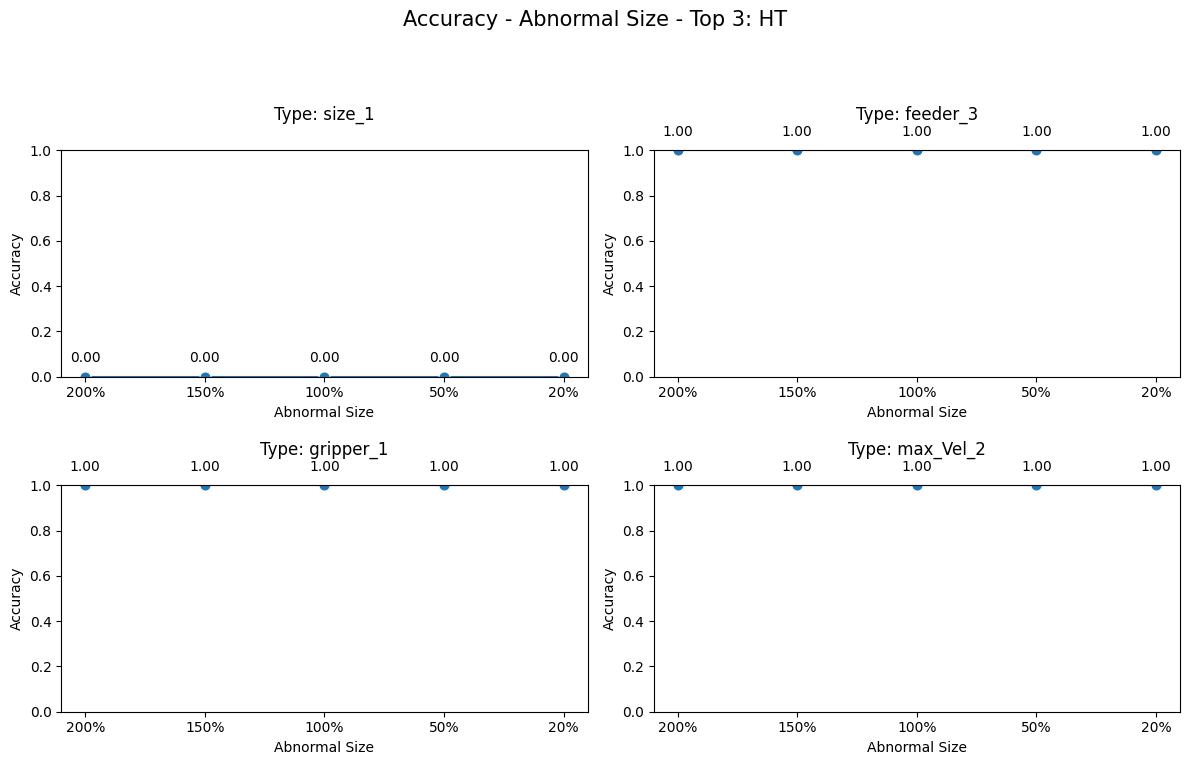

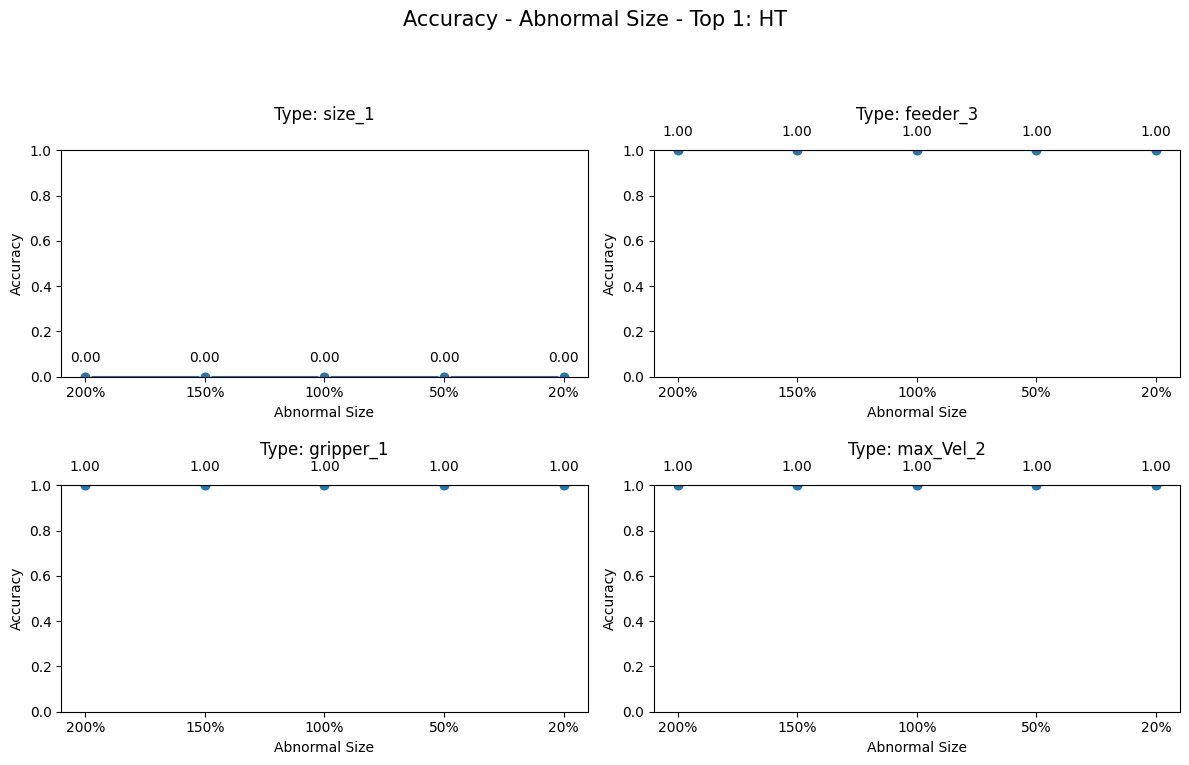

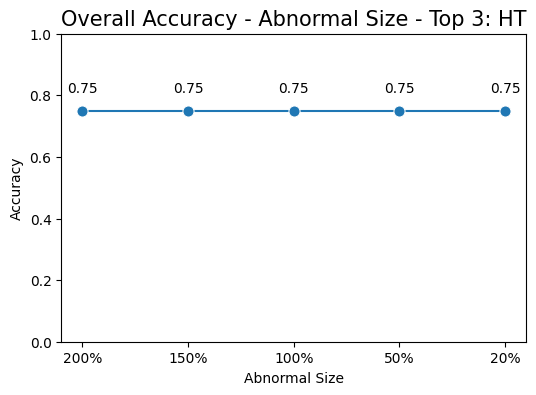

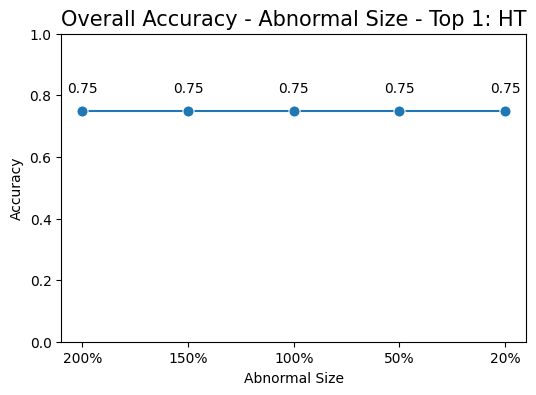

In [906]:
algo='HT'
var='Abnormal Size'
var_save='abnormal_size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### RW - Algorithm

In [907]:
result_RW_abnormal_size_1, runtime_RW_abnormal_size_1 = run_RW_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_abnormal_size_2, runtime_RW_abnormal_size_2= run_RW_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_abnormal_size_3, runtime_RW_abnormal_size_3 = run_RW_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_abnormal_size_4, runtime_RW_abnormal_size_4 = run_RW_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_abnormal_size_5, runtime_RW_abnormal_size_5 = run_RW_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [908]:
result_abnormal_size_RW = pd.DataFrame()
result_abnormal_size_RW = pd.concat([result_RW_abnormal_size_1,result_RW_abnormal_size_2,result_RW_abnormal_size_3,result_RW_abnormal_size_4,result_RW_abnormal_size_5], ignore_index=True)
result_abnormal_size_RW['abnormal Size Percent'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
result_abnormal_size_RW.set_index('abnormal Size Percent', inplace=True)

In [909]:
runtime_abnormal_size_RW = pd.DataFrame()
runtime_abnormal_size_RW = pd.concat([runtime_RW_abnormal_size_1.T,runtime_RW_abnormal_size_2.T,runtime_RW_abnormal_size_3.T,runtime_RW_abnormal_size_4.T,runtime_RW_abnormal_size_5.T], ignore_index=True)
runtime_abnormal_size_RW['abnormal Size Percent'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
runtime_abnormal_size_RW.set_index('abnormal Size Percent', inplace=True)

In [910]:
result_data_3top = results_top_3(result_abnormal_size_RW,abnormal_sets)
result_data_1top = results_top_1(result_abnormal_size_RW,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_3_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_3_RW.csv'))

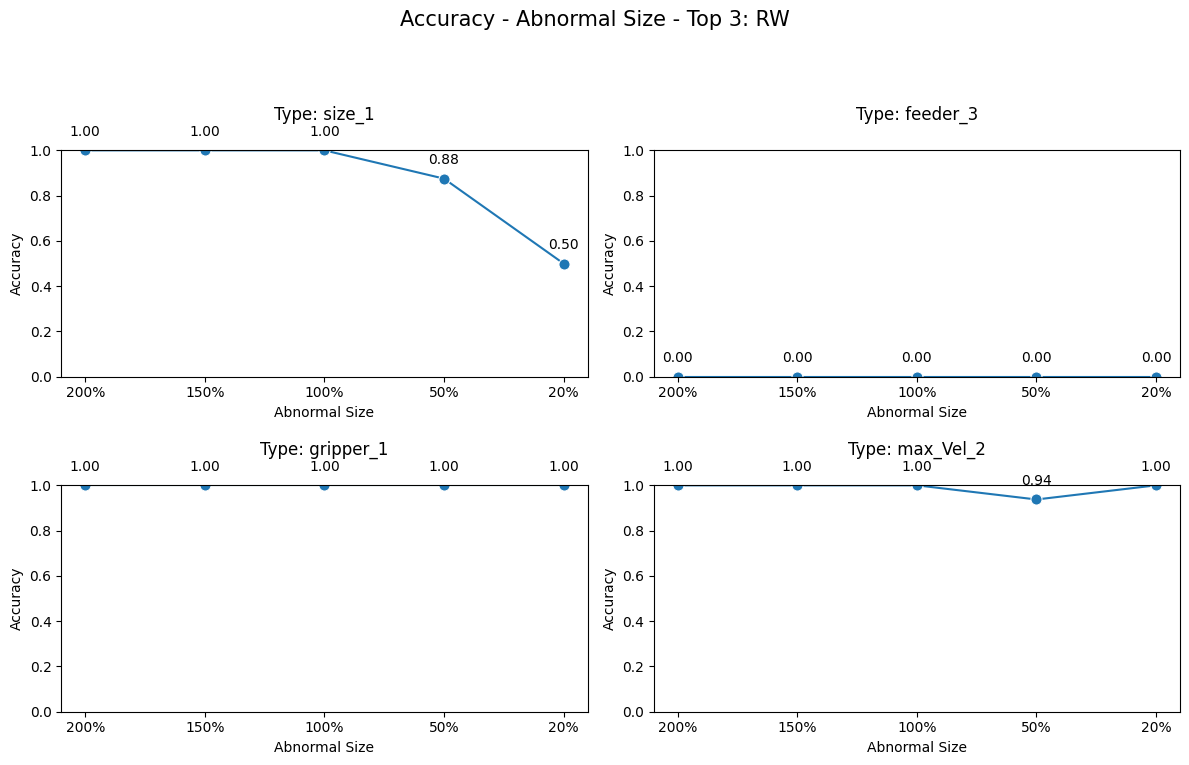

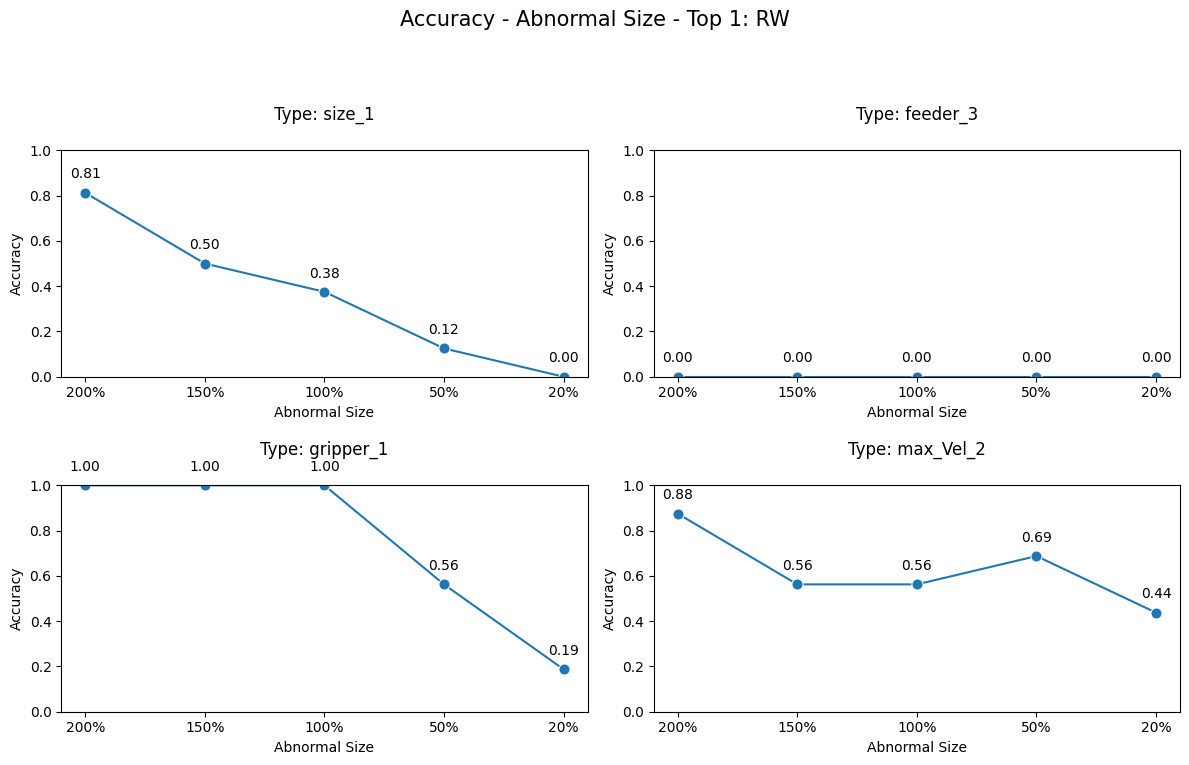

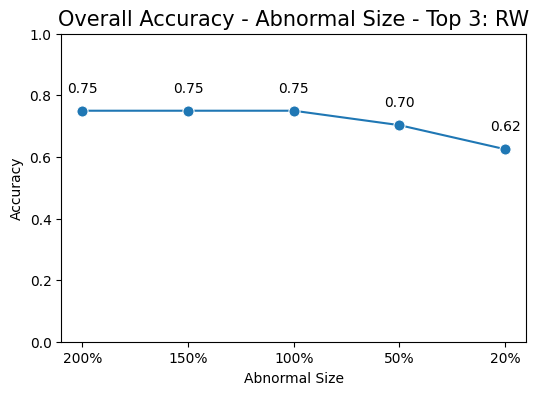

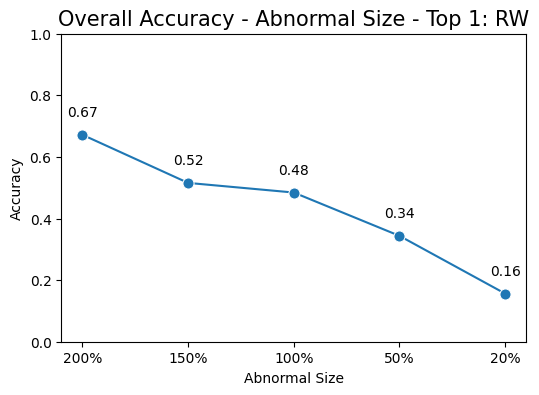

In [911]:
algo='RW'
var='Abnormal Size'
var_save='abnormal_size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### RCD - Algorithm

In [912]:
result_RCD_abnormal_size_1, runtime_RCD_abnormal_size_1 = run_RCD_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=2.00,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_abnormal_size_2, runtime_RCD_abnormal_size_2 = run_RCD_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_abnormal_size_3, runtime_RCD_abnormal_size_3 = run_RCD_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_abnormal_size_4, runtime_RCD_abnormal_size_4 = run_RCD_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_abnormal_size_5, runtime_RCD_abnormal_size_5 = run_RCD_abnormal_size(folder_path,files,startrow=950,abnormal_size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)


In [913]:
result_abnormal_size_RCD = pd.DataFrame()
result_abnormal_size_RCD = pd.concat([result_RCD_abnormal_size_1,result_RCD_abnormal_size_2,result_RCD_abnormal_size_3,result_RCD_abnormal_size_4,result_RCD_abnormal_size_5], ignore_index=True)
result_abnormal_size_RCD['abnormal Size Percent'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
result_abnormal_size_RCD.set_index('abnormal Size Percent', inplace=True)

In [914]:
runtime_abnormal_size_RCD = pd.DataFrame()
runtime_abnormal_size_RCD = pd.concat([runtime_RCD_abnormal_size_1.T,runtime_RCD_abnormal_size_2.T,runtime_RCD_abnormal_size_3.T,runtime_RCD_abnormal_size_4.T,runtime_RCD_abnormal_size_5.T], ignore_index=True)
runtime_abnormal_size_RCD['abnormal Size Percent'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
runtime_abnormal_size_RCD.set_index('abnormal Size Percent', inplace=True)

In [915]:
result_data_3top = results_top_3(result_abnormal_size_RCD,abnormal_sets)
result_data_1top = results_top_1(result_abnormal_size_RCD,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_3_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_3_RCD.csv'))

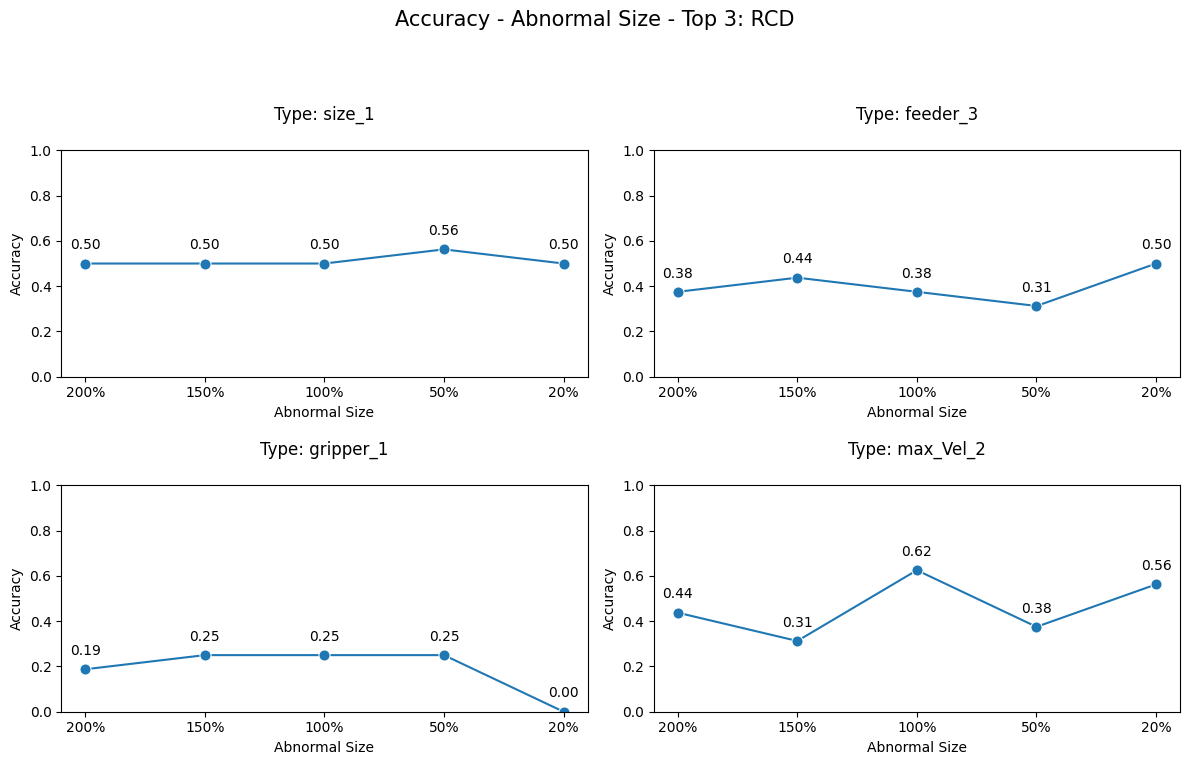

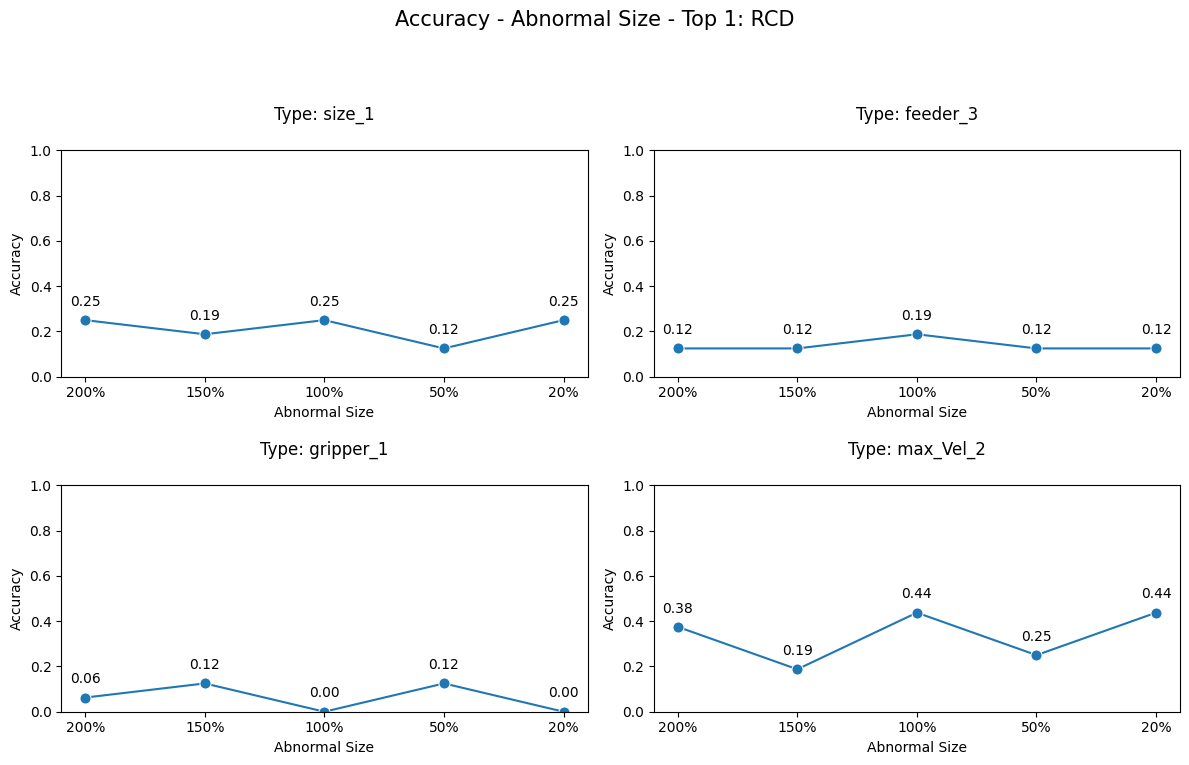

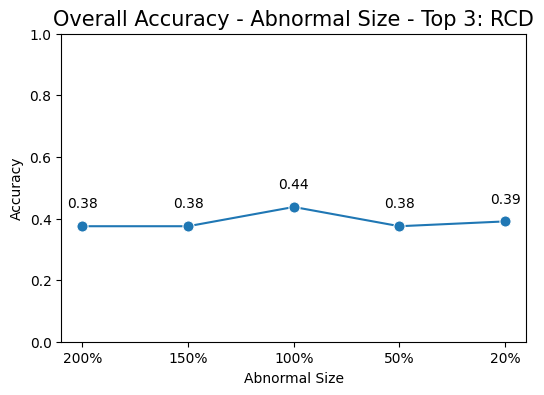

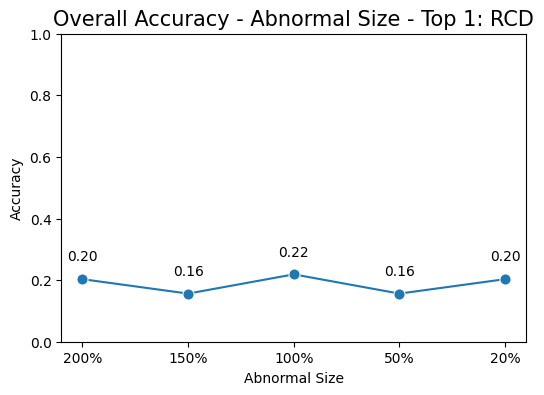

In [916]:
algo='RCD'
var='Abnormal Size'
var_save='abnormal_size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### All together

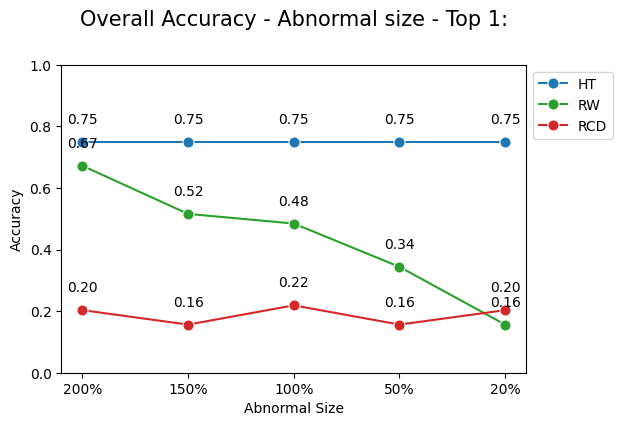

In [917]:
result1 = results_top_1(result_abnormal_size_HT,abnormal_sets)
result2 = results_top_1(result_abnormal_size_RW,abnormal_sets)
result3 = results_top_1(result_abnormal_size_RCD,abnormal_sets)

results_dfs = [result1,result2,result3]
plot_avg_var_total_combined(results_dfs,['HT','RW','RCD'] ,directory_figures_path,'1top_abnormal_size_total','Abnormal Size','Overall Accuracy - Abnormal size - Top 1:')

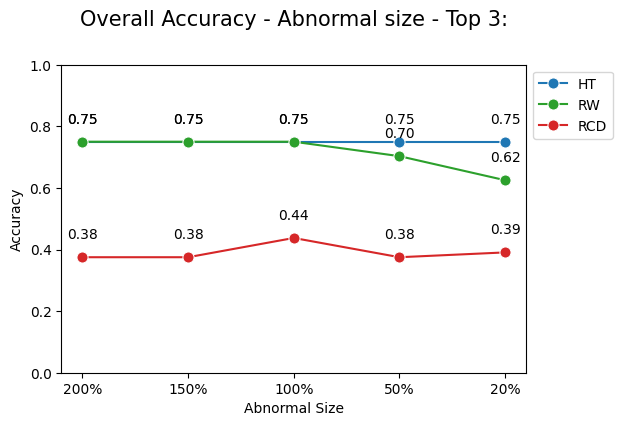

In [918]:
result1 = results_top_3(result_abnormal_size_HT,abnormal_sets)
result2 = results_top_3(result_abnormal_size_RW,abnormal_sets)
result3 = results_top_3(result_abnormal_size_RCD,abnormal_sets)

results_dfs = [result1,result2,result3]
plot_avg_var_total_combined(results_dfs,['HT','RW','RCD'] ,directory_figures_path,'3top_abnormal_size_total','Abnormal Size','Overall Accuracy - Abnormal size - Top 3:')

## Variation 4 - Causal Graph, adjacency matrix

Only the HT- and RW-Algorithm use an adjacency matrix for training of each model.

### HT - Algorithm

In [919]:
result_HT_edges_1, runtime_HT_edges_1  = run_HT_edges_delete(folder_path,files,startrow=950,edges_delete_n=20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_edges_2, runtime_HT_edges_2 = run_HT_edges_delete(folder_path,files,startrow=950,edges_delete_n=40,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_edges_3, runtime_HT_edges_3 = run_HT_edges_delete(folder_path,files,startrow=950,edges_delete_n=60,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_edges_4, runtime_HT_edges_4 = run_HT_edges_delete(folder_path,files,startrow=950,edges_delete_n=80,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_edges_5, runtime_HT_edges_5 = run_HT_edges_delete(folder_path,files,startrow=950,edges_delete_n=100,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [920]:
result_edges_HT = pd.DataFrame()
result_edges_HT = pd.concat([result_HT_edges_1,result_HT_edges_2,result_HT_edges_3,result_HT_edges_4,result_HT_edges_5], ignore_index=True)
result_edges_HT['Edges Missing'] = pd.DataFrame({'HT':['Edges-20','Edges-40','Edges-60','Edges-80','Edges-100']})
result_edges_HT.set_index('Edges Missing', inplace=True)

In [921]:
runtime_edges_HT = pd.DataFrame()
runtime_edges_HT = pd.concat([runtime_HT_edges_1.T,runtime_HT_edges_2.T,runtime_HT_edges_3.T,runtime_HT_edges_4.T,runtime_HT_edges_5.T], ignore_index=True)
runtime_edges_HT['Edges Missing'] = pd.DataFrame({'HT':['Edges-20','Edges-40','Edges-60','Edges-80','Edges-100']})
runtime_edges_HT.set_index('Edges Missing', inplace=True)


In [922]:
result_data_3top = results_top_3(result_edges_HT,abnormal_sets)
result_data_1top = results_top_1(result_edges_HT,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_4_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_4_HT.csv'))

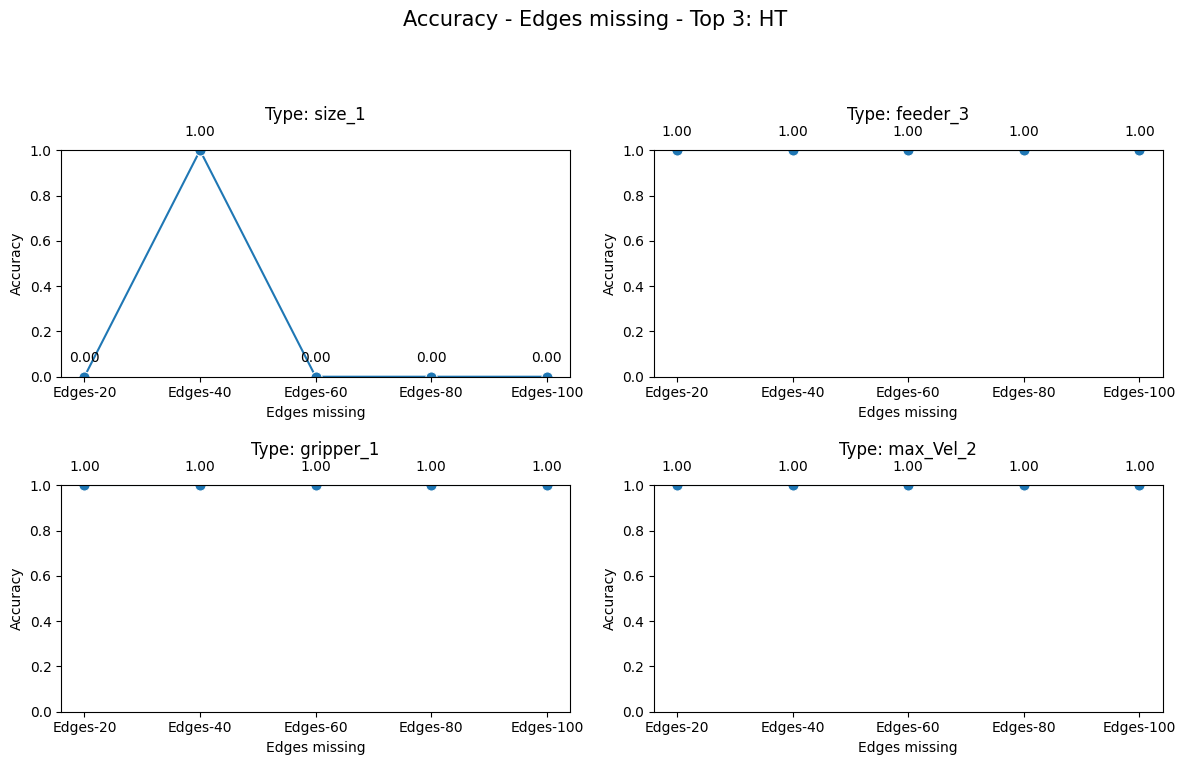

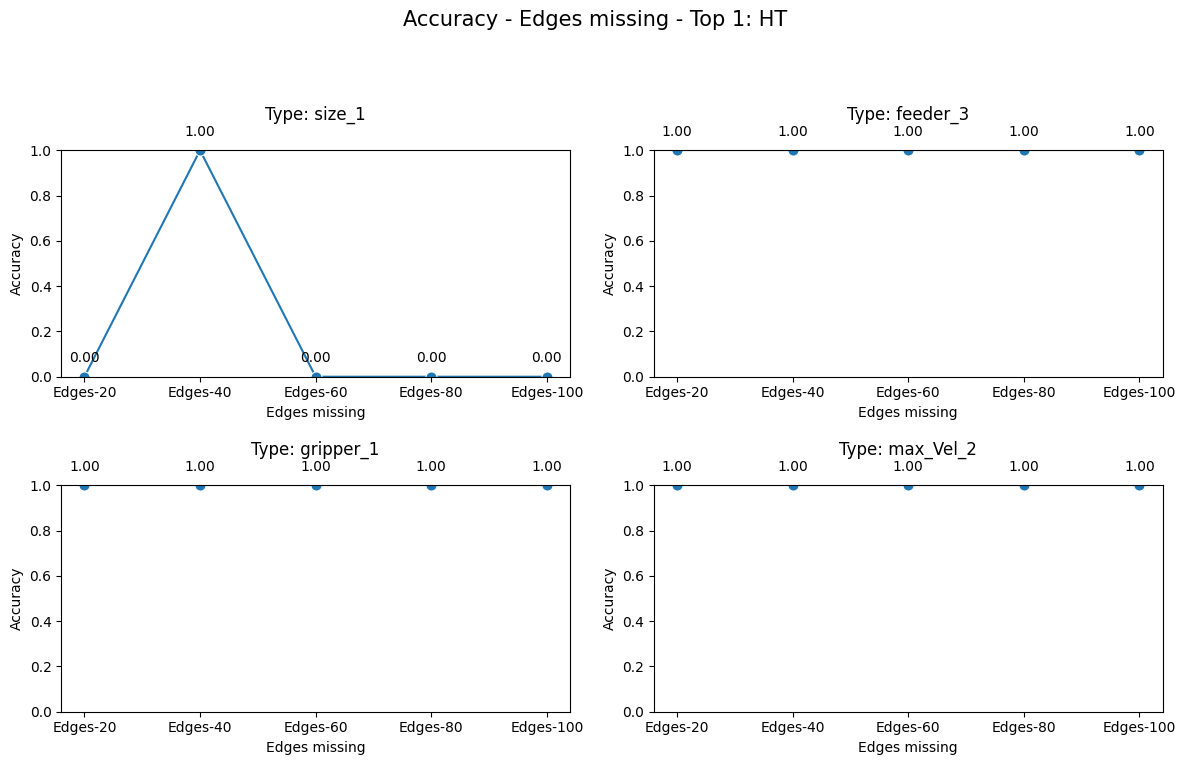

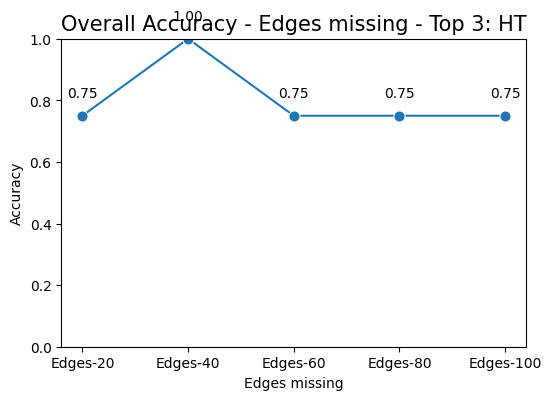

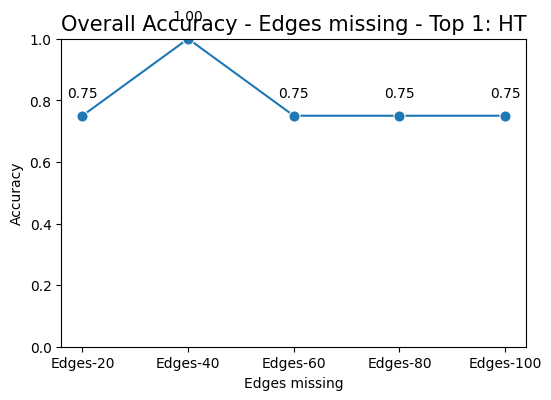

In [923]:
algo='HT'
var='Edges missing'
var_save='graph'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### RW - Algorithm

In [924]:
result_RW_edges_1, runtime_RW_edges_1 = run_RW_edges_delete(folder_path,files,startrow=950,edges_delete_n=20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_edges_2, runtime_RW_edges_2 = run_RW_edges_delete(folder_path,files,startrow=950,edges_delete_n=40,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_edges_3, runtime_RW_edges_3 = run_RW_edges_delete(folder_path,files,startrow=950,edges_delete_n=60,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_edges_4, runtime_RW_edges_4 = run_RW_edges_delete(folder_path,files,startrow=950,edges_delete_n=80,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_edges_5, runtime_RW_edges_5 = run_RW_edges_delete(folder_path,files,startrow=950,edges_delete_n=100,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [925]:
result_edges_RW = pd.DataFrame()
result_edges_RW = pd.concat([result_RW_edges_1,result_RW_edges_2,result_RW_edges_3,result_RW_edges_4,result_RW_edges_5], ignore_index=True)
result_edges_RW['Edges Missing'] = pd.DataFrame({'RW':['Edges-20','Edges-40','Edges-60','Edges-80','Edges-100']})
result_edges_RW.set_index('Edges Missing', inplace=True)

In [926]:
runtime_edges_RW = pd.DataFrame()
runtime_edges_RW = pd.concat([runtime_RW_edges_1.T,runtime_RW_edges_2.T,runtime_RW_edges_3.T,runtime_RW_edges_4.T,runtime_RW_edges_5.T], ignore_index=True)
runtime_edges_RW['Edges Missing'] = pd.DataFrame({'RW':['Edges-20','Edges-40','Edges-60','Edges-80','Edges-100']})
runtime_edges_RW.set_index('Edges Missing', inplace=True)

In [927]:
result_data_3top = results_top_3(result_edges_RW,abnormal_sets)
result_data_1top = results_top_1(result_edges_RW,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_4_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_4_RW.csv'))

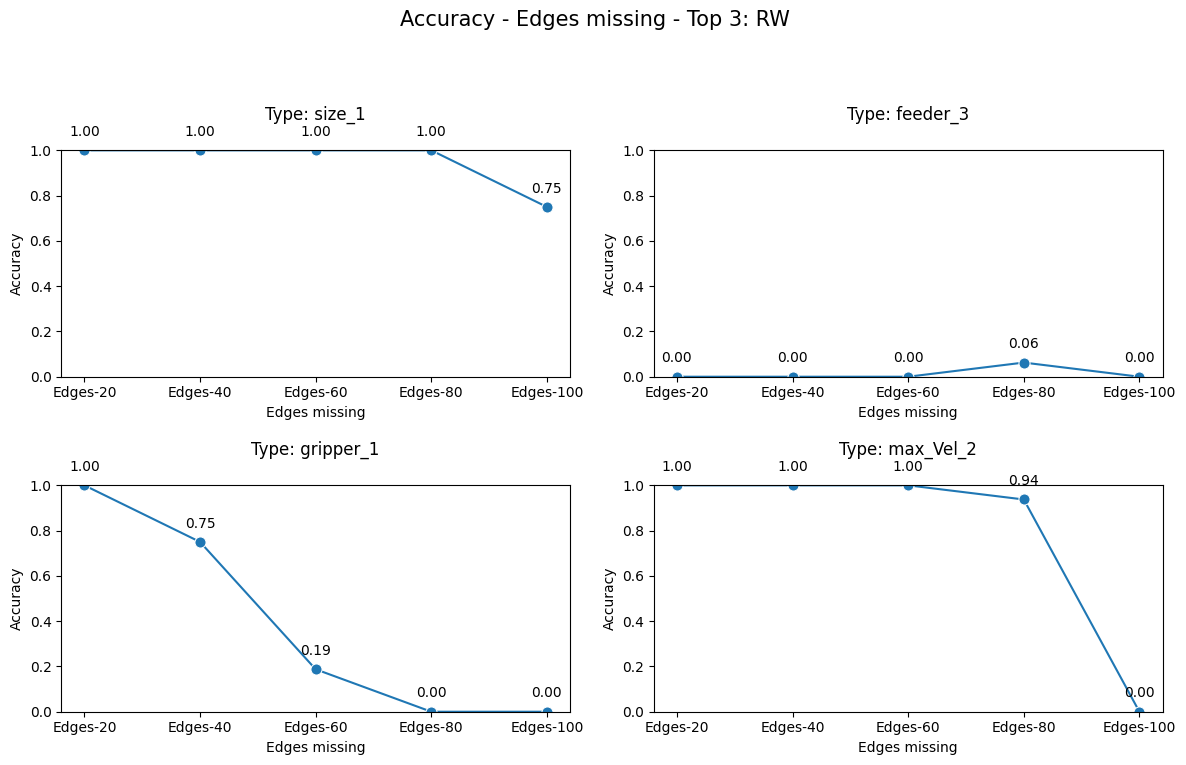

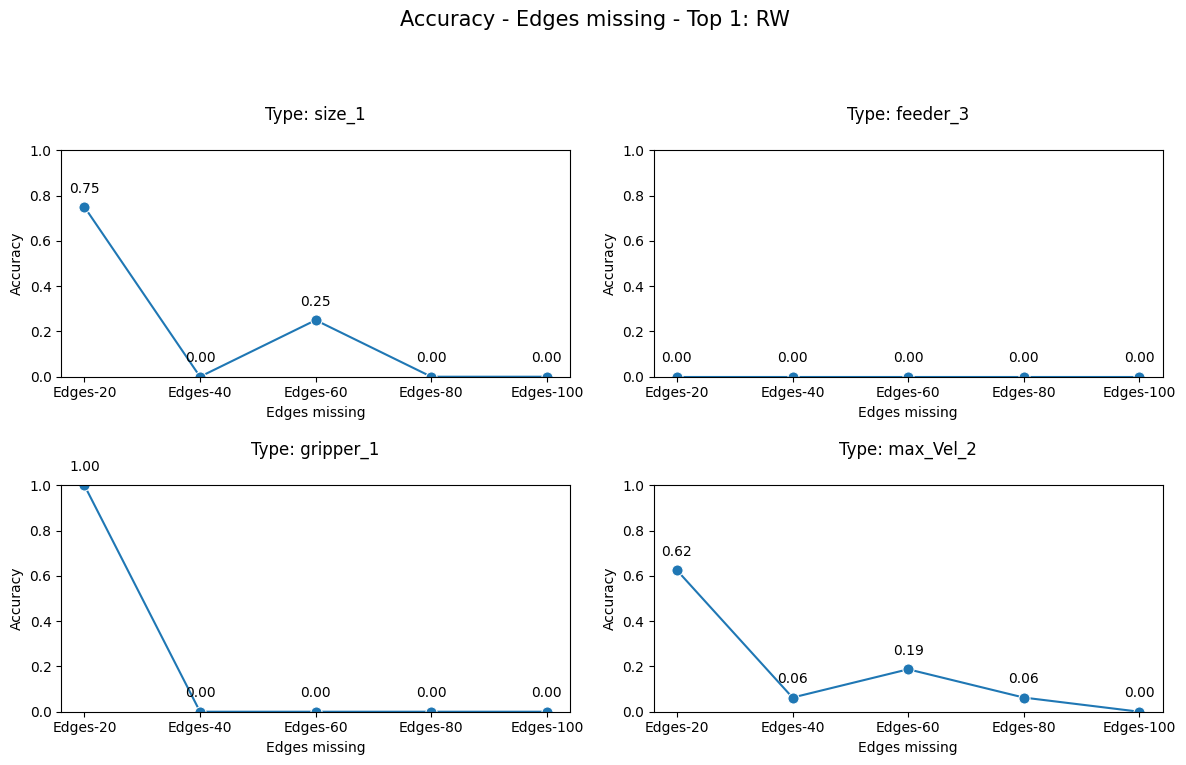

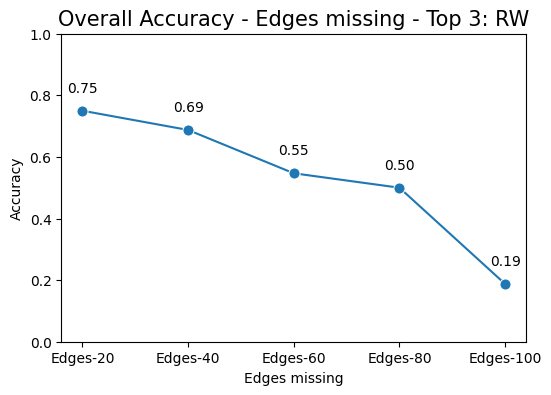

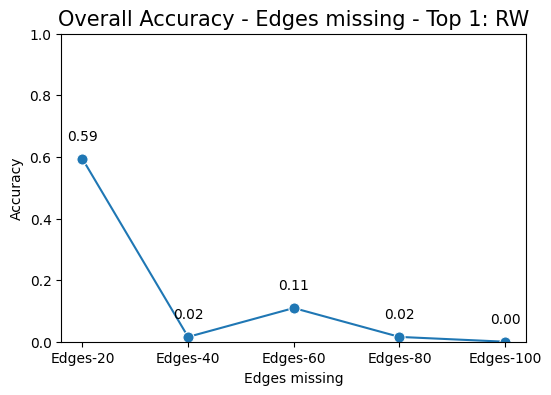

In [928]:
algo='RW'
var='Edges missing'
var_save='graph'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### All together

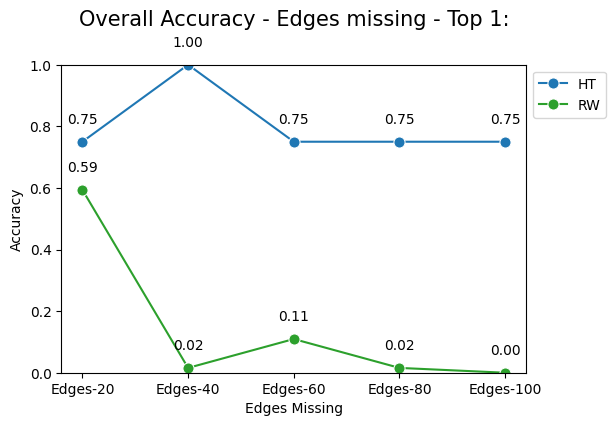

In [929]:
result1 = results_top_1(result_edges_HT,abnormal_sets)
result2 = results_top_1(result_edges_RW,abnormal_sets)

results_dfs = [result1,result2]
plot_avg_var_total_combined(results_dfs,['HT','RW'] ,directory_figures_path,'1top_edges_total','Edges Missing','Overall Accuracy - Edges missing - Top 1:')

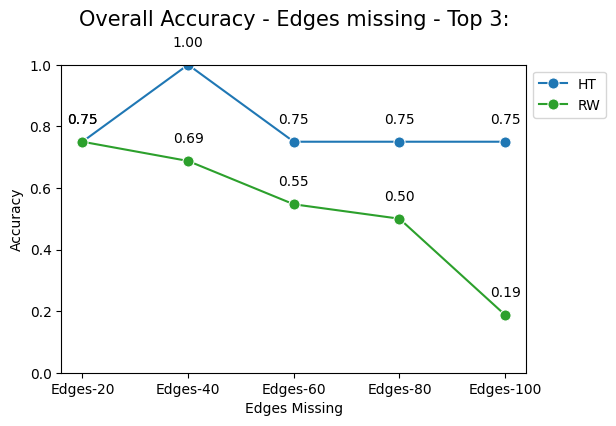

In [930]:
result1 = results_top_3(result_edges_HT,abnormal_sets)
result2 = results_top_3(result_edges_RW,abnormal_sets)

results_dfs = [result1,result2]
plot_avg_var_total_combined(results_dfs,['HT','RW'] ,directory_figures_path,'3top_edges_total','Edges Missing','Overall Accuracy - Edges missing - Top 3:')

## Variation 5 - Size

### HT -Algorithm

In [931]:
result_HT_size_1, runtime_HT_size_1 = run_HT_size(folder_path,files,startrow=950,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_size_2, runtime_HT_size_2 = run_HT_size(folder_path,files,startrow=950,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_size_3, runtime_HT_size_3 = run_HT_size(folder_path,files,startrow=950,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_size_4, runtime_HT_size_4 = run_HT_size(folder_path,files,startrow=950,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_size_5, runtime_HT_size_5 = run_HT_size(folder_path,files,startrow=950,size_p=0.2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [932]:
result_size_HT = pd.DataFrame()
result_size_HT = pd.concat([result_HT_size_1,result_HT_size_2,result_HT_size_3,result_HT_size_4,result_HT_size_5], ignore_index=True)
result_size_HT['Data Size'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
result_size_HT.set_index('Data Size', inplace=True)

In [933]:
runtime_size_HT = pd.DataFrame()
runtime_size_HT = pd.concat([runtime_HT_size_1.T,runtime_HT_size_2.T,runtime_HT_size_3.T,runtime_HT_size_4.T,runtime_HT_size_5.T], ignore_index=True)
runtime_size_HT['Data Size'] = pd.DataFrame({'HT':['200%','150%','100%','50%','20%']})
runtime_size_HT.set_index('Data Size', inplace=True)

In [934]:
result_data_3top = results_top_3(result_size_HT,abnormal_sets)
result_data_1top = results_top_1(result_size_HT,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_HT.csv'))

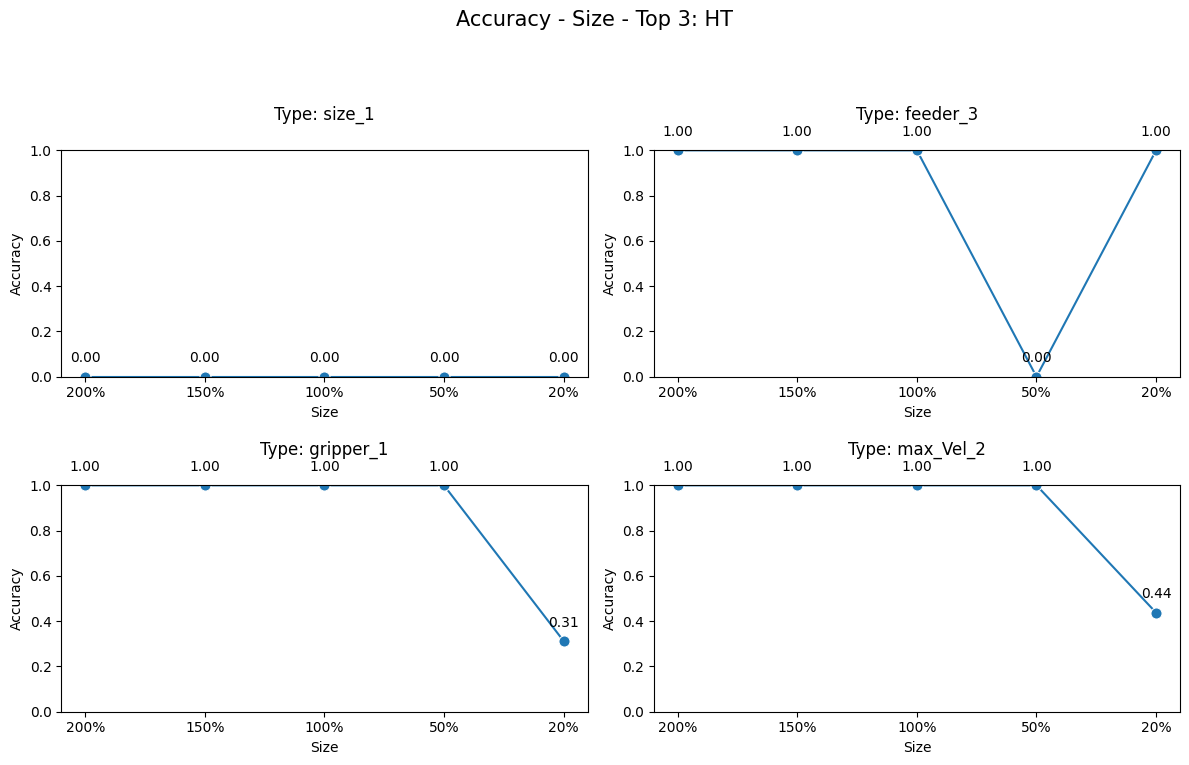

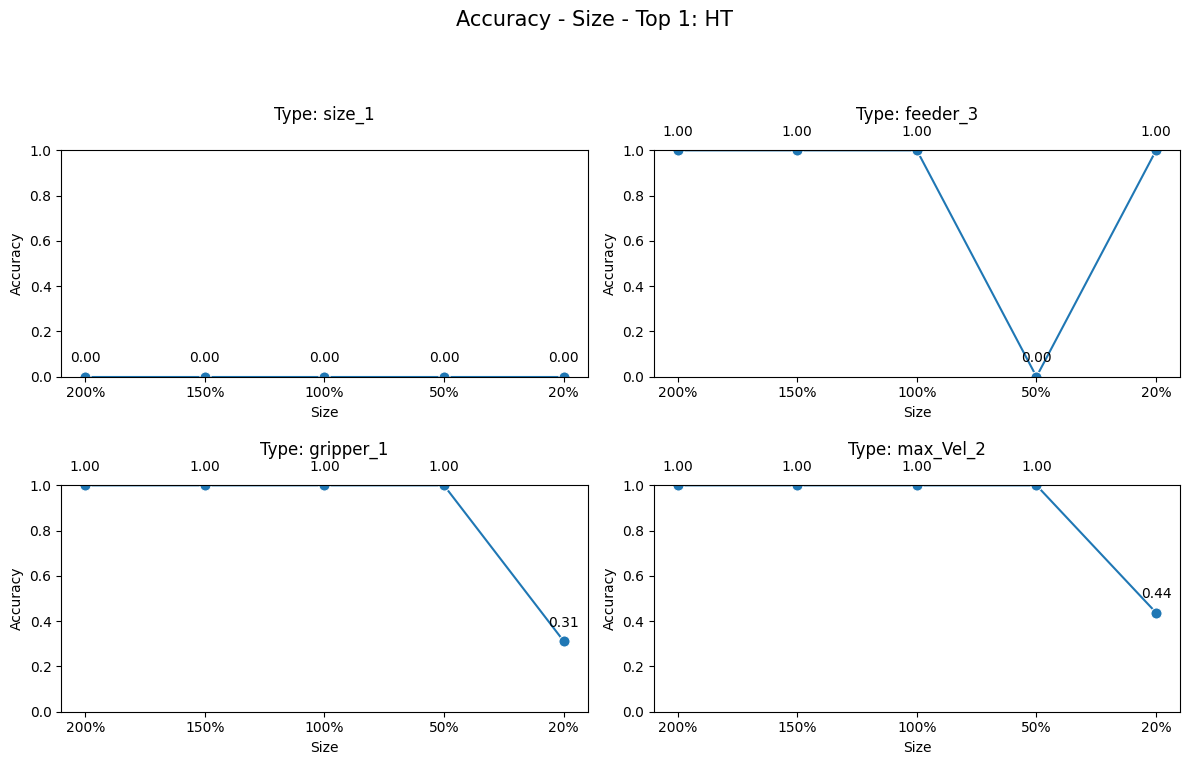

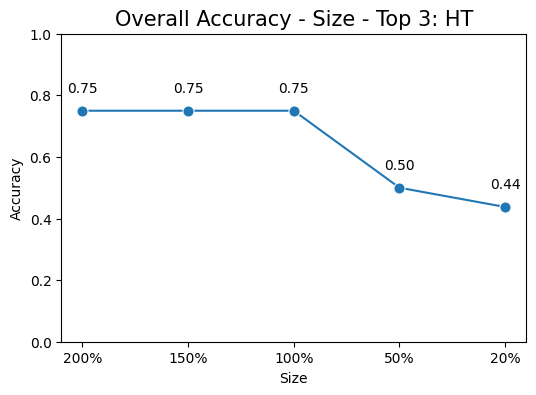

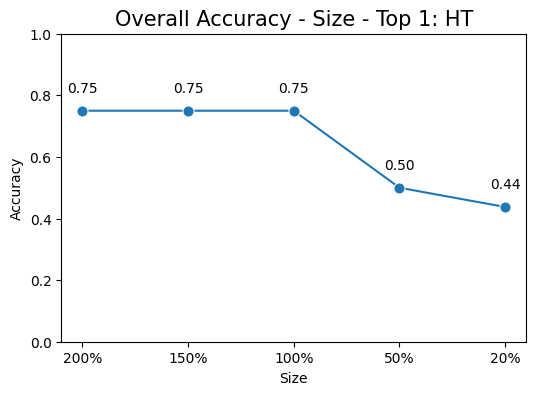

In [935]:
algo='HT'
var='Size'
var_save='size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### ED - Algorithm

In [937]:
result_ED_size_1, runtime_ED_size_1 = run_ED_size(folder_path,files,startrow=950,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_size_2, runtime_ED_size_2 = run_ED_size(folder_path,files,startrow=950,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_size_3, runtime_ED_size_3 = run_ED_size(folder_path,files,startrow=950,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_size_4, runtime_ED_size_4 = run_ED_size(folder_path,files,startrow=950,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_size_5, runtime_ED_size_5 = run_ED_size(folder_path,files,startrow=950,size_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [938]:
result_size_ED = pd.DataFrame()
result_size_ED = pd.concat([result_ED_size_1,result_ED_size_2,result_ED_size_3,result_ED_size_4,result_ED_size_5], ignore_index=True)
result_size_ED['Data Size'] = pd.DataFrame({'ED':['200%','150%','100%','50%','20%']})
result_size_ED.set_index('Data Size', inplace=True)

In [939]:
runtime_size_ED = pd.DataFrame()
runtime_size_ED = pd.concat([runtime_ED_size_1.T,runtime_ED_size_2.T,runtime_ED_size_3.T,runtime_ED_size_4.T,runtime_ED_size_5.T], ignore_index=True)
runtime_size_ED['Data Size'] = pd.DataFrame({'ED':['200%','150%','100%','50%','20%']})
runtime_size_ED.set_index('Data Size', inplace=True)

In [940]:
result_data_3top = results_top_3(result_size_ED,abnormal_sets)
result_data_1top = results_top_1(result_size_ED,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_ED.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_ED.csv'))

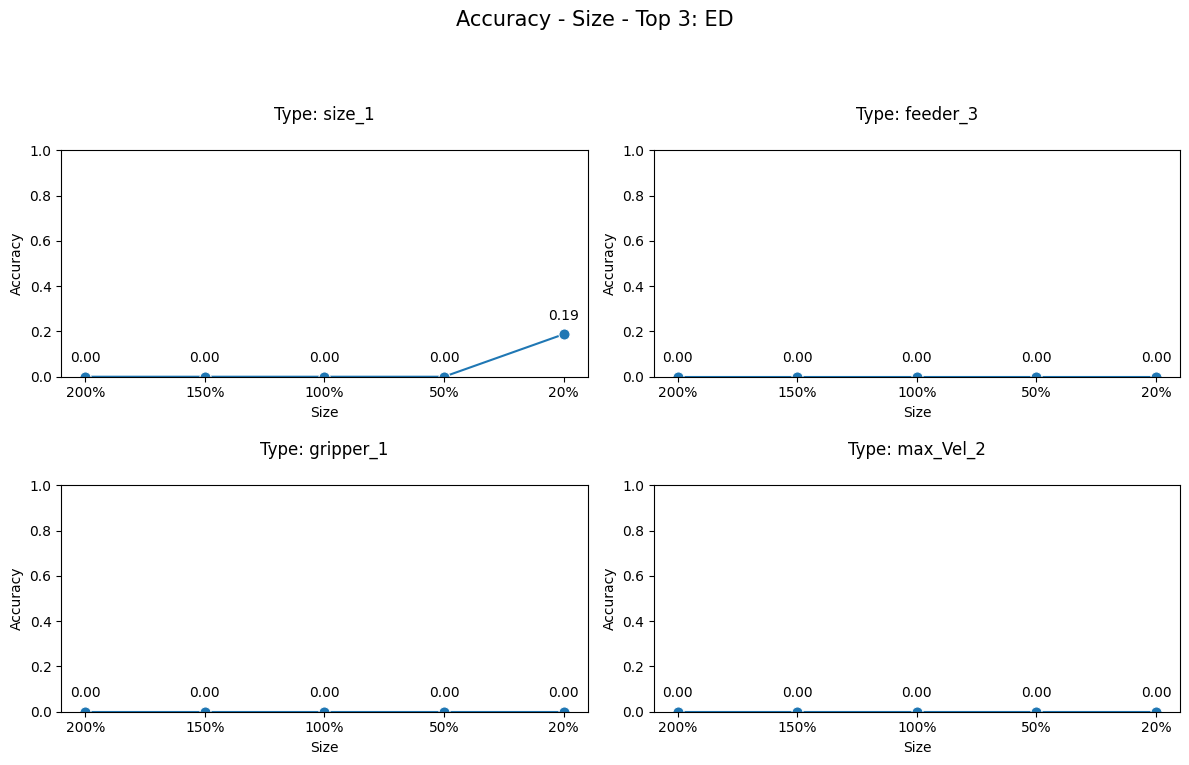

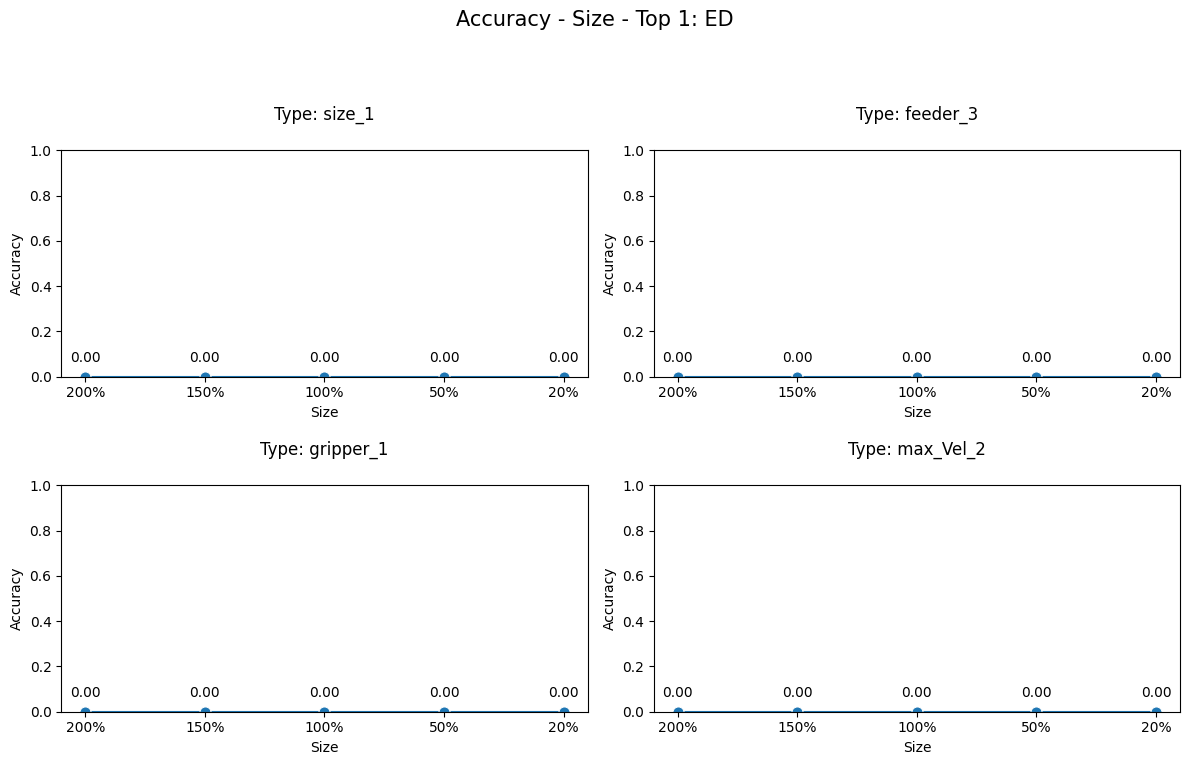

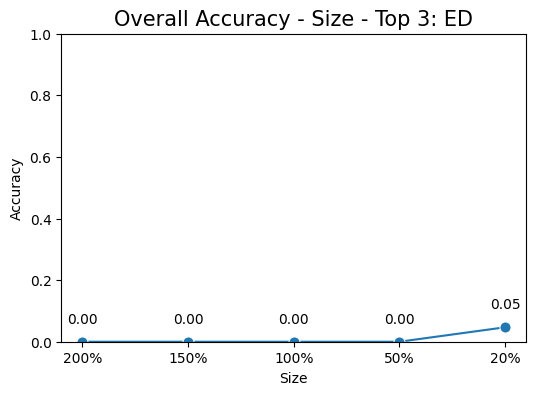

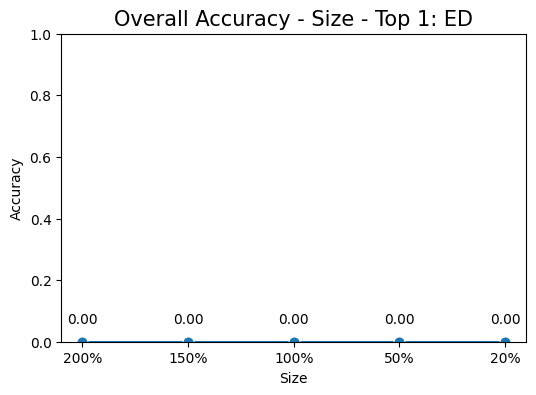

In [941]:
algo='ED'
var='Size'
var_save='size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### RW - Algorithm

In [942]:
result_RW_size_1, runtime_RW_size_1 = run_RW_size(folder_path,files,startrow=950,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_size_2, runtime_RW_size_2 = run_RW_size(folder_path,files,startrow=950,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_size_3, runtime_RW_size_3 = run_RW_size(folder_path,files,startrow=950,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_size_4, runtime_RW_size_4 = run_RW_size(folder_path,files,startrow=950,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_size_5, runtime_RW_size_5 = run_RW_size(folder_path,files,startrow=950,size_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [943]:
result_size_RW = pd.DataFrame()
result_size_RW = pd.concat([result_RW_size_1,result_RW_size_2,result_RW_size_3,result_RW_size_4,result_RW_size_5], ignore_index=True)
result_size_RW['Data Size'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
result_size_RW.set_index('Data Size', inplace=True)

In [944]:
runtime_size_RW = pd.DataFrame()
runtime_size_RW = pd.concat([runtime_RW_size_1.T,runtime_RW_size_2.T,runtime_RW_size_3.T,runtime_RW_size_4.T,runtime_RW_size_5.T], ignore_index=True)
runtime_size_RW['Data Size'] = pd.DataFrame({'RW':['200%','150%','100%','50%','20%']})
runtime_size_RW.set_index('Data Size', inplace=True)

In [945]:
result_data_3top = results_top_3(result_size_RW,abnormal_sets)
result_data_1top = results_top_1(result_size_RW,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_RW.csv'))

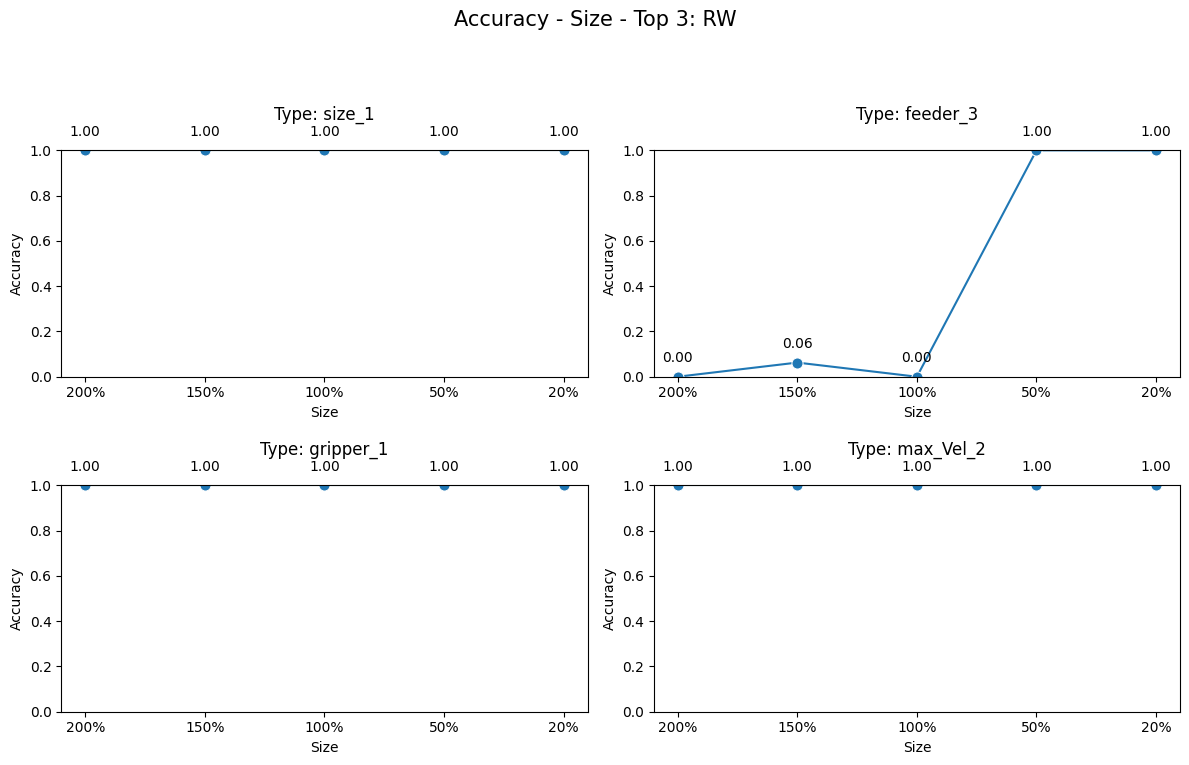

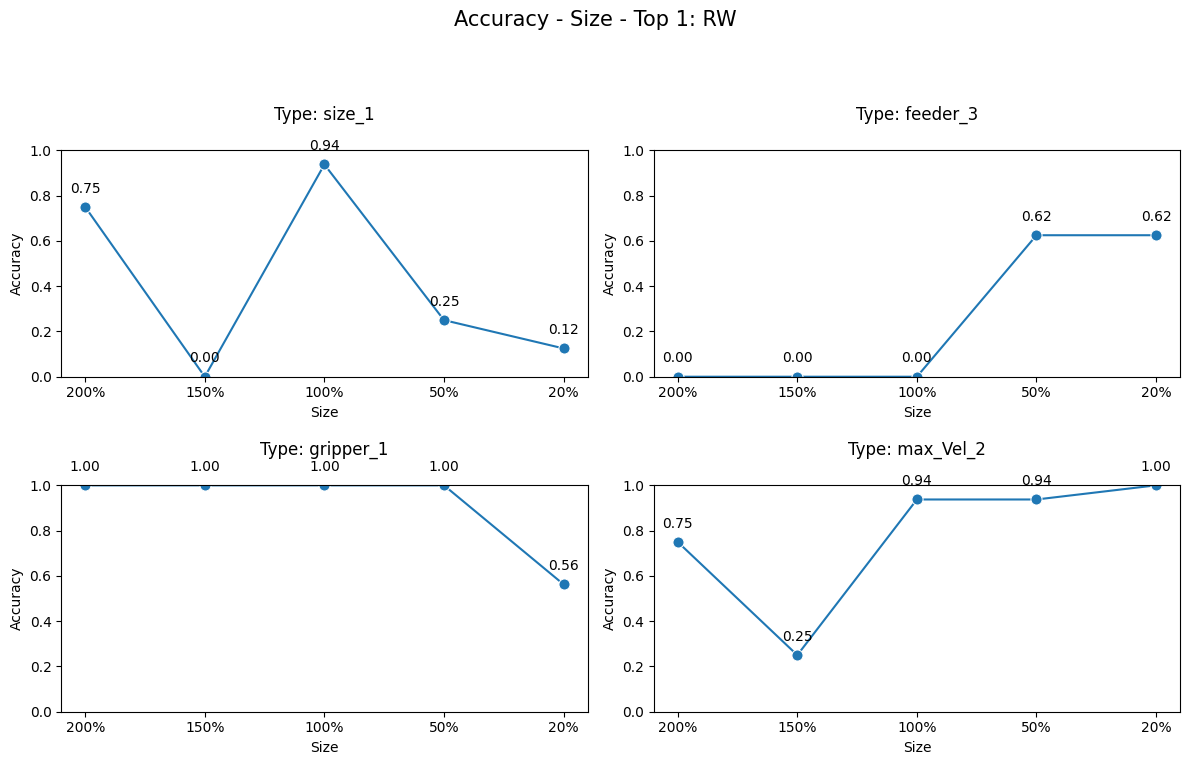

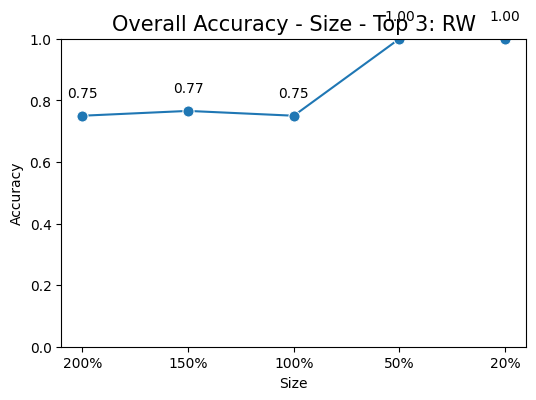

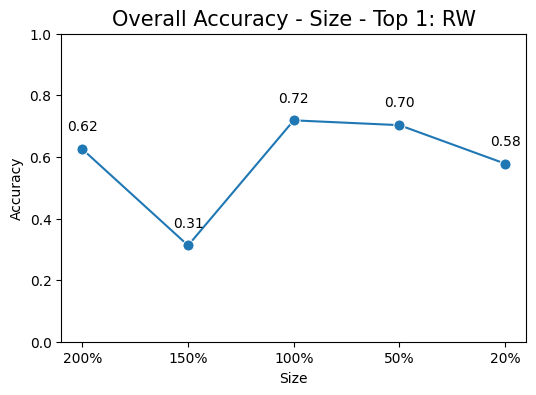

In [946]:
algo='RW'
var='Size'
var_save='size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### RCD - Algorithm

In [947]:
result_RCD_size_1, runtime_RCD_size_1 = run_RCD_size(folder_path,files,startrow=950,size_p=2,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_size_2, runtime_RCD_size_2 = run_RCD_size(folder_path,files,startrow=950,size_p=1.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_size_3, runtime_RCD_size_3 = run_RCD_size(folder_path,files,startrow=950,size_p=1.0,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_size_4, runtime_RCD_size_4 = run_RCD_size(folder_path,files,startrow=950,size_p=0.5,nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_size_5, runtime_RCD_size_5 = run_RCD_size(folder_path,files,startrow=950,size_p=0.20,nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [948]:
result_size_RCD = pd.DataFrame()
result_size_RCD = pd.concat([result_RCD_size_1,result_RCD_size_2,result_RCD_size_3,result_RCD_size_4,result_RCD_size_5], ignore_index=True)
result_size_RCD['Data Size'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
result_size_RCD.set_index('Data Size', inplace=True)

In [949]:
runtime_size_RCD = pd.DataFrame()
runtime_size_RCD = pd.concat([runtime_RCD_size_1.T,runtime_RCD_size_2.T,runtime_RCD_size_3.T,runtime_RCD_size_4.T,runtime_RCD_size_5.T], ignore_index=True)
runtime_size_RCD['Data Size'] = pd.DataFrame({'RCD':['200%','150%','100%','50%','20%']})
runtime_size_RCD.set_index('Data Size', inplace=True)

In [950]:
result_data_3top = results_top_3(result_size_RCD,abnormal_sets)
result_data_1top = results_top_1(result_size_RCD,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_5_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_5_RCD.csv'))

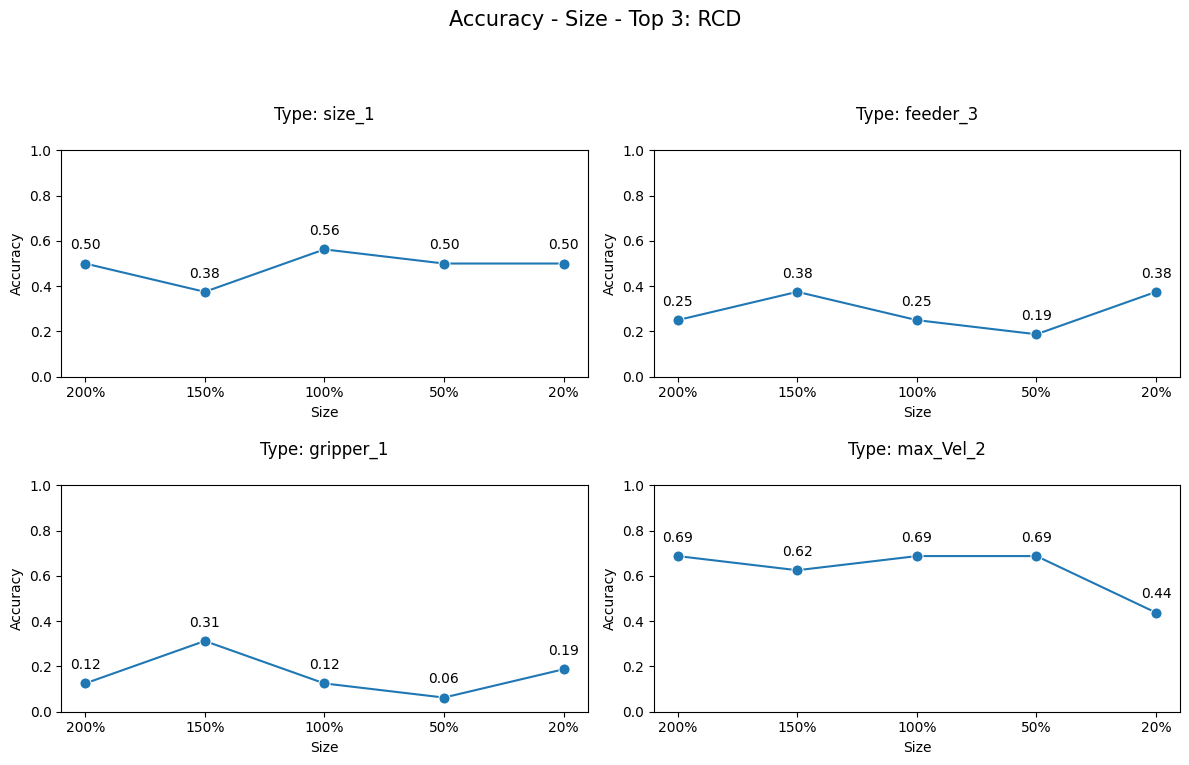

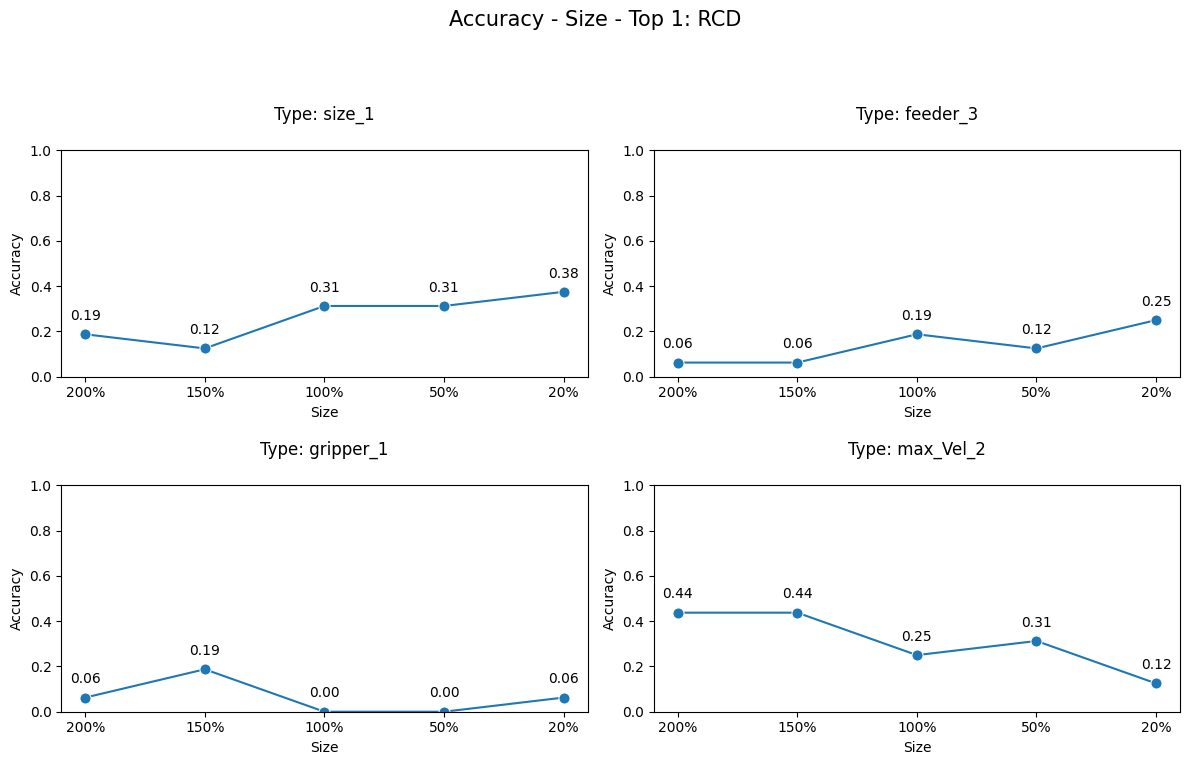

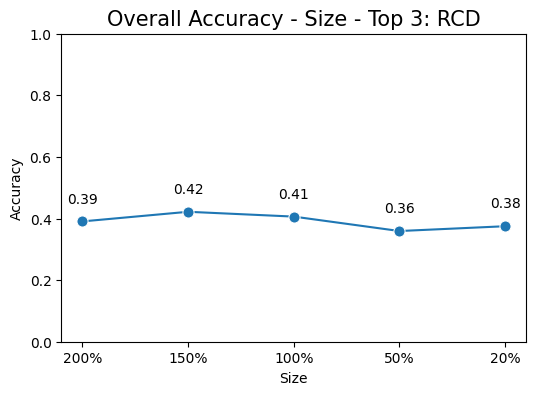

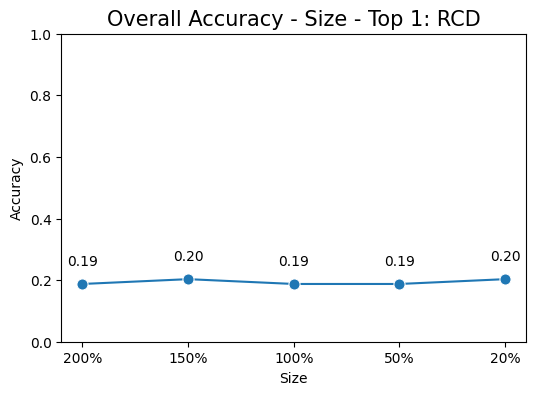

In [951]:
algo='RCD'
var='Size'
var_save='size'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

### All together

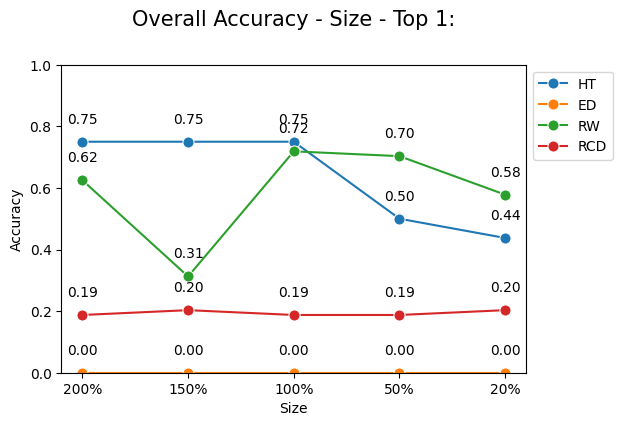

In [952]:
result1 = results_top_1(result_size_HT,abnormal_sets)
result2 = results_top_1(result_size_ED,abnormal_sets)
result3 = results_top_1(result_size_RW,abnormal_sets)
result4 = results_top_1(result_size_RCD,abnormal_sets)

results_dfs = [result1,result2,result3,result4]
plot_avg_var_total_combined(results_dfs,['HT','ED','RW','RCD'] ,directory_figures_path,'1top_size_total','Size','Overall Accuracy - Size - Top 1:')

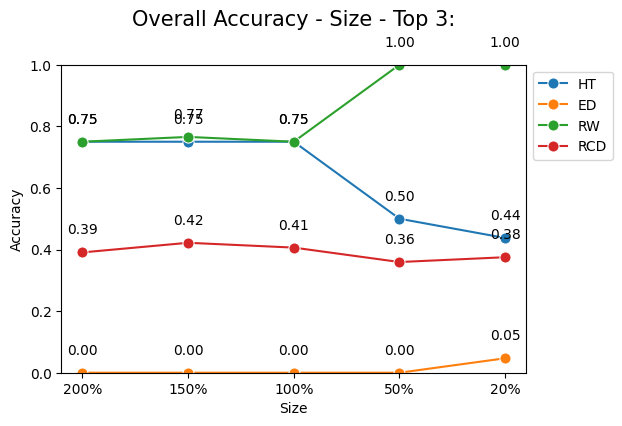

In [953]:
result1 = results_top_3(result_size_HT,abnormal_sets)
result2 = results_top_3(result_size_ED,abnormal_sets)
result3 = results_top_3(result_size_RW,abnormal_sets)
result4 = results_top_3(result_size_RCD,abnormal_sets)

results_dfs = [result1,result2,result3,result4]
plot_avg_var_total_combined(results_dfs,['HT','ED','RW','RCD'] ,directory_figures_path,'3top_size_total','Size','Overall Accuracy - Size - Top 3:')

## Variation 6 - Training Data

### HT - Algorithm

In [954]:
result_HT_data_1, runtime_HT_data_1 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-1',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_data_2, runtime_HT_data_2 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-2',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_data_3, runtime_HT_data_3 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-3',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_data_4, runtime_HT_data_4 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-4',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_data_5, runtime_HT_data_5 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-5',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_data_6, runtime_HT_data_6 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-6',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_data_7, runtime_HT_data_7 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-7',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_HT_data_8, runtime_HT_data_8 = run_HT_normal_data(folder_path,files,startrow=950,normal_data='normal-8',nodes=nodes,edges_list=edges,key_nodes=check_nodes)


In [955]:
result_data_HT = pd.DataFrame()
result_data_HT = pd.concat([result_HT_data_1,result_HT_data_2,result_HT_data_3,result_HT_data_4,result_HT_data_5,result_HT_data_6,result_HT_data_7,result_HT_data_8], ignore_index=True)
result_data_HT['Normal Data'] = pd.DataFrame({'HT':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
result_data_HT.set_index('Normal Data', inplace=True)

In [956]:
runtime_data_HT = pd.DataFrame()
runtime_data_HT = pd.concat([runtime_HT_data_1.T,runtime_HT_data_2.T,runtime_HT_data_3.T,runtime_HT_data_4.T,runtime_HT_data_5.T,runtime_HT_data_6.T,runtime_HT_data_7.T,runtime_HT_data_8.T], ignore_index=True)
runtime_data_HT['Normal Data'] = pd.DataFrame({'HT':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
runtime_data_HT.set_index('Normal Data', inplace=True)

In [957]:
result_data_3top = results_top_3(result_data_HT,abnormal_sets)
result_data_1top = results_top_1(result_data_HT,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_6_HT.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_6_HT.csv'))

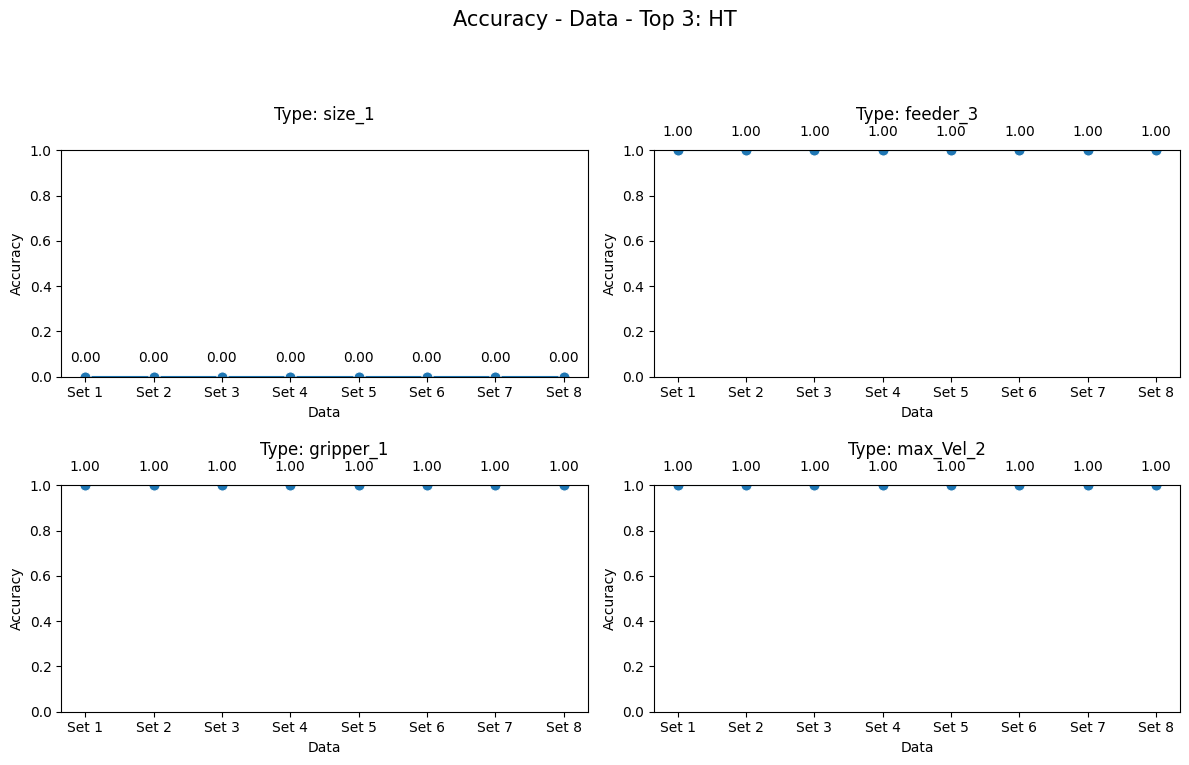

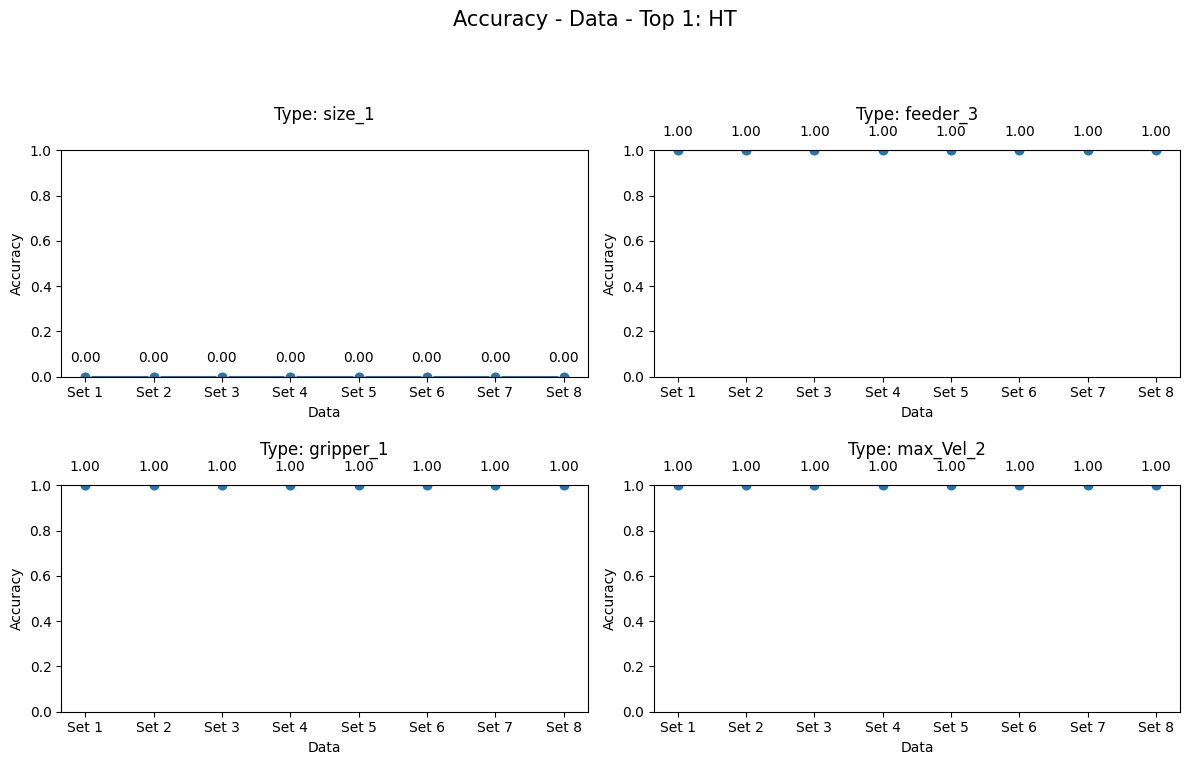

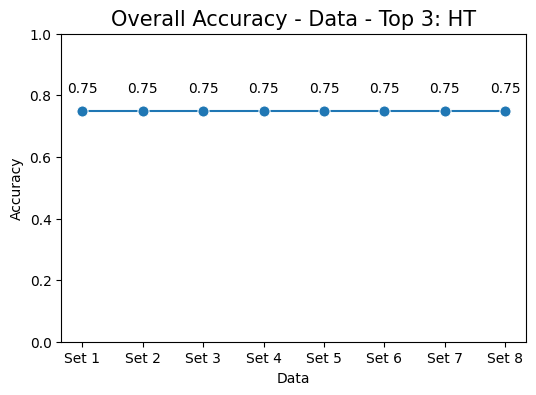

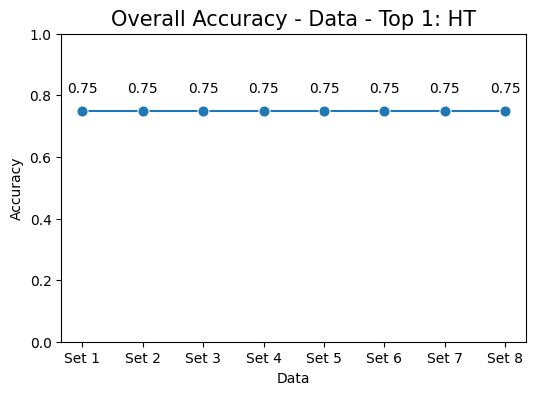

In [958]:
algo='HT'
var='Data'
var_save='data'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

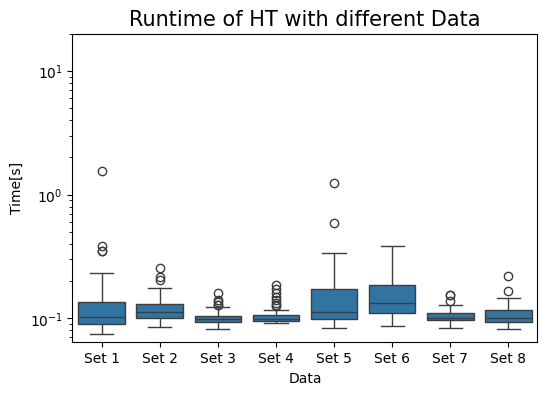

In [959]:
plot_data_runtime(runtime_data_HT.T,directory_figures_path,'runtime_data_6_HT.csv','Data',' HT ')

### ED - Algorithm

In [960]:
result_ED_data_1, runtime_ED_data_1 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-1',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_data_2, runtime_ED_data_2 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-2',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_data_3, runtime_ED_data_3 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-3',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_data_4, runtime_ED_data_4 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-4',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_data_5, runtime_ED_data_5 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-5',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_data_6, runtime_ED_data_6 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-6',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_data_7, runtime_ED_data_7 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-7',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_ED_data_8, runtime_ED_data_8 = run_ED_normal_data(folder_path,files,startrow=950,normal_data='normal-8',nodes=nodes,edges_list=edges,key_nodes=check_nodes)


In [961]:
result_data_ED = pd.DataFrame()
result_data_ED = pd.concat([result_ED_data_1,result_ED_data_2,result_ED_data_3,result_ED_data_4,result_ED_data_5,result_ED_data_6,result_ED_data_7,result_ED_data_8], ignore_index=True)
result_data_ED['Normal Data'] = pd.DataFrame({'ED':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
result_data_ED.set_index('Normal Data', inplace=True)

In [962]:
runtime_data_ED = pd.DataFrame()
runtime_data_ED = pd.concat([runtime_ED_data_1.T,runtime_ED_data_2.T,runtime_ED_data_3.T,runtime_ED_data_4.T,runtime_ED_data_5.T,runtime_ED_data_6.T,runtime_ED_data_7.T,runtime_ED_data_8.T], ignore_index=True)
runtime_data_ED['Normal Data'] = pd.DataFrame({'ED':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
runtime_data_ED.set_index('Normal Data', inplace=True)

In [963]:
result_data_3top = results_top_3(result_data_ED,abnormal_sets)
result_data_1top = results_top_1(result_data_ED,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_6_ED.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_6_ED.csv'))

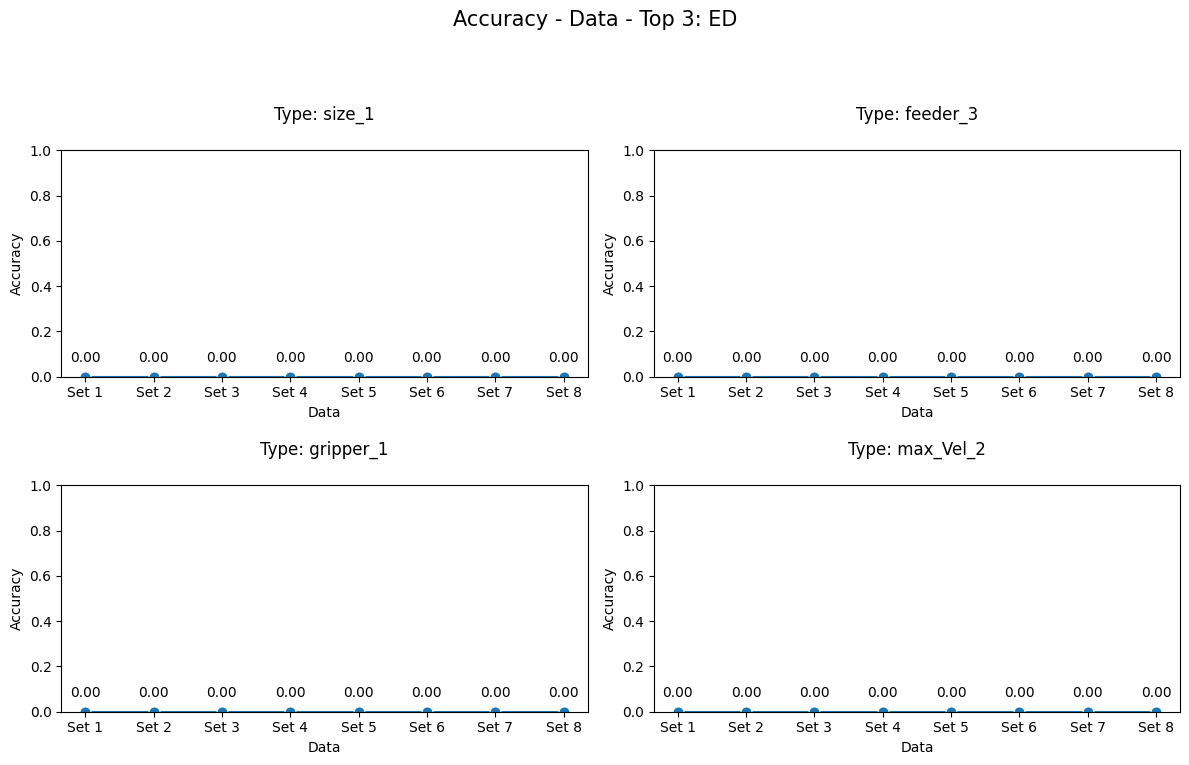

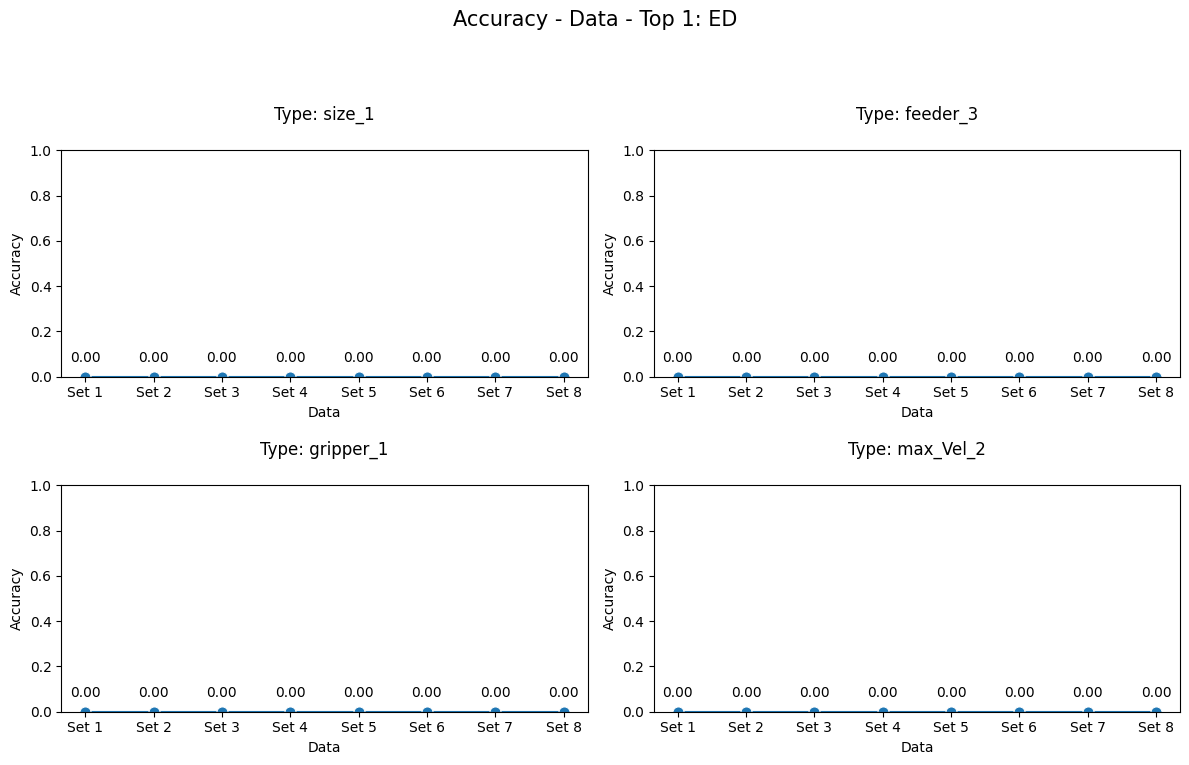

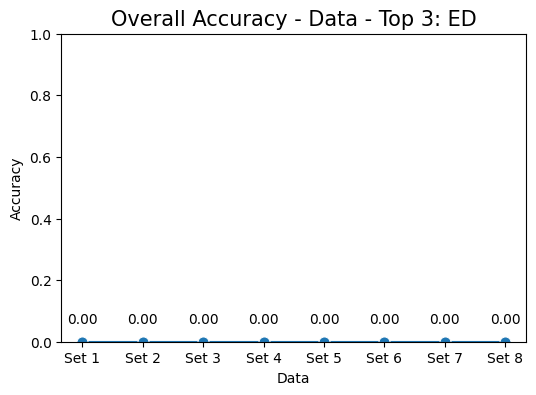

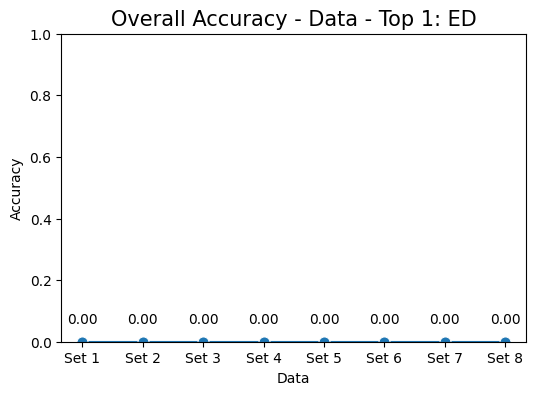

In [964]:
algo='ED'
var='Data'
var_save='data'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

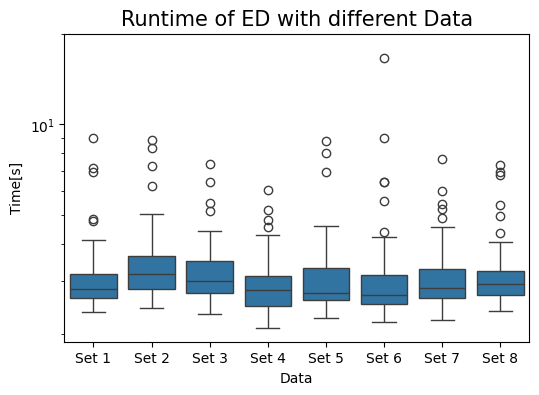

In [965]:
plot_data_runtime(runtime_data_ED.T,directory_figures_path,'runtime_data_6_ED.csv','Data',' ED ')

### RW - Algorithm

In [966]:
result_RW_data_1, runtime_RW_data_1 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-1',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_data_2, runtime_RW_data_2 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-2',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_data_3, runtime_RW_data_3 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-3',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_data_4, runtime_RW_data_4 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-4',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_data_5, runtime_RW_data_5 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-5',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_data_6, runtime_RW_data_6 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-6',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_data_7, runtime_RW_data_7 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-7',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RW_data_8, runtime_RW_data_8 = run_RW_normal_data(folder_path,files,startrow=950,normal_data='normal-8',nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [967]:
result_data_RW = pd.DataFrame()
result_data_RW = pd.concat([result_RW_data_1,result_RW_data_2,result_RW_data_3,result_RW_data_4,result_RW_data_5,result_RW_data_6,result_RW_data_7,result_RW_data_8], ignore_index=True)
result_data_RW['Normal Data'] = pd.DataFrame({'RW':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
result_data_RW.set_index('Normal Data', inplace=True)

In [968]:
runtime_data_RW = pd.DataFrame()
runtime_data_RW = pd.concat([runtime_RW_data_1.T,runtime_RW_data_2.T,runtime_RW_data_3.T,runtime_RW_data_4.T,runtime_RW_data_5.T,runtime_RW_data_6.T,runtime_RW_data_7.T,runtime_RW_data_8.T], ignore_index=True)
runtime_data_RW['Normal Data'] = pd.DataFrame({'RW':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
runtime_data_RW.set_index('Normal Data', inplace=True)

In [969]:
result_data_3top = results_top_3(result_data_RW,abnormal_sets)
result_data_1top = results_top_1(result_data_RW,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_6_RW.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_6_RW.csv'))

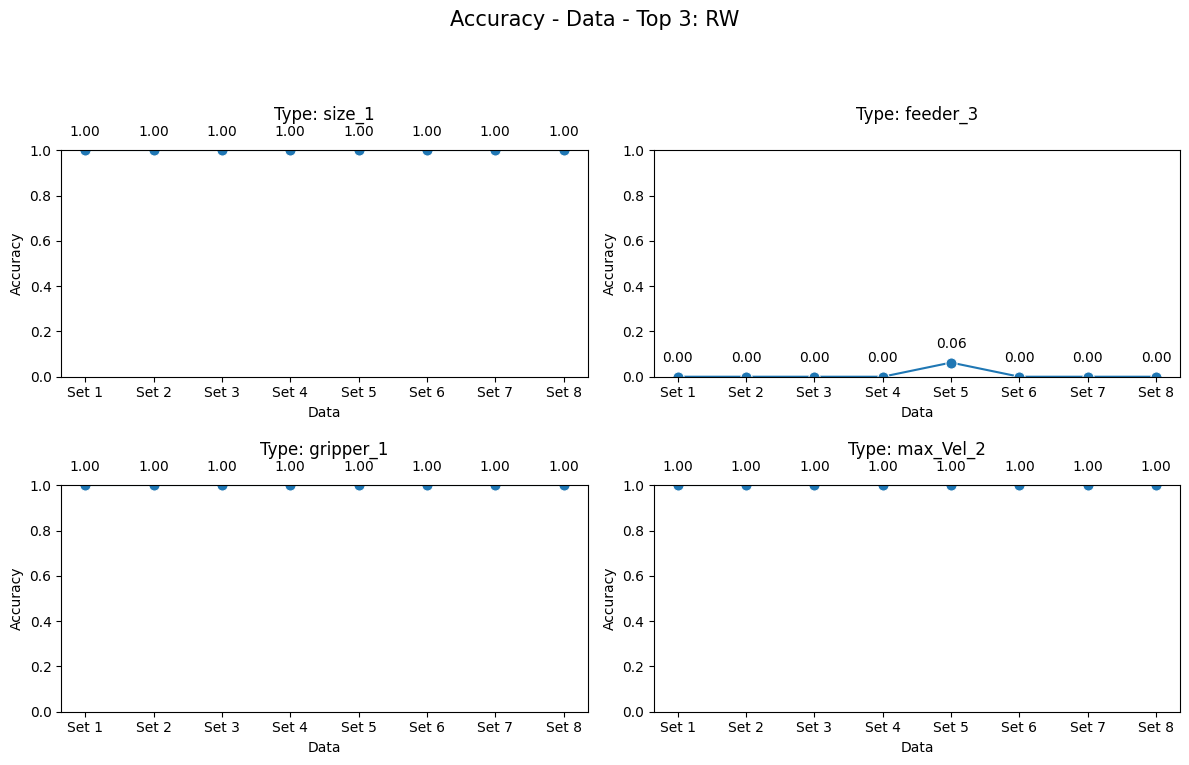

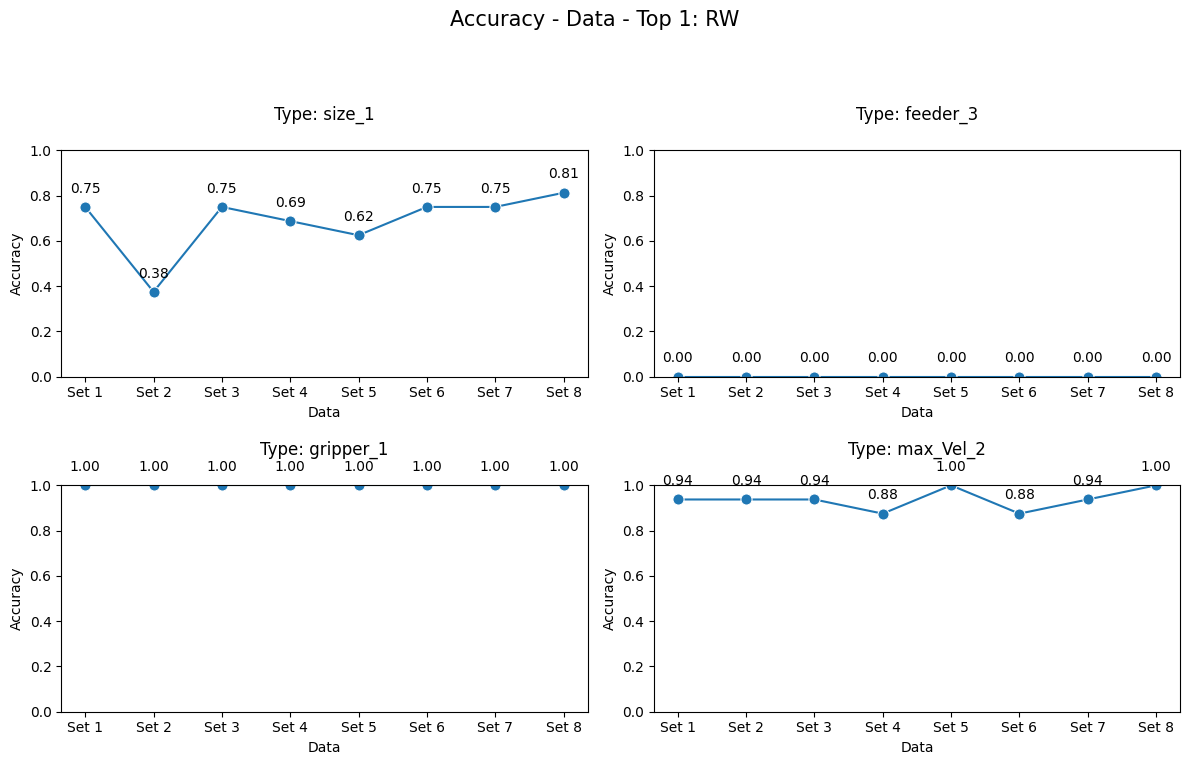

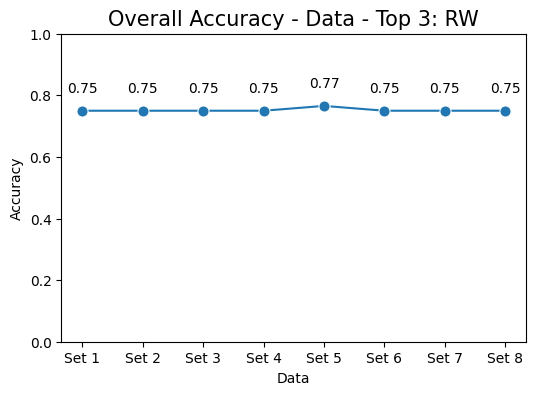

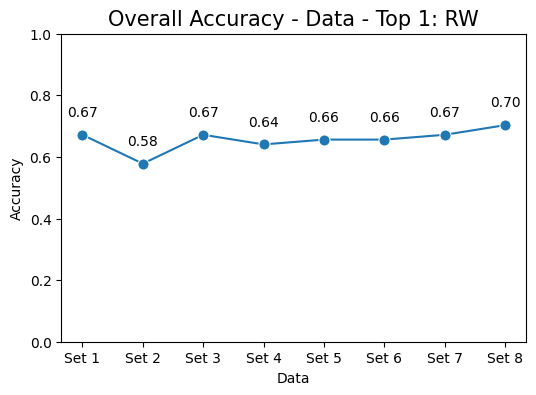

In [970]:
algo='RW'
var='Data'
var_save='data'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

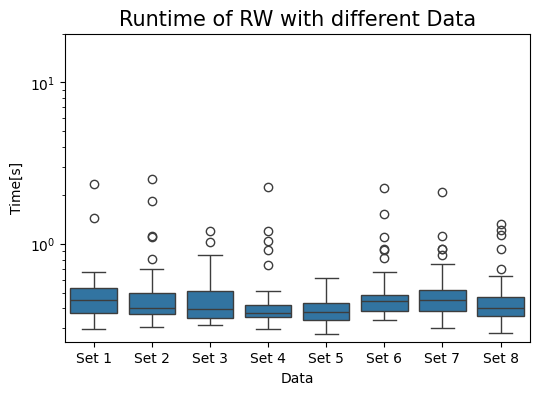

In [971]:
plot_data_runtime(runtime_data_RW.T,directory_figures_path,'runtime_data_6_RW.csv','Data',' RW ')

### RCD - Algorithm

In [972]:
result_RCD_data_1, runtime_RCD_data_1 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-1',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_data_2, runtime_RCD_data_2 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-2',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_data_3, runtime_RCD_data_3 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-3',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_data_4, runtime_RCD_data_4 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-4',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_data_5, runtime_RCD_data_5 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-5',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_data_6, runtime_RCD_data_6 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-6',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_data_7, runtime_RCD_data_7 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-7',nodes=nodes,edges_list=edges,key_nodes=check_nodes)
result_RCD_data_8, runtime_RCD_data_8 = run_RCD_normal_data(folder_path,files,startrow=950,normal_data='normal-8',nodes=nodes,edges_list=edges,key_nodes=check_nodes)

In [973]:
result_data_RCD = pd.DataFrame()
result_data_RCD = pd.concat([result_RCD_data_1,result_RCD_data_2,result_RCD_data_3,result_RCD_data_4,result_RCD_data_5,result_RCD_data_6,result_RCD_data_7,result_RCD_data_8], ignore_index=True)
result_data_RCD['Normal Data'] = pd.DataFrame({'RCD':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
result_data_RCD.set_index('Normal Data', inplace=True)

In [974]:
runtime_data_RCD = pd.DataFrame()
runtime_data_RCD = pd.concat([runtime_RCD_data_1.T,runtime_RCD_data_2.T,runtime_RCD_data_3.T,runtime_RCD_data_4.T,runtime_RCD_data_5.T,runtime_RCD_data_6.T,runtime_RCD_data_7.T,runtime_RCD_data_8.T], ignore_index=True)
runtime_data_RCD['Normal Data'] = pd.DataFrame({'RW':['Set 1','Set 2','Set 3','Set 4','Set 5','Set 6','Set 7','Set 8']})
runtime_data_RCD.set_index('Normal Data', inplace=True)

In [975]:
result_data_3top = results_top_3(result_data_RCD,abnormal_sets)
result_data_1top = results_top_1(result_data_RCD,abnormal_sets)
result_data_3top.to_csv(os.path.join(main_dir, 'result_data_3top_6_RCD.csv'))
result_data_1top.to_csv(os.path.join(main_dir, 'result_data_1top_6_RCD.csv'))

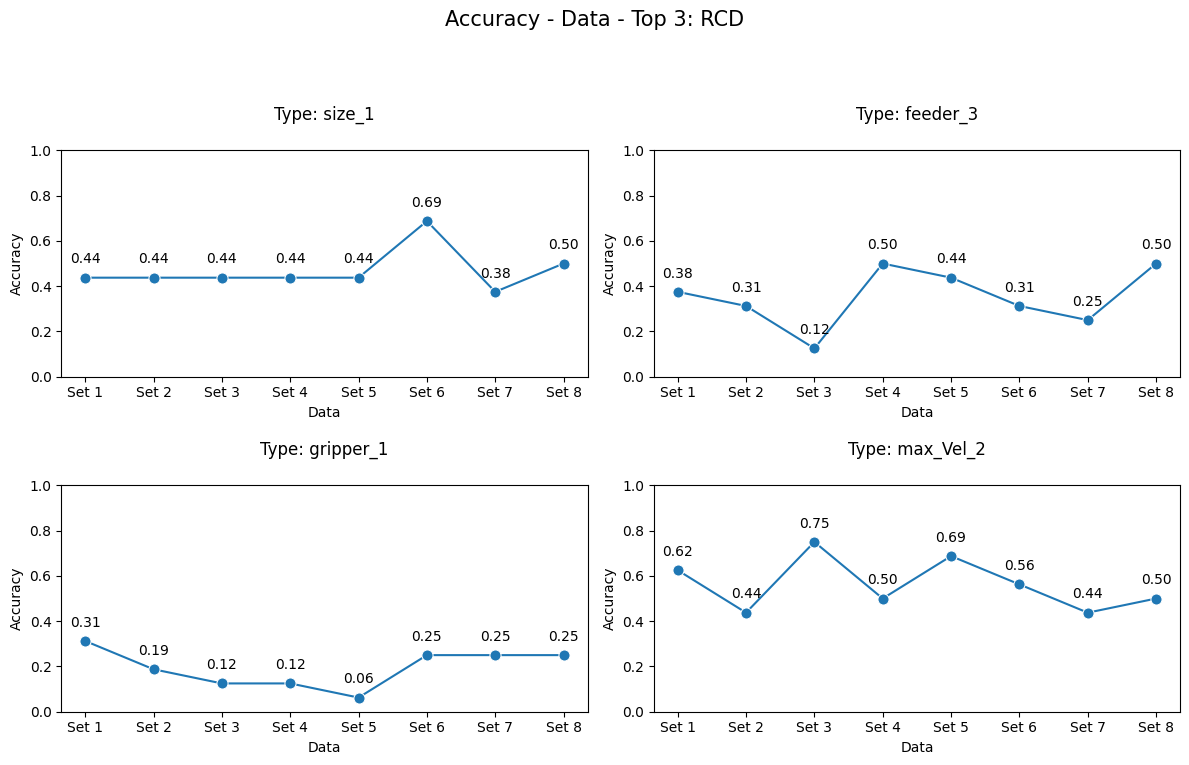

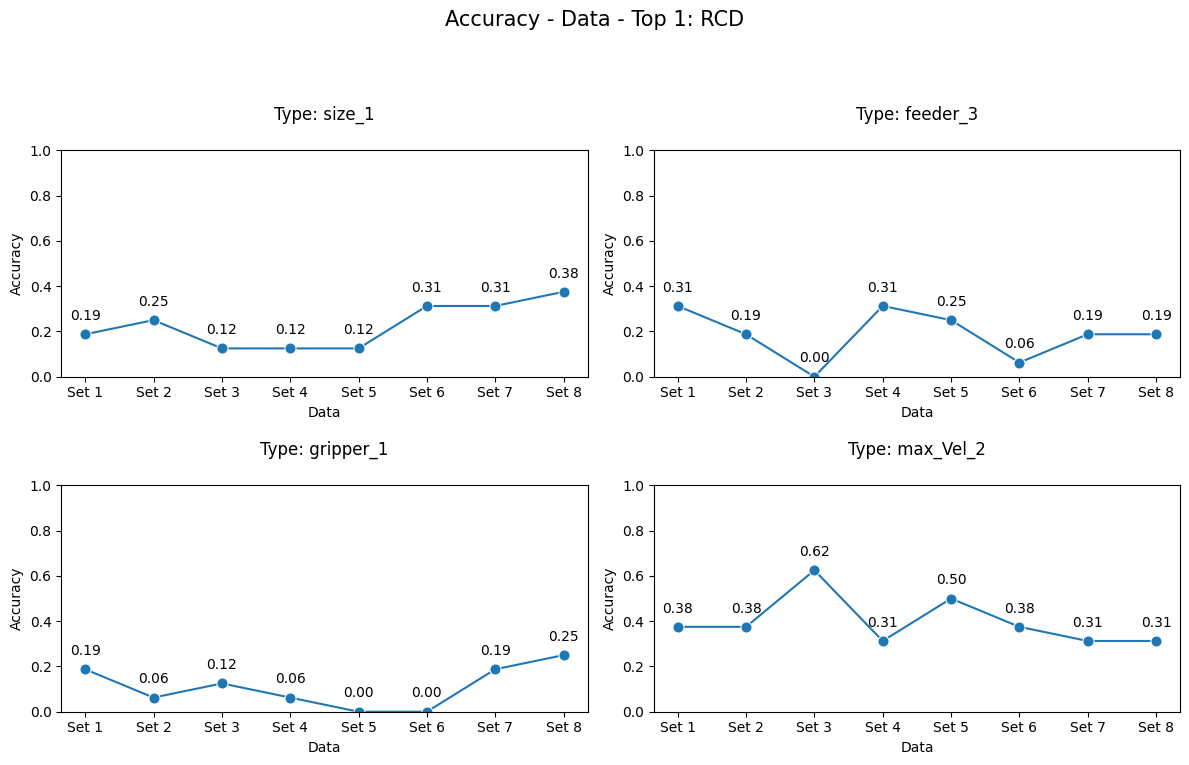

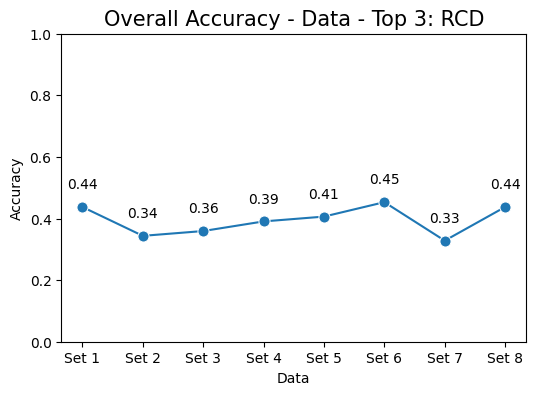

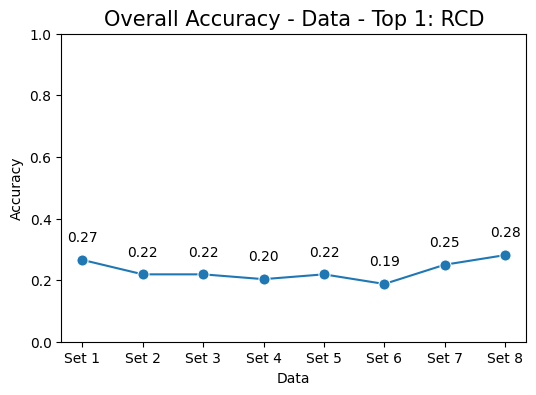

In [976]:
algo='RCD'
var='Data'
var_save='data'
plot_avg_var_inter(result_data_3top,directory_figures_path,'3top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 3:')
plot_avg_var_inter(result_data_1top,directory_figures_path,'1top_'+var_save+'_'+algo,var,algo,'Accuracy - '+var+' - Top 1:')
plot_avg_var_total(result_data_3top,directory_figures_path,'3top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 3:')
plot_avg_var_total(result_data_1top,directory_figures_path,'1top_'+var_save+'_total_'+algo,var,algo,'Overall Accuracy - '+var+' - Top 1:')

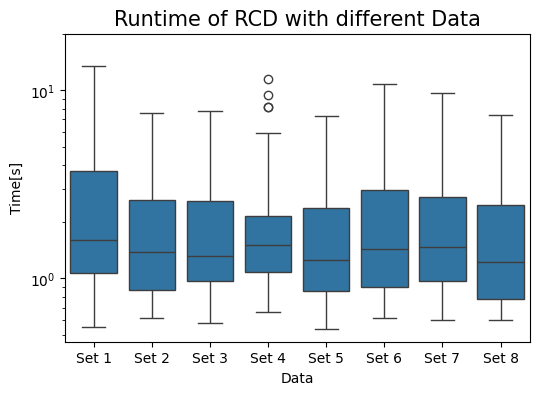

In [977]:
plot_data_runtime(runtime_data_RCD.T,directory_figures_path,'runtime_data_6_RCD.csv','Data',' RCD ')

### All together

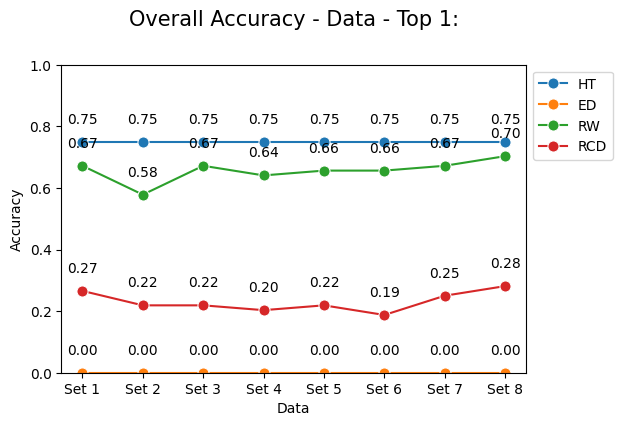

In [978]:
result1 = results_top_1(result_data_HT,abnormal_sets)
result2 = results_top_1(result_data_ED,abnormal_sets)
result3 = results_top_1(result_data_RW,abnormal_sets)
result4 = results_top_1(result_data_RCD,abnormal_sets)

results_dfs = [result1,result2,result3,result4]
plot_avg_var_total_combined(results_dfs,['HT','ED','RW','RCD'] ,directory_figures_path,'1top_data_total','Data','Overall Accuracy - Data - Top 1:')

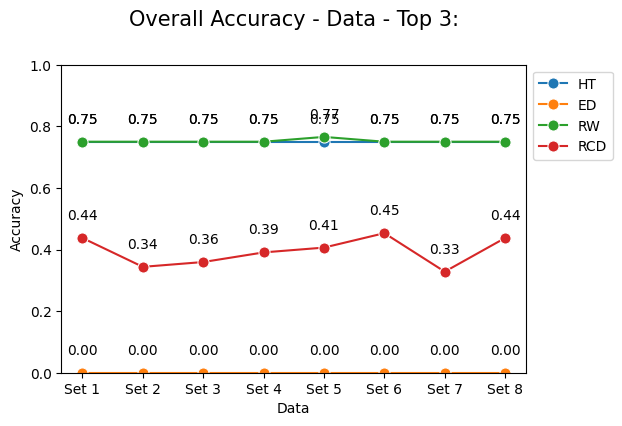

In [979]:
result1 = results_top_3(result_data_HT,abnormal_sets)
result2 = results_top_3(result_data_ED,abnormal_sets)
result3 = results_top_3(result_data_RW,abnormal_sets)
result4 = results_top_3(result_data_RCD,abnormal_sets)

results_dfs = [result1,result2,result3,result4]
plot_avg_var_total_combined(results_dfs,['HT','ED','RW','RCD'] ,directory_figures_path,'3top_data_total','Data','Overall Accuracy - Data - Top 3:')